In [ ]:
!pip install "openpyxl == 3.0.0"

     |████████████████████████████████| 172 kB 5.4 MB/s 
  Created wheel for openpyxl: filename=openpyxl-3.0.0-py2.py3-none-any.whl size=241207 sha256=220dff0c29c3d73eeb25b8ecaa136c37ccaf6171ec09848cff2f465d94f44d71
  Stored in directory: /root/.cache/pip/wheels/c7/64/ff/ce98f6e1d2701ae8e216c875da62feed2839ac8a3cae0ab8af
Successfully built openpyxl
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 3.0.9
    Uninstalling openpyxl-3.0.9:
      Successfully uninstalled openpyxl-3.0.9


In [ ]:
#@title Import
from typing import Dict, Tuple, Callable, Optional, List, Any
from scipy import stats
from scipy import fftpack
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np
import torch
import gc
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import logging
import copy
import time
import itertools
import collections
from sklearn.metrics import confusion_matrix
import sklearn.metrics as skm
from sklearn import tree
from sklearn import cluster
import sklearn.utils.multiclass as skum
from sklearn.model_selection import KFold
import timeit
import scipy.signal
import scipy.interpolate
import pandas as pd
import os
import sklearn
import math
from sklearn.metrics import cohen_kappa_score
import copy
from random import shuffle
import seaborn
from matplotlib import rc
import glob
# from google3.pyglib import gfile
from IPython.display import HTML
rc('animation', html='jshtml')
matplotlib.rcParams['animation.embed_limit'] = 2**30

In [ ]:
#@title Predefine Constants
window = scipy.signal.gaussian(51, std=7)
sos = scipy.signal.butter(3, 1/15, btype='low', output='sos')

landmarks = ['0 nose', '1 left eye (inner)', '2 left eye', '3 left eye (outer)', '4 right eye (inner)','5 - right eye',
  '6 - right eye (outer)','7 - left ear','8 - right ear','9 - mouth (left)','10 - mouth (right)','11 - left shoulder',
  '12 - right shoulder','13 - left elbow','14 - right elbow','15 - left wrist','16 - right wrist','17 - left pinky',
  '18 - right pinky','19 - left index','20 - right index','21 - left thumb','22 - right thumb','23 - left hip',
  '24 - right hip','25 - left knee','26 - right knee','27 - left ankle','28 - right ankle','29 - left heel',
  '30 - right heel','31 - left foot index','32 - right foot index']
lines = [(0, 2), (0, 5), (8, 5), (2, 7), (10, 9), (12, 11), (12, 14), (12, 24),
         (14, 16), (16, 18), (16, 20), (16,22), (18, 20), (11, 13), (11, 23),
         (13, 15), (15,17),(15,19),(15,21), (24,23), (24,26), (26,28), (25,27),
         (28,30),(28,32),(30,32),(23,25),(27,29),(27,31),(29,31)]
connections = np.array(lines)

In [ ]:
# Get Data from google drive
# You need put data in a folder in your google drive. I put it in UCSF/output_data/gait_fullbody.
# The command will copy it to local /tmp directory for process.
# It will be deleted when this colab is shutdown.
from google.colab import drive
drive.mount('/drive')
!cp /drive/MyDrive/Abbasi?Lab/Upper?Body?Gait?Analysis/*.csv /tmp
!cp /drive/MyDrive/Abbasi?Lab/Upper?Body?Gait?Analysis/motor_scales_all_2021.03.08.xlsx /tmp
gait_files = glob.glob('/tmp/*gait.csv')
gait_files

Mounted at /drive


['/tmp/google_21987_off_gait.csv',
 '/tmp/google_32019_on_gait.csv',
 '/tmp/google_32205_off_gait.csv',
 '/tmp/google_31875_off_gait.csv',
 '/tmp/google_31875_on_gait.csv',
 '/tmp/google_22423_off_gait.csv',
 '/tmp/google_20452_off_gait.csv',
 '/tmp/google_20190_on_gait.csv',
 '/tmp/google_31601_off_gait.csv',
 '/tmp/google_20592_on_gait.csv',
 '/tmp/google_31876_off_gait.csv',
 '/tmp/google_25233_on_gait.csv',
 '/tmp/google_31937_off_gait.csv',
 '/tmp/google_31917_on_gait.csv',
 '/tmp/google_31710_off_gait.csv',
 '/tmp/google_22423_on_gait.csv',
 '/tmp/google_31684_on_gait.csv',
 '/tmp/google_31937_on_gait.csv',
 '/tmp/google_25288_on_gait.csv',
 '/tmp/google_20592_off_gait.csv',
 '/tmp/google_31892_on_gait.csv',
 '/tmp/google_31917_off_gait.csv',
 '/tmp/google_32205_on_gait.csv',
 '/tmp/google_32019_off_gait.csv',
 '/tmp/google_31876_on_gait.csv']

In [ ]:
updrs_data = pd.read_excel("/tmp/motor_scales_all_2021.03.08.xlsx", sheet_name="Sheet1")
labels = {}
for f in gait_files:
  pid = int(f.split("_")[1])
  key = f.split("/")[2].split(".")[0]
  on_state = key.split("_")[-2]
  if on_state == "on":
    score = updrs_data[updrs_data["pidn"] == pid]["updrs.on.3.10"]
    if len(score) == 1:
      labels[key] = int(score)
    else:
      labels[key] = -99
  else:
    score = updrs_data[updrs_data["pidn"] == pid]["updrs.off.3.10"]
    if len(score) == 1:
      labels[key] = int(score)
    else:
      labels[key] = -99

In [ ]:
labels

{'google_20190_on_gait': 1,
 'google_20452_off_gait': 1,
 'google_20592_off_gait': 1,
 'google_20592_on_gait': 1,
 'google_21987_off_gait': 1,
 'google_22423_off_gait': 2,
 'google_22423_on_gait': 2,
 'google_25233_on_gait': 0,
 'google_25288_on_gait': 0,
 'google_31601_off_gait': -2,
 'google_31684_on_gait': -99,
 'google_31710_off_gait': -99,
 'google_31875_off_gait': 0,
 'google_31875_on_gait': 0,
 'google_31876_off_gait': 2,
 'google_31876_on_gait': 1,
 'google_31892_on_gait': 1,
 'google_31917_off_gait': 0,
 'google_31917_on_gait': 0,
 'google_31937_off_gait': 1,
 'google_31937_on_gait': 1,
 'google_32019_off_gait': 1,
 'google_32019_on_gait': 1,
 'google_32205_off_gait': 1,
 'google_32205_on_gait': 1}

In [ ]:
seed = 123
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed)
# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)
# 3. Set `torch` pseudo-random generator at a fixed value
torch.manual_seed(seed)

In [ ]:
#@title Load files Google.
#gait_files = gfile.Glob('/cns/iq-d/home/jiancui/tmp/gait_fullbody/*.csv')

In [ ]:
#fake_files = gfile.Glob('/cns/iq-d/home/jiancui/tmp/fake/*')

In [ ]:
#@title IO, Animation, Processing
def generate_pose_mat(filename):
  df = pd.read_csv(filename, header=None)
  column_name = ['timestamp', 'inst']
  for x in landmarks:
    column_name.extend([x+':y', x+':x', x+':z'])
  df.columns = column_name
  xy_columns = [i for i in range(99) if i%3 != 2]
  df2 = df.loc[:, :].rolling(window=5, win_type='gaussian', center=True).mean(std=0.5)[2:-2]
  pose = df2.iloc[:, 2:].to_numpy()
  pose_xy = pose[:, xy_columns]
  a = list(range(pose_xy.shape[1]))
  new_idx = list(sum(list(zip(a[1::2], a[::2])), ()))
  pose_xy[a] = pose_xy[new_idx]
  return pose_xy, pose

def animate(mat, connections):
  fig, ax = plt.subplots(figsize=(5, 10))
  ax.set_xlim(0, 1)
  ax.set_ylim(0, 1.6)
  ax.invert_yaxis()
  poselines = []
  for conn in connections:
    if conn[0] % 2 == 0:
      oneline, = ax.plot([], [], 'ro-')
    else:
      oneline, = ax.plot([], [], 'bo-')
    poselines.append(oneline)
  def update_frame(i):
    for j, oneline in enumerate(poselines):
      oneline.set_data(mat[i, 2*connections[j]], mat[i, 2*connections[j]+1])
    return poselines

  return animation.FuncAnimation(fig, update_frame, frames=range(mat.shape[0]), interval=33)
 
def find_cluster(zeros, threshold=10):
  """Find zero crossing cluster within a threshold."""
  clusters = []
  cluster = []
  prev = 0
  for zz in zeros:
    if zz - prev < threshold:
      prev = zz
      cluster.append(zz)
    else:
      clusters.append(cluster)
      cluster = [zz]
      prev = zz
  clusters.append(cluster)
  return clusters

def find_segment(clusters, end):
  """Find the segment separate the cluster, sorted by length."""
  left = 0
  segments = []
  for c in clusters:
    if len(c) > 1:
      if left < c[0] - 10:
        segments.append((left, c[0]-10))
      left = c[-1]+10
  segments.append((left, end))
  return sorted(segments, key=lambda x: x[1]-x[0])

class PoseSeries:
  """Pose time series"""
  Joints = collections.namedtuple('Joints', ['nose', 'left_eye', 'right_eye', 'left_shoulder', 'right_shoulder',
                                           'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip',
                                           'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle',
                                           'left_heel', 'right_heel'])
  def __init__(self, filename):
    self.id = filename.split('/')[-1].split('.')[0]
    xy, _ = generate_pose_mat(filename)
    self.pose2d = xy
    self.joints = self.get_joints()

  def get_joints(self):
    #'0 nose', '1 left eye (inner)', '2 left eye', '3 left eye (outer)', '4 right eye (inner)','5 - right eye',
    #  '6 - right eye (outer)','7 - left ear','8 - right ear','9 - mouth (left)','10 - mouth (right)','11 - left shoulder',
    #  '12 - right shoulder','13 - left elbow','14 - right elbow','15 - left wrist','16 - right wrist','17 - left pinky',
    #  '18 - right pinky','19 - left index','20 - right index','21 - left thumb','22 - right thumb','23 - left hip',
    #  '24 - right hip','25 - left knee','26 - right knee','27 - left ankle','28 - right ankle','29 - left heel',
    #  '30 - right heel','31 - left foot index','32 - right foot index'
    pose_seg = self.pose2d
    nose = [pose_seg[:,:2]]
    left_eye = [pose_seg[:, 2:4]]
    right_eye = [pose_seg[:, 10:12]]
    left_shoulder = [pose_seg[:, 22:24]]
    right_shoulder = [pose_seg[:, 24:26]]
    left_elbow = [pose_seg[:, 26:28]]
    right_elbow = [pose_seg[:, 28:30]]
    left_wrist = [pose_seg[:, 32:34]]
    right_wrist = [pose_seg[:, 34:36]]
    left_hip = [pose_seg[:, 46:48]]
    right_hip = [pose_seg[:, 48:50]]
    left_knee = [pose_seg[:, 52:54]]
    right_knee = [pose_seg[:, 54:56]]
    left_ankle = [pose_seg[:, 56:58]]
    right_ankle = [pose_seg[:, 58:60]]
    left_heel = [pose_seg[:, 60:62]]
    right_heel = [pose_seg[:, 62:64]]
    return PoseSeries.Joints(nose, left_eye, right_eye, left_shoulder, right_shoulder, left_elbow, right_elbow, left_wrist,
      right_wrist, left_hip, right_hip, left_knee, right_knee, left_ankle, right_ankle, left_heel, right_heel)

  def update_good_range(self, copy=False):
    if copy:
      self.new_pose2d = self.pose2d
      self.new_joints = self.joints
      return self.new_joints
    left_shoulder = self.joints.left_shoulder[0]
    right_shoulder = self.joints.right_shoulder[0]
    dist = left_shoulder[:, 0] - right_shoulder[:, 0]
    dist_flt = scipy.signal.sosfiltfilt(sos, dist)
    zc = np.where(np.abs(dist-dist_flt) > 0.02)[0]
    clusters = find_cluster(zc, 10)
    segments = find_segment(clusters, dist.shape[0])
    top2 = segments[-2:]
    newjoints_value = []
    for v in self.joints:
      first = v[0][top2[1][0]:top2[1][1]]
      second = v[0][top2[0][0]:top2[0][1]]
      newjoints_value.append((first, second))
      #newjoints_value.append(first)
    self.new_joints = PoseSeries.Joints(*newjoints_value)
    self.new_pose2d = self.pose2d[top2[1][0]:top2[1][1]]
    return self.new_joints

  def describe(name):
    return {
        'arm': 'elbow - wrist',
        'leg': 'heel - knee',
    }[name]

  def left_arm(self, idx=0, use_all=False):
    joints = self.new_joints
    if use_all:
      joints = self.joints
    left_elbow = joints.left_elbow[idx]
    left_wrist = joints.left_wrist[idx]
    return left_elbow - left_wrist

  def right_arm(self, idx=0, use_all=False):
    joints = self.new_joints
    if use_all:
      joints = self.joints
    right_elbow = joints.right_elbow[idx]
    right_wrist = joints.right_wrist[idx]
    return right_elbow - right_wrist

  def left_leg(self, idx=0, use_all=False):
    joints = self.new_joints
    if use_all:
      joints = self.joints
    left_heel = joints.left_heel[idx]
    left_knee = joints.left_knee[idx]
    return left_knee - left_heel

  def right_leg(self, idx=0, use_all=False):
    joints = self.new_joints
    if use_all:
      joints = self.joints
    right_heel = joints.right_heel[idx]
    right_knee = joints.right_knee[idx]
    return right_knee - right_heel

  def height(self, idx=0, use_all=False):
    joints = self.new_joints
    if use_all:
      joints = self.joints
    left_shoulder = joints.left_shoulder[idx]
    right_hip = joints.right_hip[idx]
    return np.linalg.norm(left_shoulder - right_hip, axis=1)

  def heel_distance(self, idx=0, use_all=False):
    joints = self.new_joints
    if use_all:
      joints = self.joints
    left_heel = joints.left_heel[idx]
    right_heel = joints.right_heel[idx]
    return np.linalg.norm(left_heel - right_heel, axis=1)

  def left_wrist_right_ankle(self, idx=0, use_all=False):
    joints = self.new_joints
    if use_all:
      joints = self.joints
    left_wrist = joints.left_wrist[idx]
    right_ankle = joints.right_ankle[idx]
    return np.linalg.norm(left_wrist-right_ankle, axis=1)

  def right_wrist_left_ankle(self, idx=0, use_all=False):
    joints = self.new_joints
    if use_all:
      joints = self.joints
    right_wrist = joints.right_wrist[idx]
    left_ankle = joints.left_ankle[idx]
    return np.linalg.norm(right_wrist-left_ankle, axis=1)

In [ ]:
# Build PoseSeries for each session.
poses = []
for gf in gait_files:
  try:
    pose_series = PoseSeries(gf)
    pose_series.update_good_range()
    poses.append(pose_series)
    print(gf)
  except:
    continue

/tmp/google_21987_off_gait.csv
/tmp/google_32019_on_gait.csv
/tmp/google_32205_off_gait.csv
/tmp/google_31875_off_gait.csv
/tmp/google_31875_on_gait.csv
/tmp/google_22423_off_gait.csv
/tmp/google_20452_off_gait.csv
/tmp/google_20190_on_gait.csv
/tmp/google_20592_on_gait.csv
/tmp/google_31876_off_gait.csv
/tmp/google_25233_on_gait.csv
/tmp/google_31937_off_gait.csv
/tmp/google_31710_off_gait.csv
/tmp/google_22423_on_gait.csv
/tmp/google_31684_on_gait.csv
/tmp/google_31937_on_gait.csv
/tmp/google_25288_on_gait.csv
/tmp/google_20592_off_gait.csv
/tmp/google_31892_on_gait.csv
/tmp/google_31917_off_gait.csv
/tmp/google_32205_on_gait.csv
/tmp/google_32019_off_gait.csv
/tmp/google_31876_on_gait.csv


In [ ]:
# poses = []
# for gf in fake_files:
#   pose_series = PoseSeries(gf)
#   pose_series.update_good_range(copy=True)
#   poses.append(pose_series)

In [ ]:
# fake_files

In [ ]:
# fullposes = []
# for gf in gait_files:
#   pose_series = PoseSeries(gf)
#   pose_series.update_good_range(copy=True)
#   fullposes.append(pose_series)

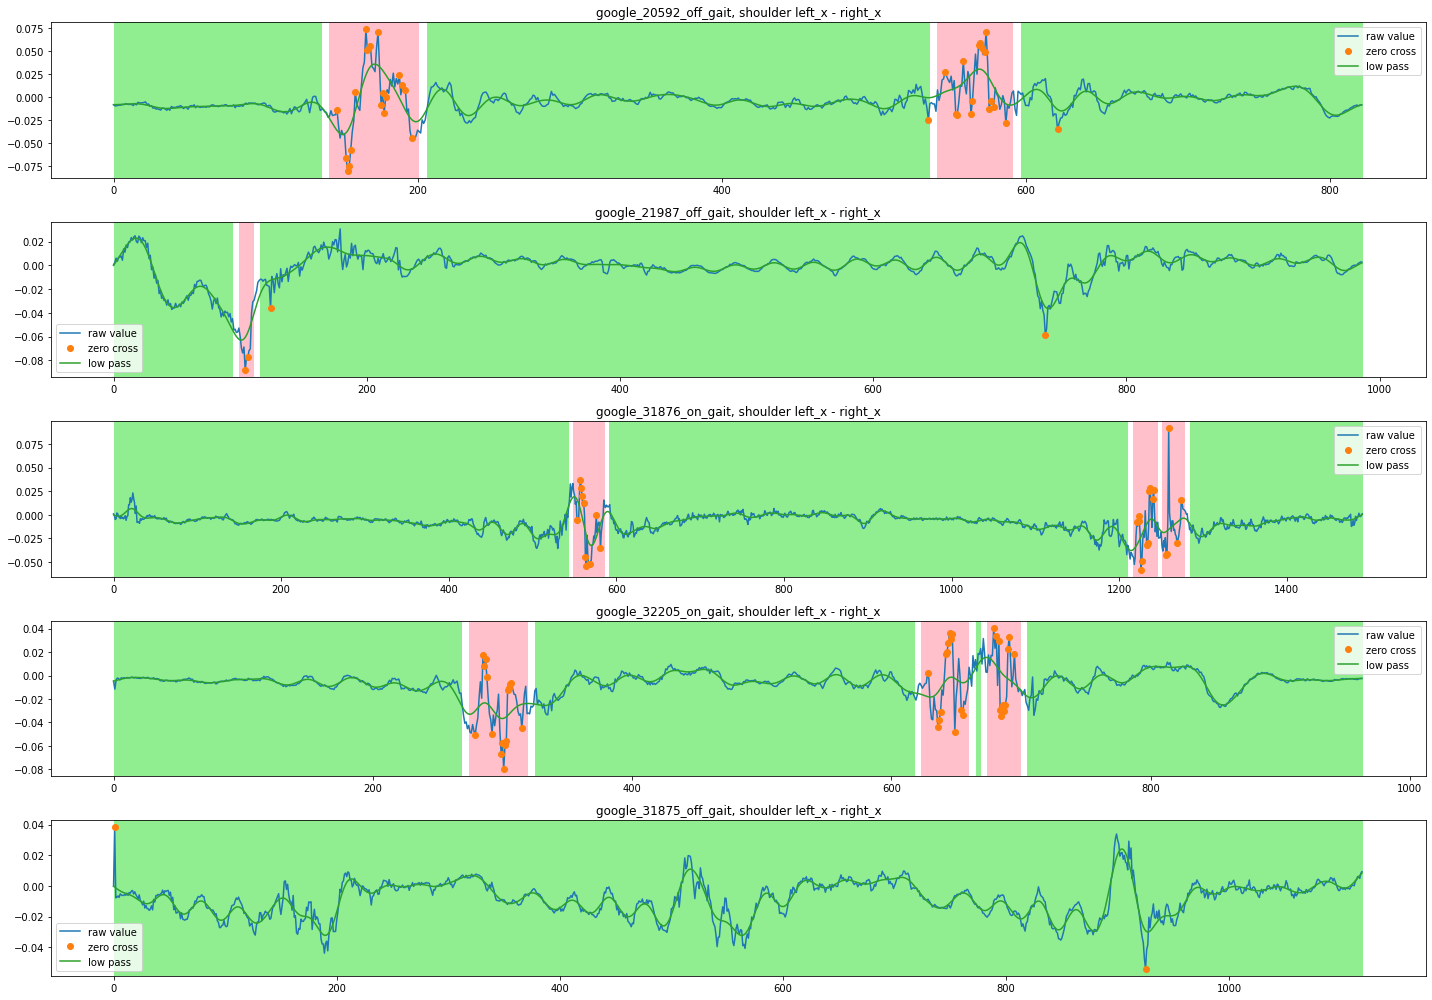

In [ ]:
#@title Plot shoulder Left x - Right x
fig, ax = plt.subplots(5, figsize=(20, 14))
for i in range(5):
  joints = poses[i].joints
  left_shoulder = joints.left_shoulder[0]
  right_shoulder = joints.right_shoulder[0]
  dist = left_shoulder[:, 1] - right_shoulder[:, 1]
  #fxx, txx, spectro = scipy.signal.spectrogram(dist, fs=30, nperseg=80, noverlap=70, nfft=128)
  dist_flt = scipy.signal.sosfiltfilt(sos, dist)
  #zc = np.where(np.diff(np.sign(dist - dist_flt)))[0]
  zc = np.where(np.abs(dist-dist_flt) > 0.02)[0]
  clusters = find_cluster(zc, 10)
  segments = find_segment(clusters, dist.shape[0])
  ax[i].set_title(f'{poses[i].id}, shoulder left_x - right_x')
  ax[i].plot(dist, label='raw value')
  ax[i].plot(zc, dist[zc], 'o', label='zero cross')
  ax[i].plot(dist_flt, label='low pass ')
  #ax[2*i+1].imshow(np.log(spectro[:20,:]), aspect='auto')
  for c in clusters:
    if len(c) > 1:
      ax[i].axvspan(c[0]-5, c[-1]+5, facecolor='pink')
  for s in segments:
    ax[i].axvspan(s[0], s[1], facecolor='lightgreen')
  ax[i].legend()
plt.tight_layout()

In [ ]:
for pose in poses:
  print(pose.id, pose.pose2d.shape, pose.new_pose2d.shape)

google_20190_on_gait (789, 66) (201, 66)
google_20592_on_gait (717, 66) (505, 66)
google_25233_on_gait (494, 66) (129, 66)
google_20452_off_gait (857, 66) (251, 66)
google_32019_on_gait (861, 66) (277, 66)
google_31937_on_gait (908, 66) (328, 66)
google_22423_off_gait (599, 66) (335, 66)
google_32019_off_gait (500, 66) (172, 66)
google_21987_off_gait (987, 66) (327, 66)
google_31875_off_gait (1120, 66) (518, 66)
google_25288_on_gait (701, 66) (224, 66)
google_31876_off_gait (827, 66) (341, 66)
google_31917_off_gait (439, 66) (381, 66)
google_22423_on_gait (524, 66) (369, 66)
google_32205_on_gait (964, 66) (279, 66)
google_31876_on_gait (1491, 66) (540, 66)
google_32205_off_gait (809, 66) (292, 66)
google_31684_on_gait (1018, 66) (499, 66)
google_31710_off_gait (1658, 66) (411, 66)
google_31937_off_gait (1035, 66) (339, 66)
google_20592_off_gait (822, 66) (336, 66)
google_31875_on_gait (791, 66) (189, 66)
google_31892_on_gait (356, 66) (245, 66)


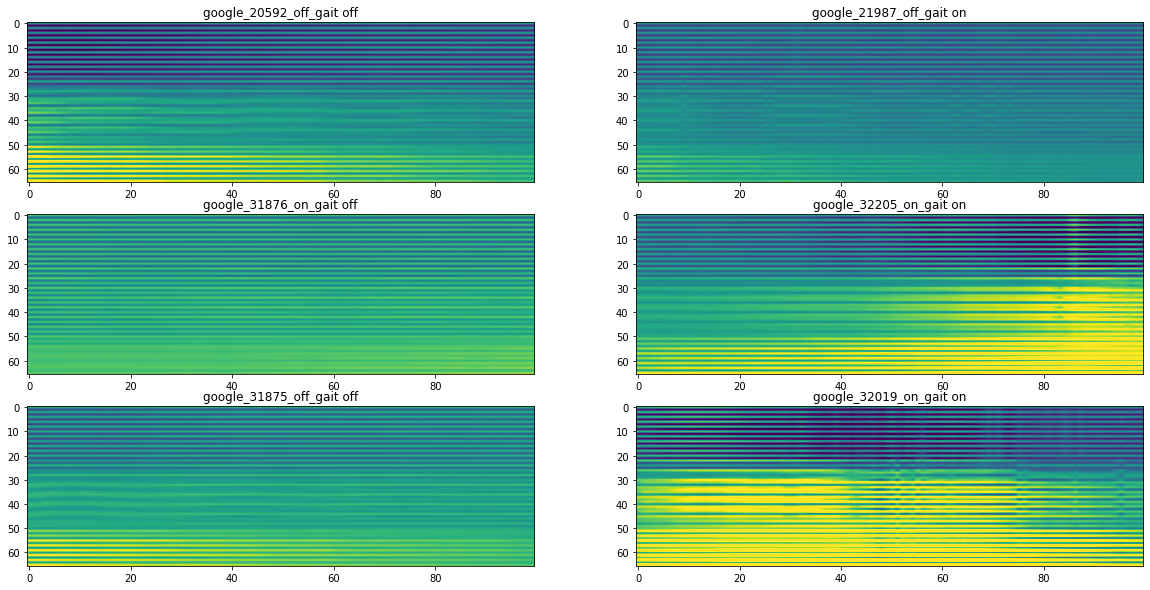

In [ ]:
#@title All landmark's progression plot
# ranges = [
#   (200, 600), (250, 700),
#   (300, 700), (240, 550),
#   (250, 500), (300, 700)
# ]
fig, ax = plt.subplots(3, 2, figsize=(20, 10))
for i, pose in enumerate(poses[:6]):
  m1 = pose.pose2d[200:300].T[...,np.newaxis]
  ax[i//2, i%2].imshow(m1.squeeze(), aspect='auto', vmin=0, vmax=1)
  ax[i//2, i%2].set_title(pose.id + (' off' if i%2==0 else ' on'))

In [ ]:
#@title Code to plot animations
def animate(title, mat, connections):
  """Animation with skeleton.

  Args:
    title: title of the plot
    mat: xy points for the whole body.
    connections: idx for connection points to form skeleton.
  """
  fig = plt.figure(constrained_layout=False, figsize=(10, 15))
  plt.title(title)
  plt.xlim(0, 1)
  plt.ylim(0, 1.6)
  plt.gca().invert_yaxis()
  poselines = []
  for conn in connections:
    if conn[0] % 2 == 0:
      oneline, = plt.plot([], [], 'ro-')
    else:
      oneline, = plt.plot([], [], 'bo-')
    poselines.append(oneline)
  def update_frame(i):
    for j, oneline in enumerate(poselines):
      oneline.set_data(mat[i, 2*connections[j]], mat[i, 2*connections[j]+1])
    return poselines

  return animation.FuncAnimation(fig, update_frame, frames=range(mat.shape[0]))

def animate_with_plot(title, mat, connections, pairs):
  """Animation with skeleton and metrics.

  Args:
    title: title of the plot
    mat: xy points for the whole body.
    connections: idx for connection points to form skeleton.
    pairs: Dict[name, [left_metrics, right_metrics]] is a dictionary of left/right metrics.
      Total count <= 5.
  """
  fig = plt.figure(constrained_layout=False, figsize=(15, 20))
  plt.suptitle(title)
  gs = fig.add_gridspec(nrows=6, ncols=2, wspace=0.1)
  ax1 = fig.add_subplot(gs[1:5, 0])
  ax_metrics = []
  for j in range(len(pairs)):
    ax = fig.add_subplot(gs[j, 1])
    ax_metrics.append(ax)
  ax1.set_xlim(0, 1)
  ax1.set_ylim(0, 1.6)
  ax1.invert_yaxis()
  vls = []
  for ax, metric_name in zip(ax_metrics, pairs.keys()):
    metrics = pairs[metric_name]
    if metric_name == "Heel distance":
      peak, _ = scipy.signal.find_peaks(metrics, distance=20)
      _ = ax.plot(metrics)
      _ = ax.plot(peak, metrics[peak], 'o')
    else:
      peak0, _ = scipy.signal.find_peaks(metrics[0], distance=20)
      peak1, _ = scipy.signal.find_peaks(metrics[1], distance=20)
      _ = ax.plot(metrics[0], label='left')
      _ = ax.plot(metrics[1], label='right')
      _ = ax.plot(peak0, metrics[0][peak0], 'o')
      _ = ax.plot(peak1, metrics[1][peak1], 'o')
    ax.set_title(metric_name)
    ax.legend()
    vl = ax.axvline(0, ls='-', color='r', lw=1, zorder=10)
    vls.append(vl)
  poselines = []
  for conn in connections:
    if conn[0] % 2 == 0:
      oneline, = ax1.plot([], [], 'ro-')
    else:
      oneline, = ax1.plot([], [], 'bo-')
    poselines.append(oneline)
  def update_frame(i):
    for j, oneline in enumerate(poselines):
      oneline.set_data(mat[i, 2*connections[j]], mat[i, 2*connections[j]+1])
    for vl in vls:
      vl.set_xdata([i, i])
    return vls+[poselines]

  return animation.FuncAnimation(fig, update_frame, frames=range(mat.shape[0]))

def animate_compare(title1, mat1, pairs1, title2, mat2, pairs2, connections):
  """Animation with skeleton and metrics.

  Args:
    title: title of the plot
    mat: xy points for the whole body.
    connections: idx for connection points to form skeleton.
    pairs: Dict[name, [left_metrics, right_metrics]] is a dictionary of left/right metrics.
      Total count less than 5.
  """
  fig = plt.figure(constrained_layout=False, figsize=(20, 15))
  plt.suptitle(title1 + ' ' + title2)
  gs = fig.add_gridspec(nrows=6, ncols=4, wspace=0.1)
  ax_body1 = fig.add_subplot(gs[1:5, 0])
  ax_metrics1 = []
  for j in range(len(pairs1)):
    ax = fig.add_subplot(gs[j, 1])
    ax_metrics1.append(ax)
  ax_body2 = fig.add_subplot(gs[:, 2])
  ax_metrics2 = []
  for j in range(len(pairs1)):
    ax = fig.add_subplot(gs[j, 3])
    ax_metrics2.append(ax)
  ax_body1.set_xlim(0, 1)
  ax_body1.set_ylim(0, 1.6)
  ax_body1.invert_yaxis()
  ax_body2.set_xlim(0, 1)
  ax_body2.set_ylim(0, 1.6)
  ax_body2.invert_yaxis()
  vls1 = []
  for ax, metric_name in zip(ax_metrics1, pairs1.keys()):
    metrics = pairs1[metric_name]
    if type(metrics) == str:
        continue
    peak0, _ = scipy.signal.find_peaks(metrics[0], distance=20)
    peak1, _ = scipy.signal.find_peaks(metrics[1], distance=20)
    _ = ax.plot(metrics[0], label='left')
    _ = ax.plot(metrics[1], label='right')
    _ = ax.plot(peak0, metrics[0][peak0], 'o')
    _ = ax.plot(peak1, metrics[1][peak1], 'o')
    ax.set_title(metric_name)
    ax.legend()
    vl = ax.axvline(0, ls='-', color='r', lw=1, zorder=10)
    vls1.append(vl)
  for ax, metric_name in zip(ax_metrics1[2:], pairs1.keys()):
    metrics = pairs1[metric_name]
    if type(metrics) == str:
        continue
    peak0, _ = scipy.signal.find_peaks(metrics[0], distance=20)
    peak1, _ = scipy.signal.find_peaks(metrics[1], distance=20)
    _ = ax.plot(peak0[1:], np.diff(peak0)/30, 'o-', label='left')
    _ = ax.plot(peak1[1:], np.diff(peak1)/30, 'o-', label='right')
    ax.set_title(metric_name + ' peak interval')
    ax.set_ylabel('seconds')
    ax.legend()
    vl = ax.axvline(0, ls='-', color='r', lw=1, zorder=10)
    vls1.append(vl)
  vls2 = []
  for ax, metric_name in zip(ax_metrics2, pairs2.keys()):
    metrics = pairs2[metric_name]
    if type(metrics) == str:
        continue
    peak0, _ = scipy.signal.find_peaks(metrics[0], distance=20)
    peak1, _ = scipy.signal.find_peaks(metrics[1], distance=20)
    _ = ax.plot(metrics[0], label='left')
    _ = ax.plot(metrics[1], label='right')
    _ = ax.plot(peak0, metrics[0][peak0], 'o')
    _ = ax.plot(peak1, metrics[1][peak1], 'o')
    ax.set_title(metric_name)
    ax.legend()
    vl = ax.axvline(0, ls='-', color='r', lw=1, zorder=10)
    vls2.append(vl)
  for ax, metric_name in zip(ax_metrics2[2:], pairs2.keys()):
    metrics = pairs2[metric_name]
    if type(metrics) == str:
        continue
    peak0, _ = scipy.signal.find_peaks(metrics[0], distance=20)
    peak1, _ = scipy.signal.find_peaks(metrics[1], distance=20)
    _ = ax.plot(peak0[1:], np.diff(peak0)/30, 'o-', label='left')
    _ = ax.plot(peak1[1:], np.diff(peak1)/30, 'o-', label='right')
    ax.set_title(metric_name + ' peak interval')
    ax.set_ylabel('seconds')
    ax.legend()
    vl = ax.axvline(0, ls='-', color='r', lw=1, zorder=10)
    vls2.append(vl)
  poselines = []
  poselines2 = []
  for conn in connections:
    if conn[0] % 2 == 0:
      oneline, = ax_body1.plot([], [], 'ro-')
      oneline2, = ax_body2.plot([], [], 'ro-')
    else:
      oneline, = ax_body1.plot([], [], 'bo-')
      oneline2, = ax_body2.plot([], [], 'bo-')
    poselines.append(oneline)
    poselines2.append(oneline2)
  def update_frame(i):
    if i < mat1.shape[0]:
      for j, oneline in enumerate(poselines):
        oneline.set_data(mat1[i, 2*connections[j]], mat1[i, 2*connections[j]+1])
      for vl in vls1:
        vl.set_xdata([i, i])
    if i < mat2.shape[0]:
      for j, oneline in enumerate(poselines2):
        oneline.set_data(mat2[i, 2*connections[j]], mat2[i, 2*connections[j]+1])
      for vl in vls2:
        vl.set_xdata([i, i])
    return vls1+[poselines]+vls2+[poselines2]

  return animation.FuncAnimation(fig, update_frame, frames=range(max(mat1.shape[0], mat2.shape[0])))

def animate_compare_all(title1, mat1, pairs1, title2, mat2, pairs2, connections):
  fig = plt.figure(constrained_layout=False, figsize=(20, 20))
  plt.suptitle(title1 + ':score={}'.format(labels[title1]) + '/' 
               + title2 + ':score={}'.format(labels[title2]), y=0.92)
  gs = fig.add_gridspec(nrows=6, ncols=4, wspace=0.1)
  ax_body1 = fig.add_subplot(gs[1:5, 0])
  ax_metrics1 = []
  for j in range(len(pairs1)):
    ax = fig.add_subplot(gs[j, 1])
    ax_metrics1.append(ax)
  ax_body2 = fig.add_subplot(gs[:, 2])
  ax_metrics2 = []
  for j in range(len(pairs1)):
    ax = fig.add_subplot(gs[j, 3])
    ax_metrics2.append(ax)
  ax_body1.set_xlim(0, 1)
  ax_body1.set_ylim(0, 1.6)
  ax_body1.invert_yaxis()
  ax_body2.set_xlim(0, 1)
  ax_body2.set_ylim(0, 1.6)
  ax_body2.invert_yaxis()
  vls1 = []
  for ax, metric_name in zip(ax_metrics1, pairs1.keys()):
    metrics = pairs1[metric_name]
    if metric_name == "Heel distance":
      peak, _ = scipy.signal.find_peaks(metrics, distance=20)
      _ = ax.plot(metrics)
      _ = ax.plot(peak, metrics[peak], 'o')
    else:
      peak0, _ = scipy.signal.find_peaks(metrics[0], distance=20)
      peak1, _ = scipy.signal.find_peaks(metrics[1], distance=20)
      _ = ax.plot(metrics[0], label='left')
      _ = ax.plot(metrics[1], label='right')
      _ = ax.plot(peak0, metrics[0][peak0], 'o')
      _ = ax.plot(peak1, metrics[1][peak1], 'o')
    ax.set_title(metric_name)
    ax.legend()
    vl = ax.axvline(0, ls='-', color='r', lw=1, zorder=10)
    vls1.append(vl)
  vls2 = []
  for ax, metric_name in zip(ax_metrics2, pairs2.keys()):
    metrics = pairs2[metric_name]
    if metric_name == "Heel distance":
      peak, _ = scipy.signal.find_peaks(metrics, distance=20)
      _ = ax.plot(metrics)
      _ = ax.plot(peak, metrics[peak], 'o')
    else:
      peak0, _ = scipy.signal.find_peaks(metrics[0], distance=20)
      peak1, _ = scipy.signal.find_peaks(metrics[1], distance=20)
      _ = ax.plot(metrics[0], label='left')
      _ = ax.plot(metrics[1], label='right')
      _ = ax.plot(peak0, metrics[0][peak0], 'o')
      _ = ax.plot(peak1, metrics[1][peak1], 'o')
    ax.set_title(metric_name)
    ax.legend()
    vl = ax.axvline(0, ls='-', color='r', lw=1, zorder=10)
    vls2.append(vl)
  poselines = []
  poselines2 = []
  for conn in connections:
    if conn[0] % 2 == 0:
      oneline, = ax_body1.plot([], [], 'ro-')
      oneline2, = ax_body2.plot([], [], 'ro-')
    else:
      oneline, = ax_body1.plot([], [], 'bo-')
      oneline2, = ax_body2.plot([], [], 'bo-')
    poselines.append(oneline)
    poselines2.append(oneline2)
  def update_frame(i):
    if i < mat1.shape[0]:
      for j, oneline in enumerate(poselines):
        oneline.set_data(mat1[i, 2*connections[j]], mat1[i, 2*connections[j]+1])
      for vl in vls1:
        vl.set_xdata([i, i])
    if i < mat2.shape[0]:
      for j, oneline in enumerate(poselines2):
        oneline.set_data(mat2[i, 2*connections[j]], mat2[i, 2*connections[j]+1])
      for vl in vls2:
        vl.set_xdata([i, i])
    return vls1+[poselines]+vls2+[poselines2]

  return animation.FuncAnimation(fig, update_frame, frames=range(max(mat1.shape[0], mat2.shape[0])))

def static_compare_all(title1, mat1, pairs1, title2, mat2, pairs2, connections):
  fig = plt.figure(constrained_layout=False, figsize=(20, 20))
  plt.suptitle(title1 + ':score={}'.format(labels[title1]) + '/' 
               + title2 + ':score={}'.format(labels[title2]), y=0.92)
  gs = fig.add_gridspec(nrows=6, ncols=4, wspace=0.1)
  ax_body1 = fig.add_subplot(gs[1:5, 0])
  ax_metrics1 = []
  for j in range(len(pairs1)):
    ax = fig.add_subplot(gs[j, 1])
    ax_metrics1.append(ax)
  ax_body2 = fig.add_subplot(gs[1:5, 2])
  ax_metrics2 = []
  for j in range(len(pairs1)):
    ax = fig.add_subplot(gs[j, 3])
    ax_metrics2.append(ax)
  ax_body1.set_xlim(0, 1)
  ax_body1.set_ylim(0, 1.6)
  ax_body1.invert_yaxis()
  ax_body2.set_xlim(0, 1)
  ax_body2.set_ylim(0, 1.6)
  ax_body2.invert_yaxis()
  vls1 = []
  for ax, metric_name in zip(ax_metrics1, pairs1.keys()):
    metrics = pairs1[metric_name]
    if metric_name == "Heel distance":
      peak, _ = scipy.signal.find_peaks(metrics, distance=20)
      _ = ax.plot(metrics)
      _ = ax.plot(peak, metrics[peak], 'o')
    else:
      peak0, _ = scipy.signal.find_peaks(metrics[0], distance=20)
      peak1, _ = scipy.signal.find_peaks(metrics[1], distance=20)
      _ = ax.plot(metrics[0], label='left')
      _ = ax.plot(metrics[1], label='right')
      _ = ax.plot(peak0, metrics[0][peak0], 'o')
      _ = ax.plot(peak1, metrics[1][peak1], 'o')
    ax.set_title(metric_name)
    ax.legend()
    vl = ax.axvline(0, ls='-', color='r', lw=1, zorder=10)
    vls1.append(vl)
  vls2 = []
  for ax, metric_name in zip(ax_metrics2, pairs2.keys()):
    metrics = pairs2[metric_name]
    if metric_name == "Heel distance":
      peak, _ = scipy.signal.find_peaks(metrics, distance=20)
      _ = ax.plot(metrics)
      _ = ax.plot(peak, metrics[peak], 'o')
    else:
      peak0, _ = scipy.signal.find_peaks(metrics[0], distance=20)
      peak1, _ = scipy.signal.find_peaks(metrics[1], distance=20)
      _ = ax.plot(metrics[0], label='left')
      _ = ax.plot(metrics[1], label='right')
      _ = ax.plot(peak0, metrics[0][peak0], 'o')
      _ = ax.plot(peak1, metrics[1][peak1], 'o')
    ax.set_title(metric_name)
    ax.legend()
    vl = ax.axvline(0, ls='-', color='r', lw=1, zorder=10)
    vls2.append(vl)
  poselines = []
  poselines2 = []
  for conn in connections:
    if conn[0] % 2 == 0:
      oneline, = ax_body1.plot([], [], 'ro-')
      oneline2, = ax_body2.plot([], [], 'ro-')
    else:
      oneline, = ax_body1.plot([], [], 'bo-')
      oneline2, = ax_body2.plot([], [], 'bo-')
    poselines.append(oneline)
    poselines2.append(oneline2)
  if i < mat1.shape[0]:
    for j, oneline in enumerate(poselines):
      oneline.set_data(mat1[i, 2*connections[j]], mat1[i, 2*connections[j]+1])
    for vl in vls1:
      vl.set_xdata([i, i])
  if i < mat2.shape[0]:
    for j, oneline in enumerate(poselines2):
      oneline.set_data(mat2[i, 2*connections[j]], mat2[i, 2*connections[j]+1])
    for vl in vls2:
      vl.set_xdata([i, i])

In [ ]:
#@title Code to calculate metrics
def create_arm_leg_pair(pose):
  left_arm = pose.left_arm()
  right_arm = pose.right_arm()
  left_leg = pose.left_leg()
  right_leg = pose.right_leg()
  left_wrist_right_ankle = pose.left_wrist_right_ankle()
  right_wrist_left_ankle = pose.right_wrist_left_ankle()
  height = np.expand_dims(pose.height(), -1)
  left_arm /= np.concatenate([height] * left_arm.shape[-1], axis=-1)
  right_arm /= np.concatenate([height] * right_arm.shape[-1], axis=-1)
  left_leg /= np.concatenate([height] * left_leg.shape[-1], axis=-1)
  right_leg /= np.concatenate([height] * right_leg.shape[-1], axis=-1)
  left_wrist_right_ankle /= np.concatenate(
      [height] * left_wrist_right_ankle.shape[-1], axis=-1)
  right_wrist_left_ankle /= np.concatenate(
      [height] * right_wrist_left_ankle.shape[-1], axis=-1)
  return {
      'id': pose.id,
      'Arm angle ' + PoseSeries.describe('arm'): (np.arctan(left_arm[:,0]/left_arm[:,1]), np.arctan(right_arm[:,0]/right_arm[:,1])),
      'Wrist ankle distance ' + PoseSeries.describe('leg'): (left_wrist_right_ankle, right_wrist_left_ankle),
  }

def create_arm_leg_pair_x(pose):
  left_arm = pose.left_arm()
  right_arm = pose.right_arm()
  left_leg = pose.left_leg()
  right_leg = pose.right_leg()
  height = np.expand_dims(pose.height(), -1)
  left_arm /= np.concatenate([height] * left_arm.shape[-1], axis=-1)
  right_arm /= np.concatenate([height] * right_arm.shape[-1], axis=-1)
  left_leg /= np.concatenate([height] * left_leg.shape[-1], axis=-1)
  right_leg /= np.concatenate([height] * right_leg.shape[-1], axis=-1)
  return {
      'id': pose.id,
      'Arm x ' + PoseSeries.describe('arm'): (left_arm[:,0], right_arm[:,0]),
      'Leg x ' + PoseSeries.describe('leg'): (left_leg[:,0], right_leg[:,0]),
  }

def create_arm_leg_pair_y(pose):
  left_arm = pose.left_arm()
  right_arm = pose.right_arm()
  left_leg = pose.left_leg()
  right_leg = pose.right_leg()
  height = np.expand_dims(pose.height(), -1)
  left_arm /= np.concatenate([height] * left_arm.shape[-1], axis=-1)
  right_arm /= np.concatenate([height] * right_arm.shape[-1], axis=-1)
  left_leg /= np.concatenate([height] * left_leg.shape[-1], axis=-1)
  right_leg /= np.concatenate([height] * right_leg.shape[-1], axis=-1)
  return {
      'id': pose.id,
      'Arm y ' + PoseSeries.describe('arm'): (left_arm[:,1], right_arm[:,1]),
      'Leg y ' + PoseSeries.describe('leg'): (left_leg[:,1], right_leg[:,1]),
  }

def create_wrist_heel_pair(pose):
  joints = pose.new_joints
  left_wrist = joints.left_wrist
  right_wrist = joints.right_wrist
  left_heel = joints.left_heel
  right_heel = joints.right_heel
  height = np.expand_dims(pose.height(), -1)
  left_wrist /= np.concatenate([height] * left_wrist.shape[-1], axis=-1)
  right_wrist /= np.concatenate([height] * right_wrist.shape[-1], axis=-1)
  left_heel /= np.concatenate([height] * left_heel.shape[-1], axis=-1)
  right_heel /= np.concatenate([height] * right_heel.shape[-1], axis=-1)
  return {
      'id': pose.id,
      'wrist X': (left_wrist[:,0], right_wrist[:,0]),
      'wrist Y': (left_wrist[:,1], right_wrist[:,1]),
      'heel X': (left_heel[:,0], right_heel[:,0]),
      'heel Y': (left_heel[:,1], right_heel[:,1]),
  }

def create_wrist_ankle_pair(pose):
  left_wrist_right_ankle = pose.left_wrist_right_ankle() / pose.height()
  right_wrist_left_ankle = pose.right_wrist_left_ankle() / pose.height()
  return {
      'id': pose.id,
      'Wrist to opposite ankle': 
      (left_wrist_right_ankle, right_wrist_left_ankle)
  }

def create_heel_distance(pose):
  heel_distance = pose.heel_distance() / pose.height()
  return {
      'id': pose.id,
      'Heel distance': heel_distance
  }

def plot_pose(pose, pair_dict, output_path):
  anim = animate_with_plot(pose.id, pose.new_pose2d, connections, pair_dict)
  output_file = os.path.join(output_path, pose.id+'.html')
  print(f'write {output_file}')
  with gfile.Open(output_file, 'w') as f:
    f.write(anim.to_jshtml(fps=10))

def plot_pose2(pose1, pair_dict1, pose2, pair_dict2, output_path):
  anim = animate_compare_all(pose1.id, pose1.new_pose2d, pair_dict1, pose2.id, pose2.new_pose2d, pair_dict2, connections)
  output_file = os.path.join(output_path, pose1.id+'_'+pose2.id+'.mp4')
  print(f'write {output_file}')
  anim.save(output_file, fps=15)

def plot_pose2_static(pose1, pair_dict1, pose2, pair_dict2, output_path):
  static_compare_all(pose1.id, pose1.new_pose2d, pair_dict1, pose2.id, pose2.new_pose2d, pair_dict2, connections)

## Plotting stuff

In [ ]:
print([i for i in range(len(poses)) if '32205' in poses[i].id])

[9, 11]


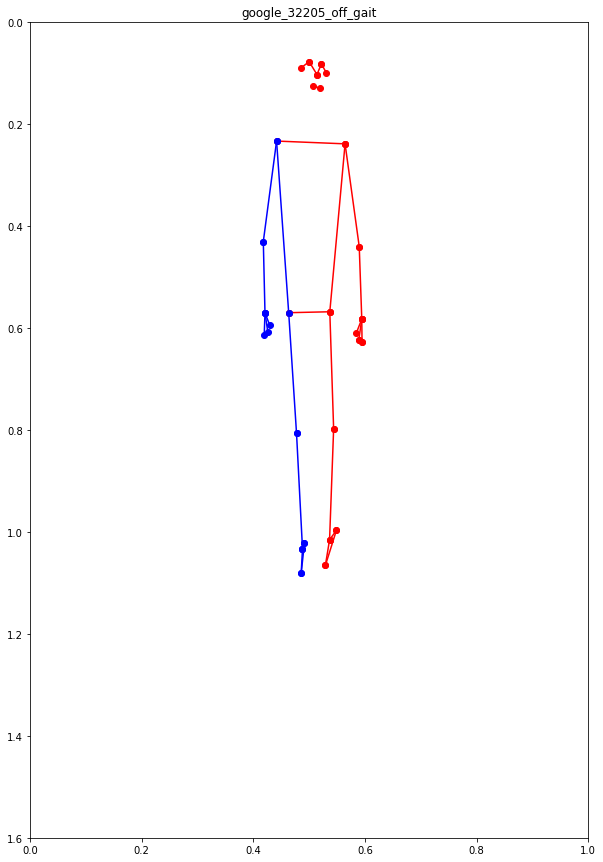

In [ ]:
anim = animate(poses[9].id, poses[9].new_pose2d, connections)

In [ ]:
anim.save('gait_animation.mp4', fps=33)

No handles with labels found to put in legend.


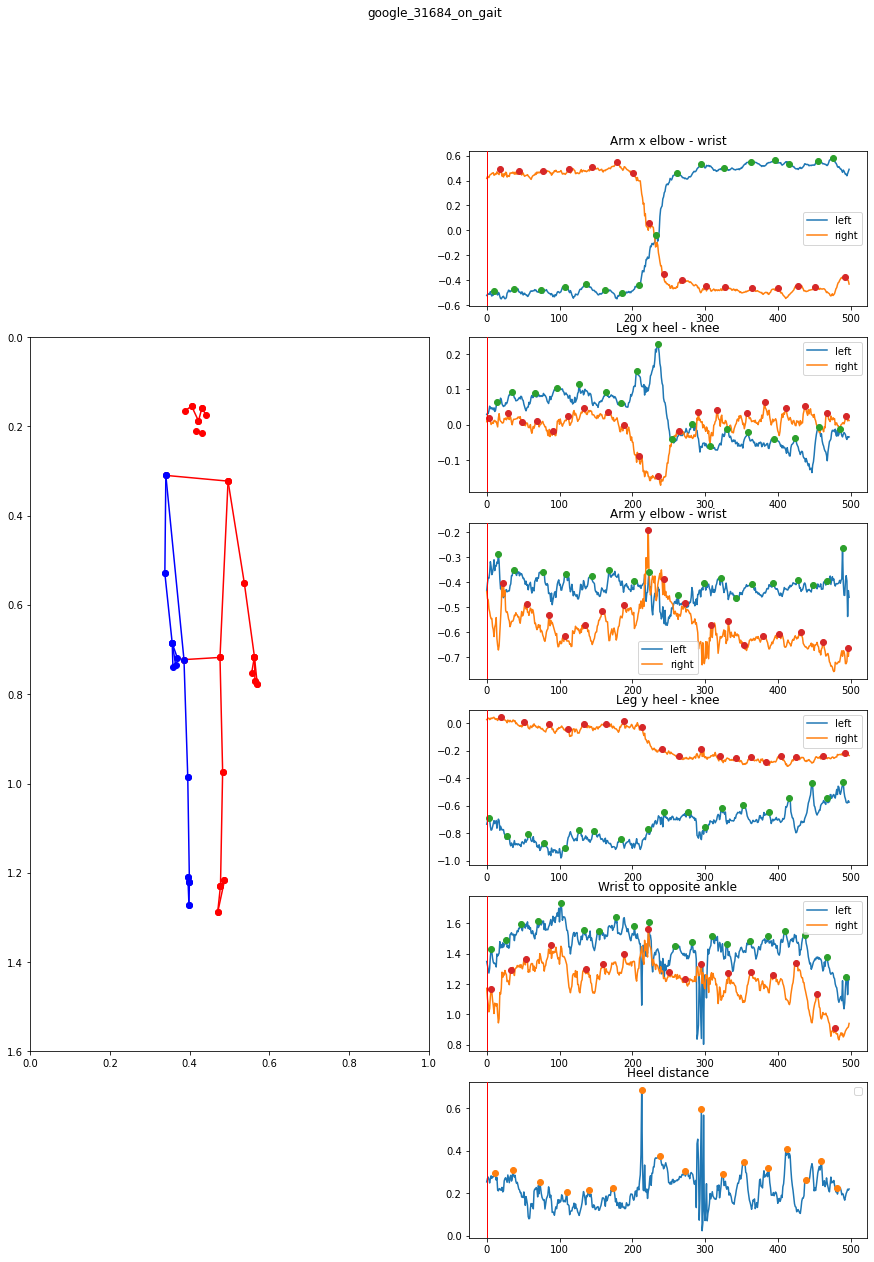

In [ ]:
p1 = {}
arm_leg_x = create_arm_leg_pair_x(poses[9])
arm_leg_y = create_arm_leg_pair_y(poses[9])
wrist_ankle = create_wrist_ankle_pair(poses[9])
heel_distance = create_heel_distance(poses[9])
metrics = [arm_leg_x, arm_leg_y, wrist_ankle, heel_distance]
for metric in metrics:
  for k in metric.keys():
    if k != "id":
      p1[k] = metric[k]
anim = animate_with_plot(poses[9].id, poses[9].new_pose2d, connections, p1)

In [ ]:
anim.save('gait_features.mp4', fps=33)

In [ ]:
id_to_idx = {}
for idx, pose in enumerate(poses):
    id = pose.id[7:12]
    if id in id_to_idx.keys():
        id_to_idx[id][pose.id.split('_')[-2]] = idx
    else:
        id_to_idx[id] = {pose.id.split('_')[-2]: idx}
keys = list(id_to_idx.keys())
for k in keys:
    if len(id_to_idx[k]) != 2:
        del id_to_idx[k]

print(id_to_idx)

{'32205': {'off': 0, 'on': 1}, '22423': {'on': 3, 'off': 9}, '32019': {'on': 4, 'off': 5}, '31937': {'on': 6, 'off': 11}, '31875': {'on': 7, 'off': 21}, '31876': {'off': 14, 'on': 19}, '20592': {'off': 16, 'on': 22}}


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


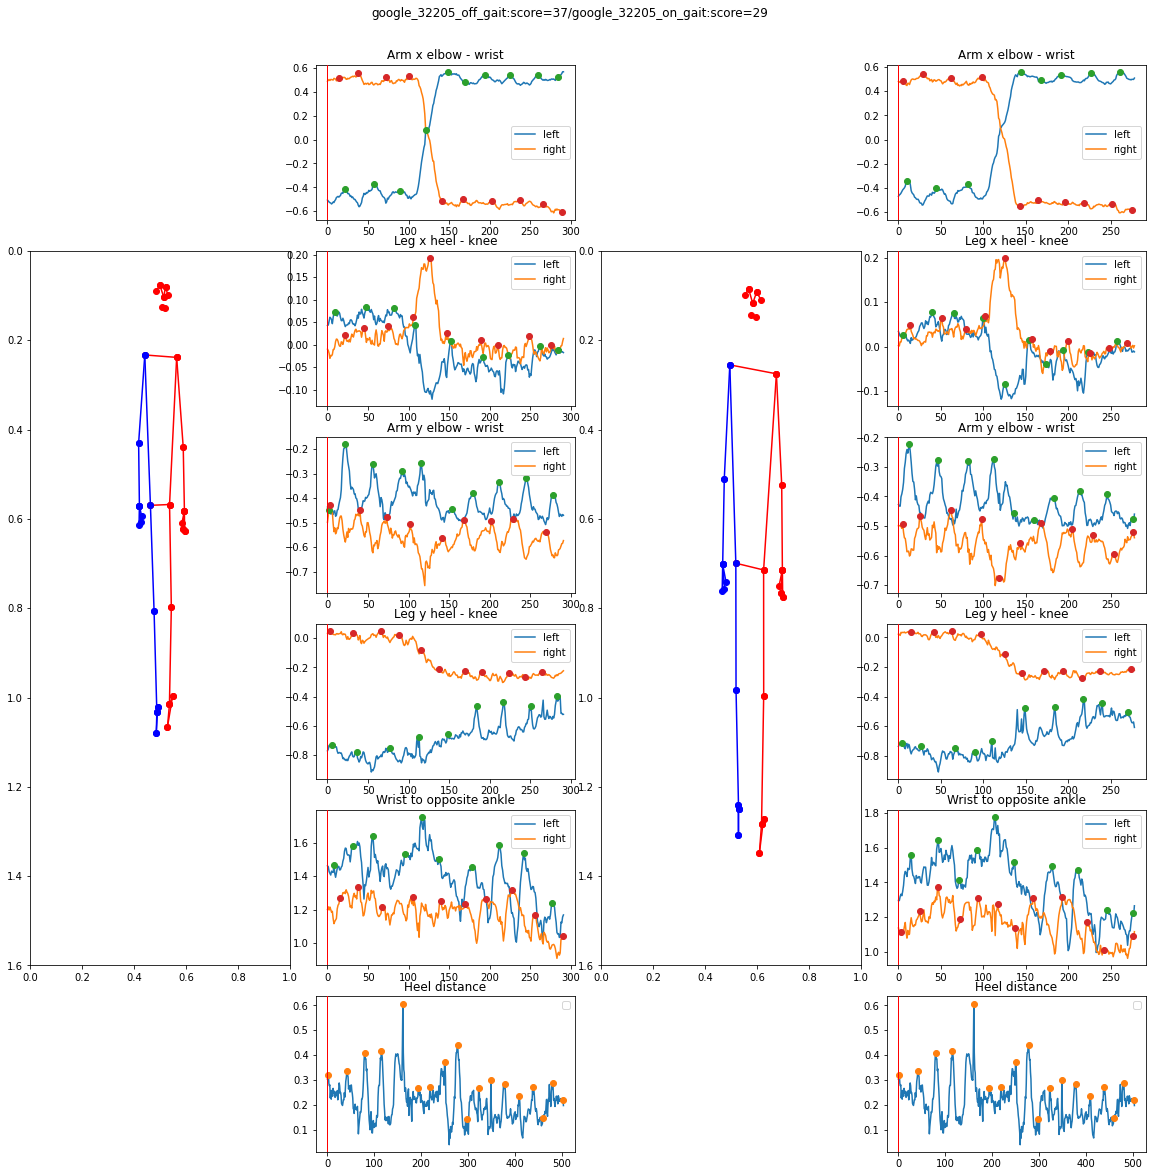

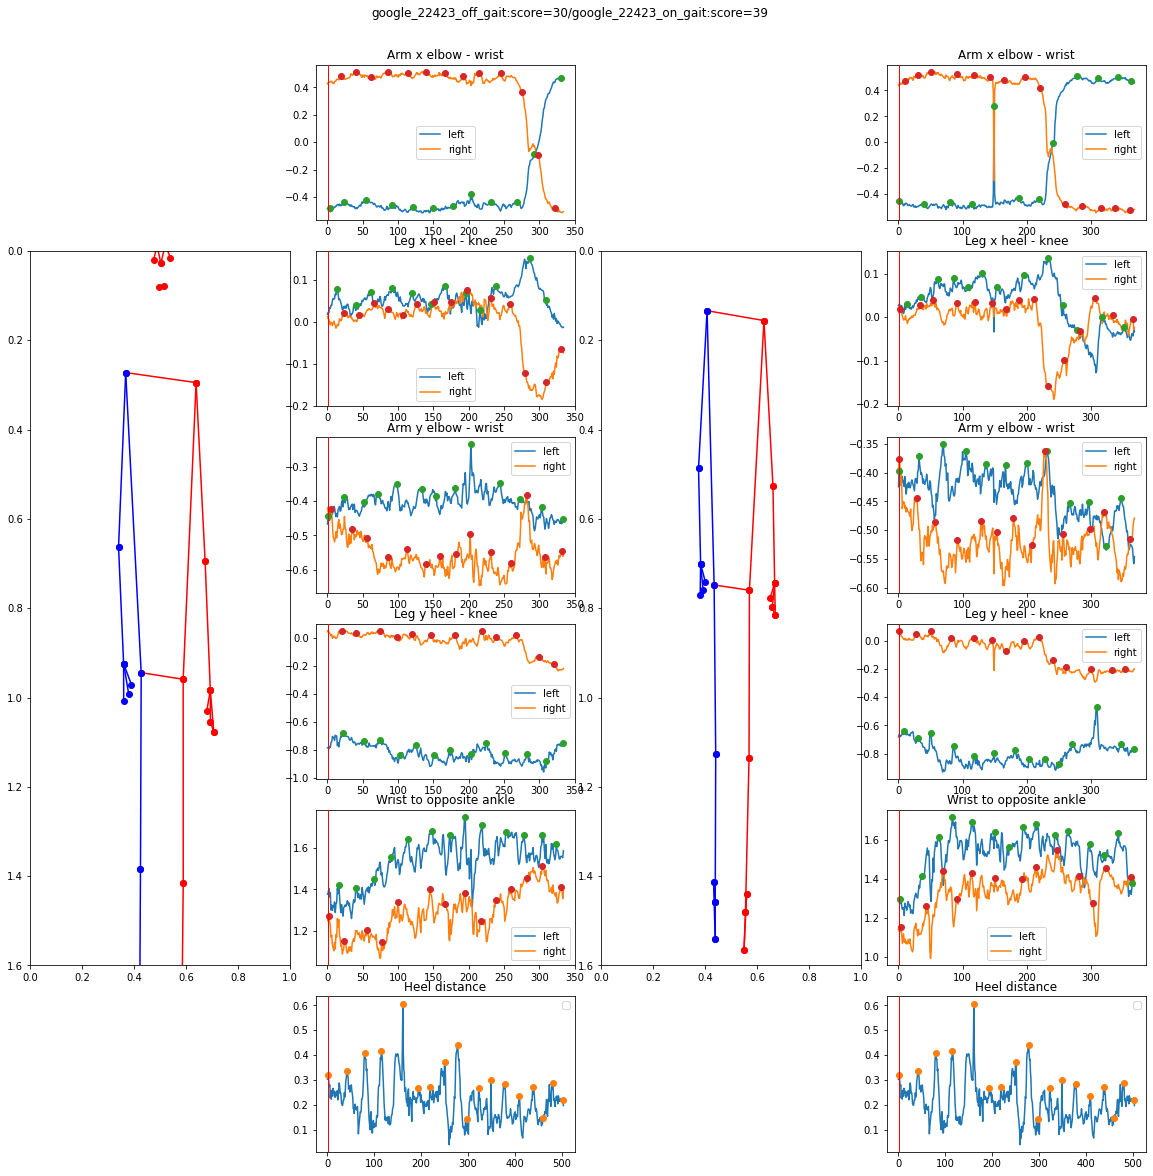

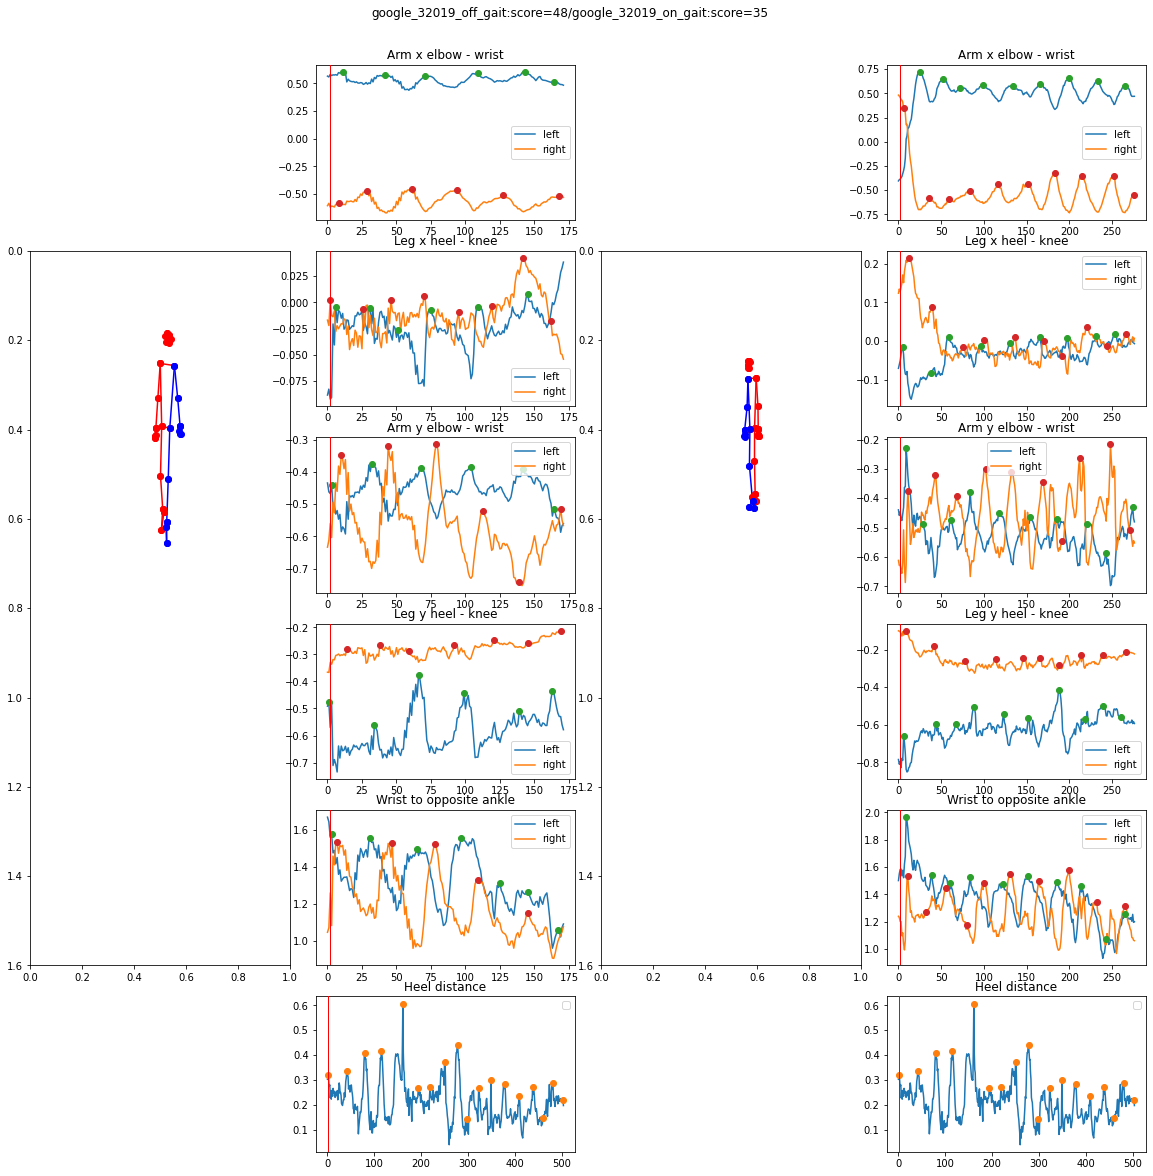

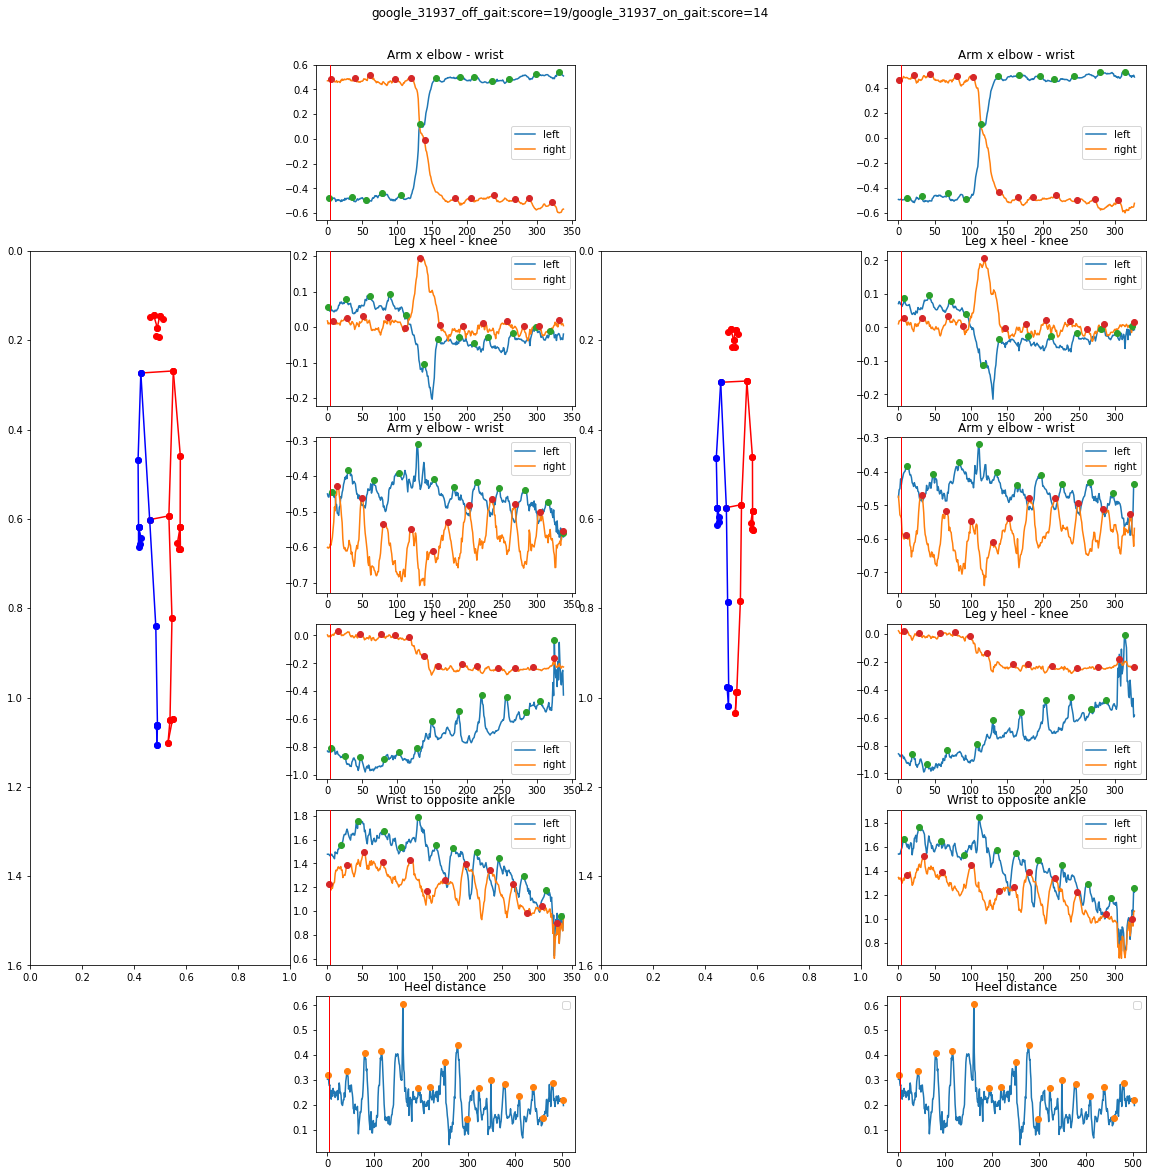

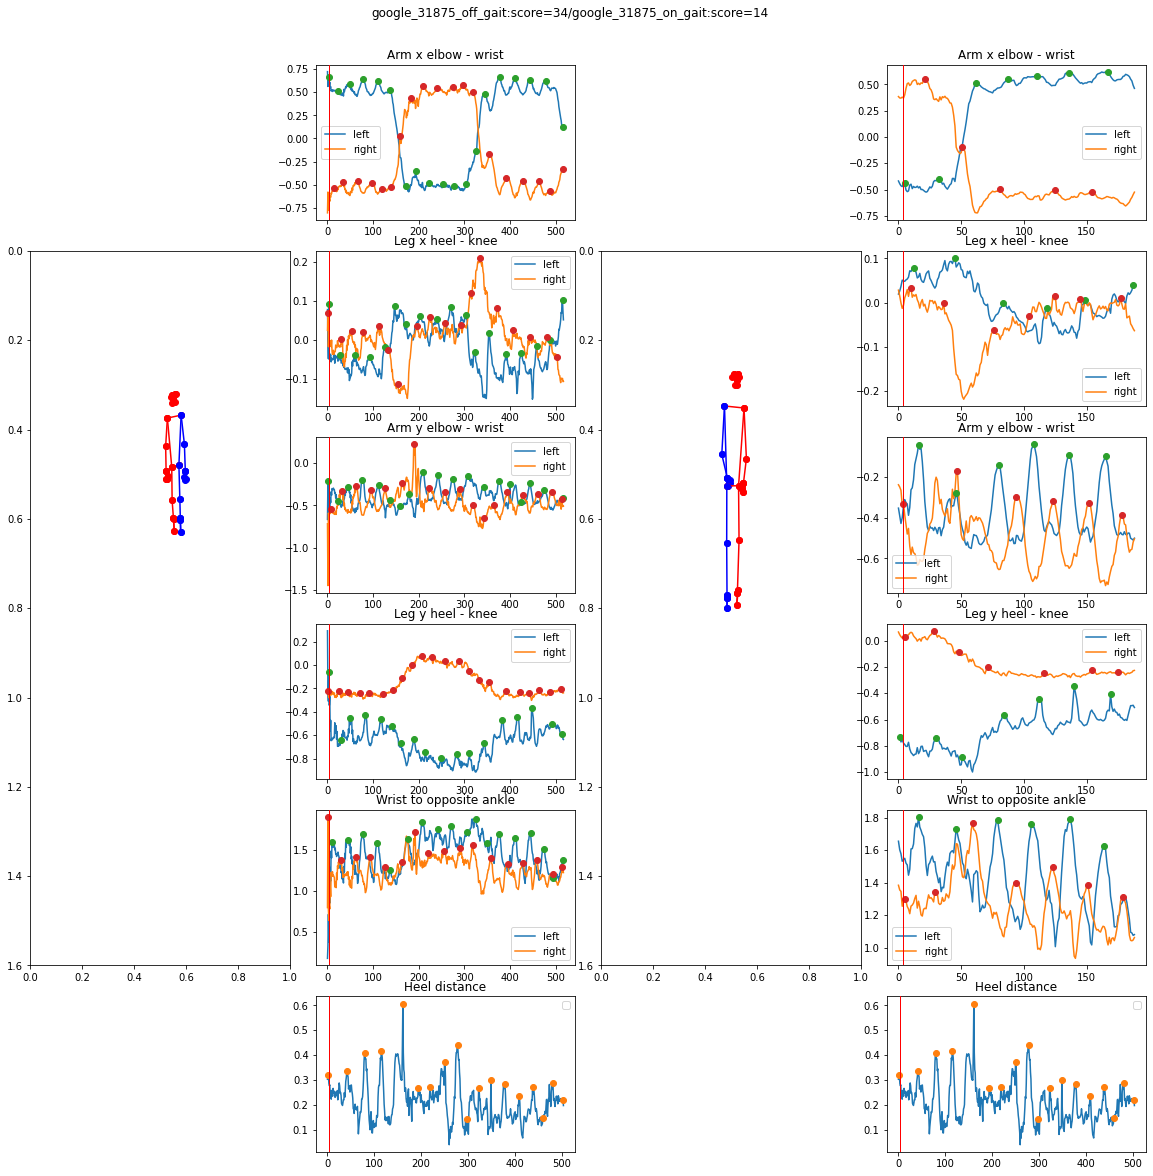

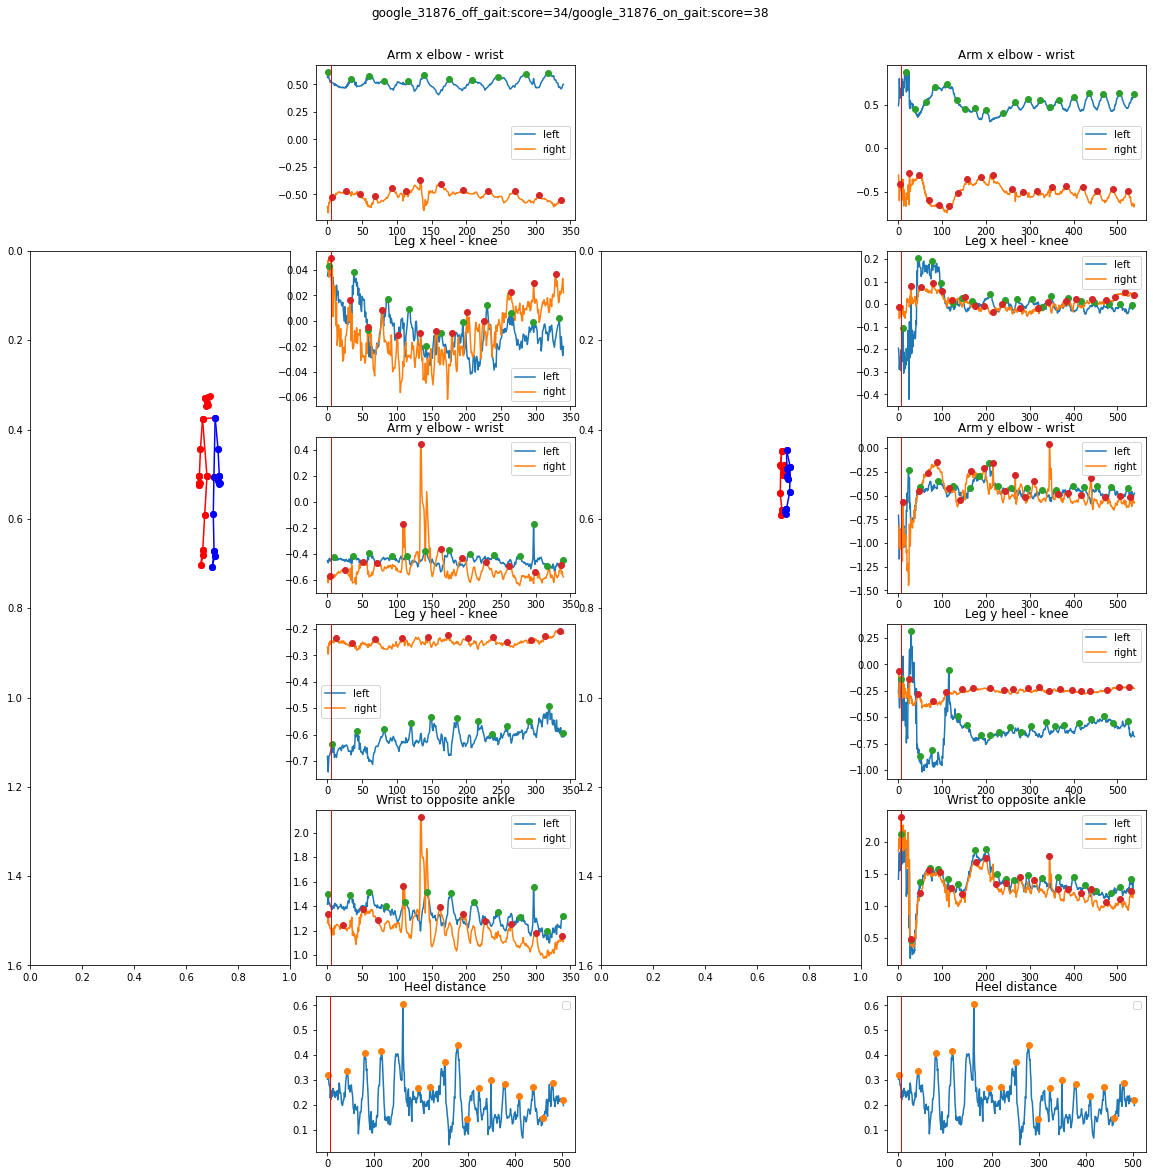

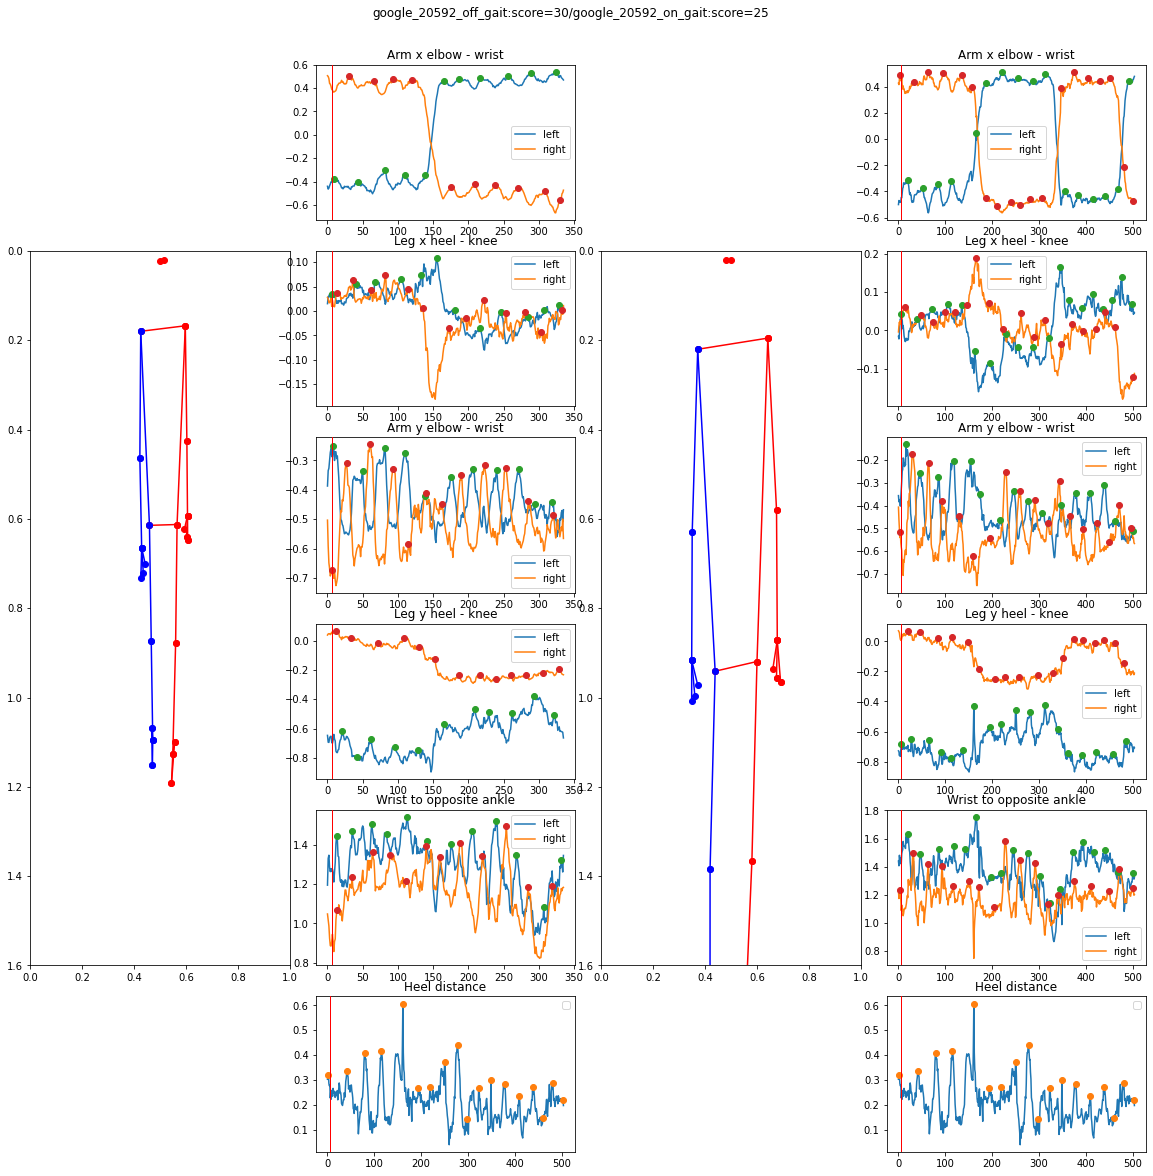

In [ ]:
pair_idxs = sum([[idx['off'], idx['on']] for idx in id_to_idx.values()], [])
paired_poses = [poses[i] for i in pair_idxs]
for i in range(len(pair_idxs) // 2):
  p1 = {}
  arm_leg_x = create_arm_leg_pair_x(paired_poses[2*i])
  arm_leg_y = create_arm_leg_pair_y(paired_poses[2*i])
  wrist_ankle = create_wrist_ankle_pair(paired_poses[2*i])
  heel_distance = create_heel_distance(paired_poses[2*i])
  metrics = [arm_leg_x, arm_leg_y, wrist_ankle, heel_distance]
  for metric in metrics:
    for k in metric.keys():
      if k != "id":
        p1[k] = metric[k]
  p2 = {}
  arm_leg_x = create_arm_leg_pair_x(paired_poses[2*i+1])
  arm_leg_y = create_arm_leg_pair_y(paired_poses[2*i+1])
  wrist_ankle = create_wrist_ankle_pair(paired_poses[2*i+1])
  heel_distance = create_heel_distance(paired_poses[2*i+1])
  metrics = [arm_leg_x, arm_leg_y, wrist_ankle, heel_distance]
  for metric in metrics:
    for k in metric.keys():
      if k != "id":
        p2[k] = metric[k]
  plot_pose2_static(paired_poses[2*i], p1, paired_poses[2*i+1], p2, '')

write google_32205_off_gait_google_32205_on_gait.mp4
write google_31937_off_gait_google_31937_on_gait.mp4


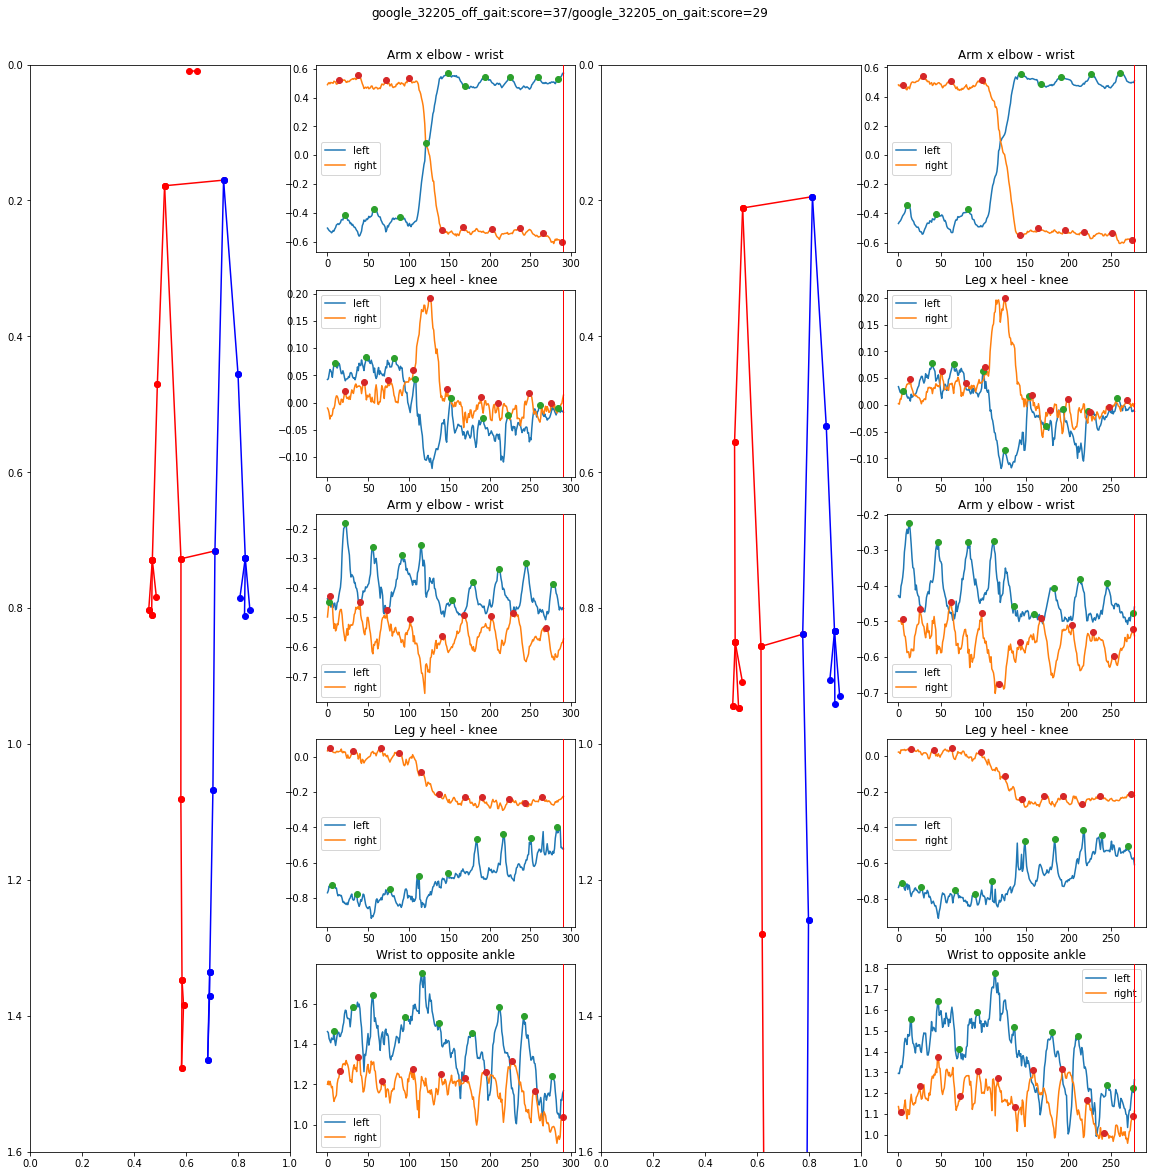

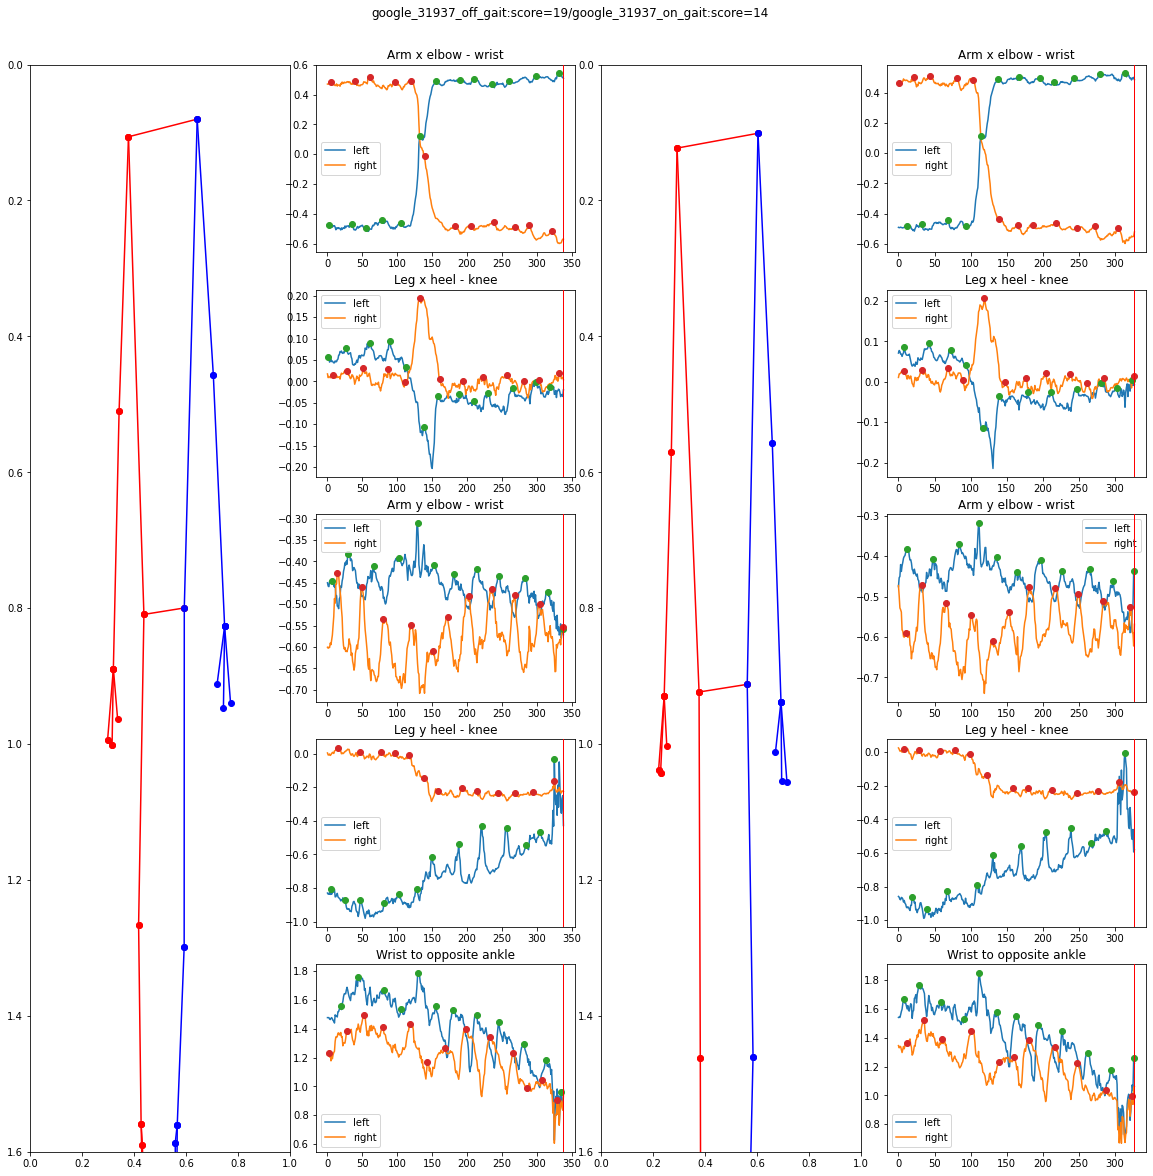

In [ ]:
pair_idxs = sum([[id_to_idx[key]['off'], id_to_idx[key]['on']] for key in ['32205', '31937']], [])
paired_poses = [poses[i] for i in pair_idxs]
for i in range(2):
  p1 = {}
  arm_leg_x = create_arm_leg_pair_x(paired_poses[2*i])
  arm_leg_y = create_arm_leg_pair_y(paired_poses[2*i])
  wrist_ankle = create_wrist_ankle_pair(paired_poses[2*i])
  metrics = [arm_leg_x, arm_leg_y, wrist_ankle]
  for metric in metrics:
    for k in metric.keys():
      if k != "id":
        p1[k] = metric[k]
  p2 = {}
  arm_leg_x = create_arm_leg_pair_x(paired_poses[2*i+1])
  arm_leg_y = create_arm_leg_pair_y(paired_poses[2*i+1])
  wrist_ankle = create_wrist_ankle_pair(paired_poses[2*i+1])
  metrics = [arm_leg_x, arm_leg_y, wrist_ankle]
  for metric in metrics:
    for k in metric.keys():
      if k != "id":
        p2[k] = metric[k]
  plot_pose2(paired_poses[2*i], p1, paired_poses[2*i+1], p2, '')

In [ ]:
#@title
def plot_arm_swing_range(pose, do_smooth=False):
  metrics0 = pose['Arm x elbow - wrist'][0][50:]
  metrics1 = pose['Arm x elbow - wrist'][1][70:]
  if do_smooth:
    metrics0 = scipy.signal.sosfilt(sos, metrics0)
    metrics1 = scipy.signal.sosfilt(sos, metrics1)
  peak0_h, _ = scipy.signal.find_peaks(metrics0, distance=20)
  peak0_l, _ = scipy.signal.find_peaks(-metrics0, distance=20)
  peak1_h, _ = scipy.signal.find_peaks(metrics1, distance=20)
  peak1_l, _ = scipy.signal.find_peaks(-metrics1, distance=20)
  fig, ax = plt.subplots(1, 3, figsize=(20, 5))
  ax[0].plot(metrics0, label='left')
  ax[0].plot(metrics1, label='right')
  ax[0].plot(peak0_h, metrics0[peak0_h], 'o')
  ax[0].plot(peak0_l, metrics0[peak0_l], 'o')
  ax[0].plot(peak1_h, metrics1[peak1_h], 'o')
  ax[0].plot(peak1_l, metrics1[peak1_l], 'o')
  peak0_len = min(len(peak0_h), len(peak0_l))
  peak1_len = min(len(peak1_h), len(peak1_l))
  peak_len = min(peak0_len, peak1_len)
  val_delta0 = (metrics0[peak0_h[:peak_len]] - metrics1[peak0_l[:peak_len]])
  val_delta1 = (metrics1[peak1_h[:peak_len]] - metrics1[peak1_l[:peak_len]])
  delta = np.abs(np.abs(val_delta0) - np.abs(val_delta1))
  ax[1].plot(val_delta0, 'o', label='left')
  ax[1].plot(val_delta1, 'o', label='right')
  ax[2].plot(delta, 'o-')
  ax[0].set_title('Aligned ' + pose['id'] + ' ARM swing')
  ax[1].set_title('Aligned ' + pose['id'] + ' ARM swing range')
  ax[2].set_title('Aligned ' + pose['id'] + ' LEFT/RIGHT delta')
  ax[0].set_xlabel('frame')
  ax[1].set_xlabel('swing number')
  ax[0].legend()
  ax[1].legend()

def plot_arm_swing_spec(pose):
  metrics0 = pose['Arm y elbow - wrist'][0]
  metrics1 = pose['Arm y elbow - wrist'][1]
  peak0_h, _ = scipy.signal.find_peaks(metrics0, distance=20)
  peak0_l, _ = scipy.signal.find_peaks(-metrics0, distance=20)
  peak1_h, _ = scipy.signal.find_peaks(metrics1, distance=20)
  peak1_l, _ = scipy.signal.find_peaks(-metrics1, distance=20)
  fig, ax = plt.subplots(1, 3, figsize=(20, 5))
  ax[0].plot(metrics0, label='left')
  ax[0].plot(metrics1, label='right')
  ax[0].plot(peak0_h, metrics0[peak0_h], 'o')
  ax[0].plot(peak0_l, metrics0[peak0_l], 'o')
  ax[0].plot(peak1_h, metrics1[peak1_h], 'o')
  ax[0].plot(peak1_l, metrics1[peak1_l], 'o')
  _, _, spec0 = scipy.signal.spectrogram(metrics0, nperseg=128, noverlap=120)
  _, _, spec1 = scipy.signal.spectrogram(metrics1, nperseg=128, noverlap=120)
  ax[1].imshow((spec0[:20,:]), aspect='auto')
  ax[2].imshow((spec1[:20,:]), aspect='auto')
  ax[0].set_title(pose['id'] + ' ARM swing')
  ax[0].set_xlabel('frame')
  ax[1].set_xlabel('swing number')
  ax[0].legend()
  ax[1].legend()

def get_arm_swing_delta(arm_sw):
  metrics0 = arm_sw['Arm y elbow - wrist'][0]
  metrics1 = arm_sw['Arm y elbow - wrist'][1]
  peak0_h, _ = scipy.signal.find_peaks(metrics0, distance=20)
  peak0_l, _ = scipy.signal.find_peaks(-metrics0, distance=20)
  peak1_h, _ = scipy.signal.find_peaks(metrics1, distance=20)
  peak1_l, _ = scipy.signal.find_peaks(-metrics1, distance=20)
  peak0_len = min(len(peak0_h), len(peak0_l))
  peak1_len = min(len(peak1_h), len(peak1_l))
  peak_len = min(peak0_len, peak1_len)
  val_delta0 = metrics0[peak0_h[:peak_len]] - metrics1[peak0_l[:peak_len]]
  val_delta1 = metrics1[peak1_h[:peak_len]] - metrics1[peak1_l[:peak_len]]
  return val_delta0 - val_delta1


W1026 05:46:38.414409 66 warnings.py:110] /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':

W1026 05:46:38.453685 66 warnings.py:110] /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':

W1026 05:46:38.494296 66 warnings.py:110] /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot i

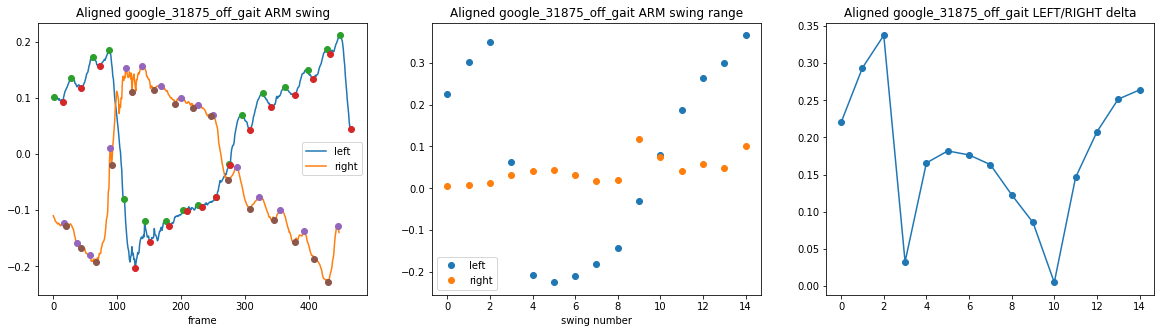

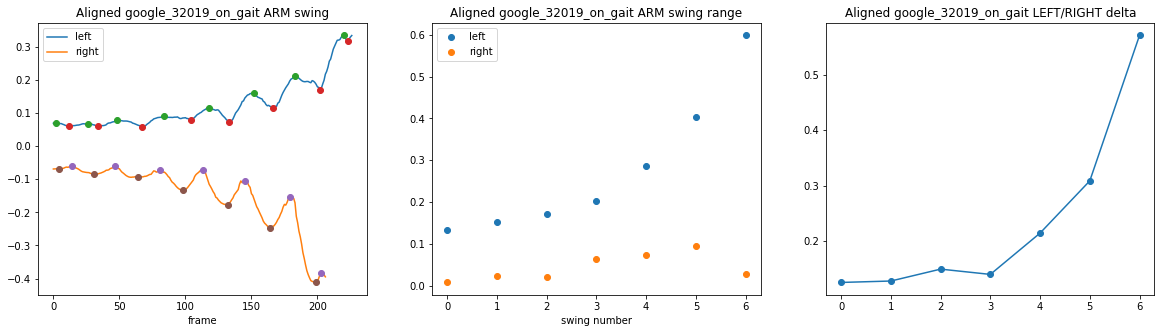

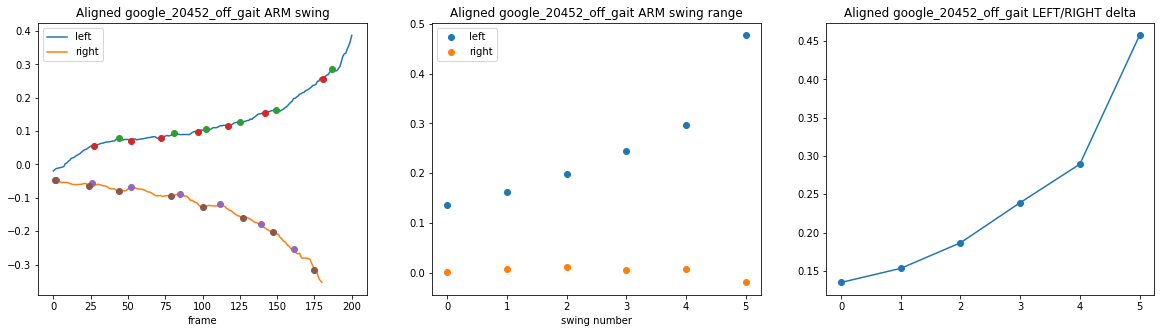

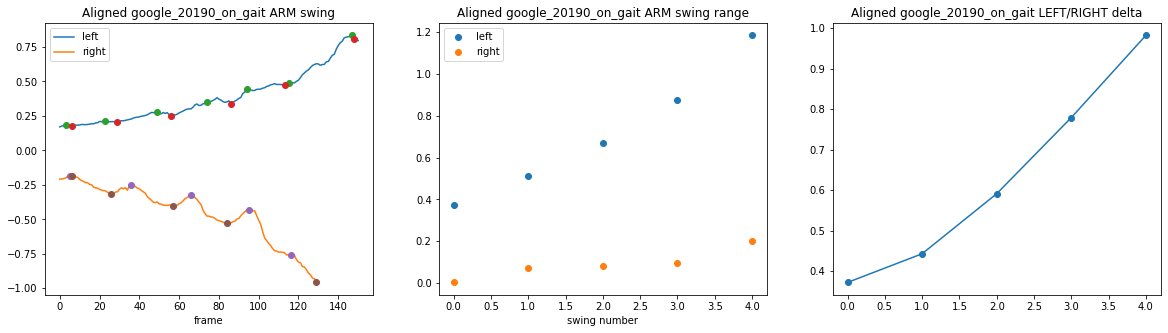

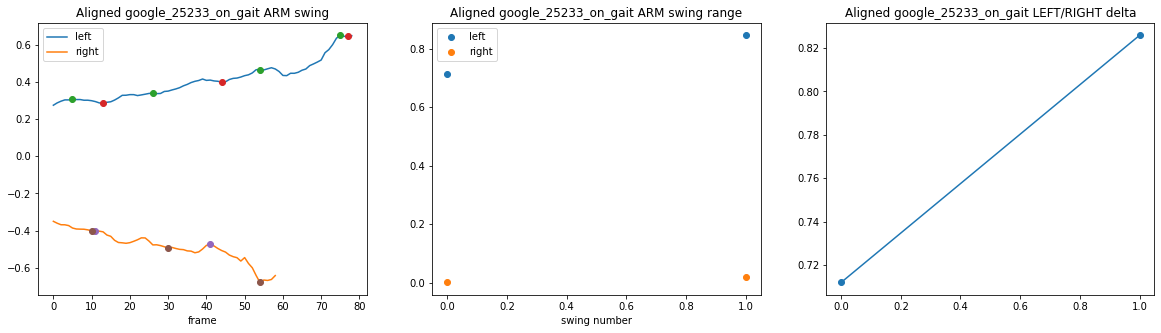

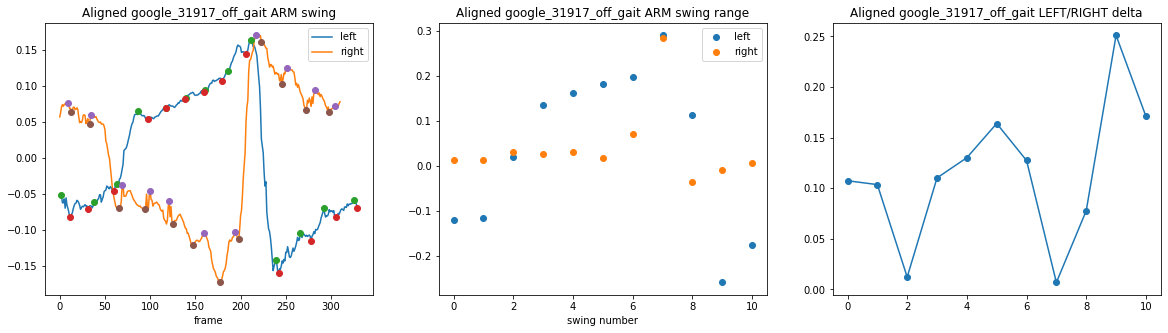

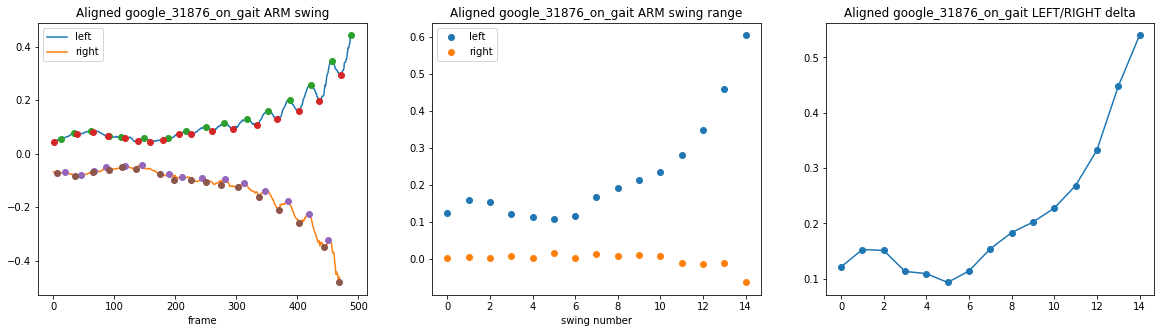

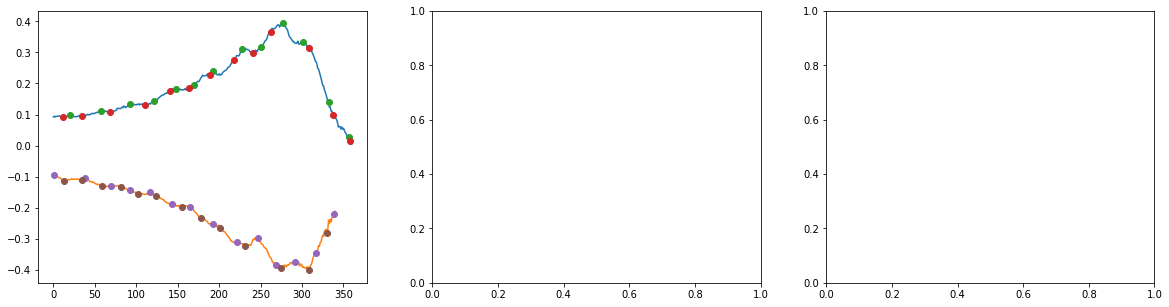

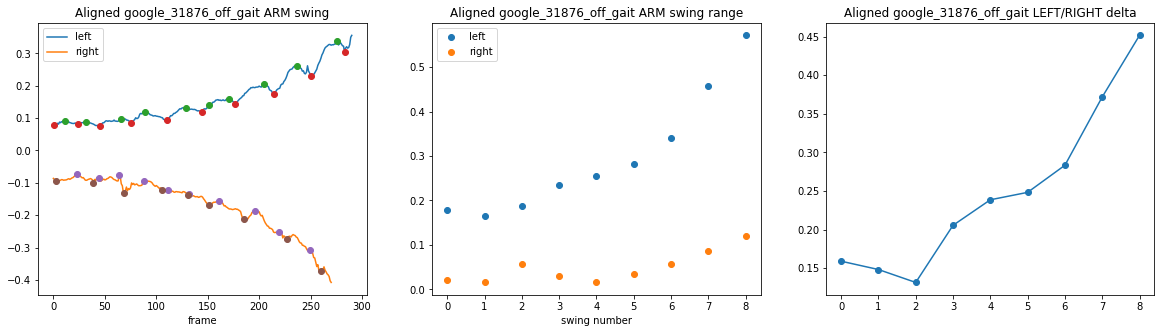

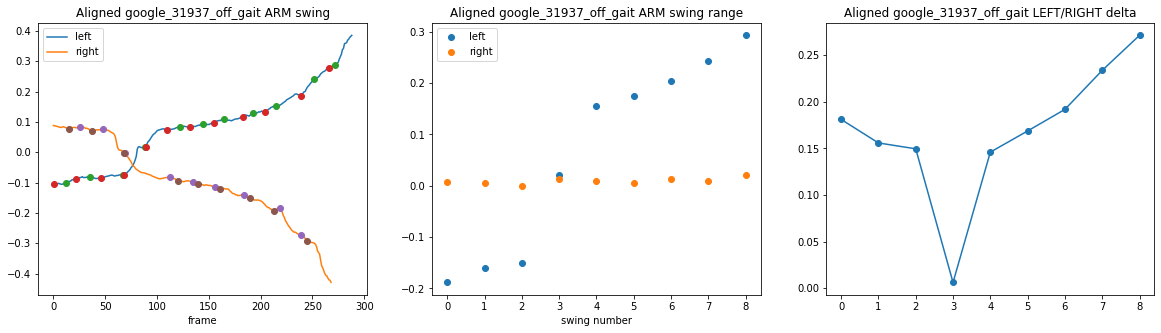

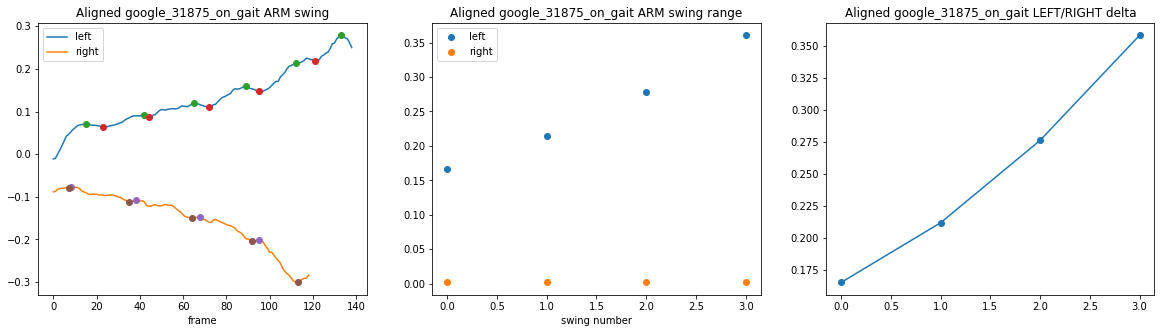

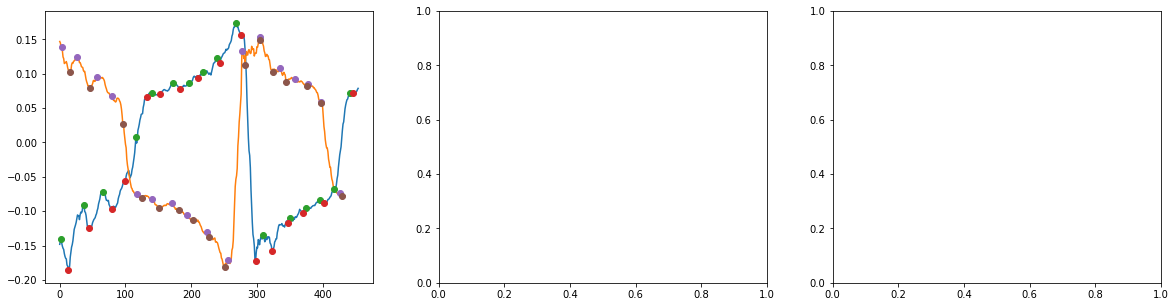

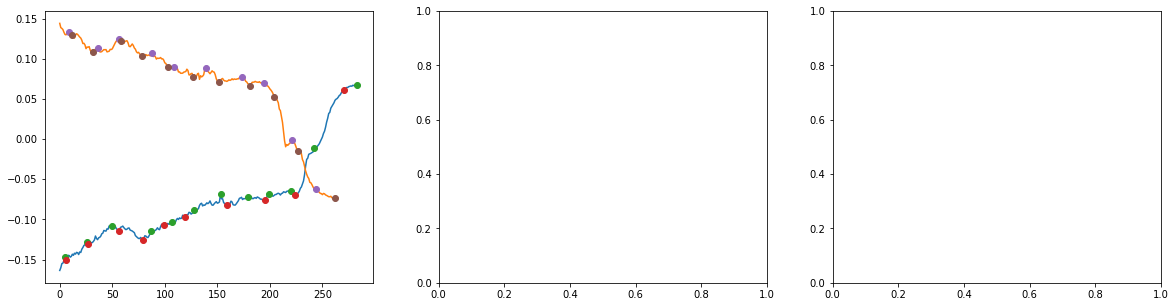

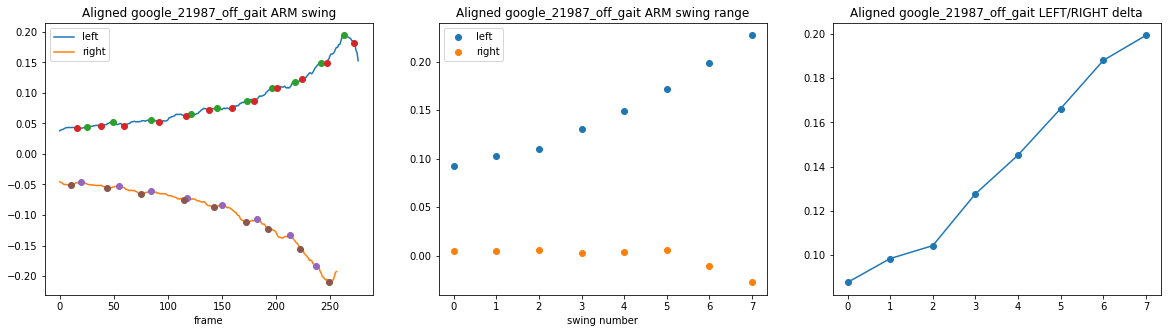

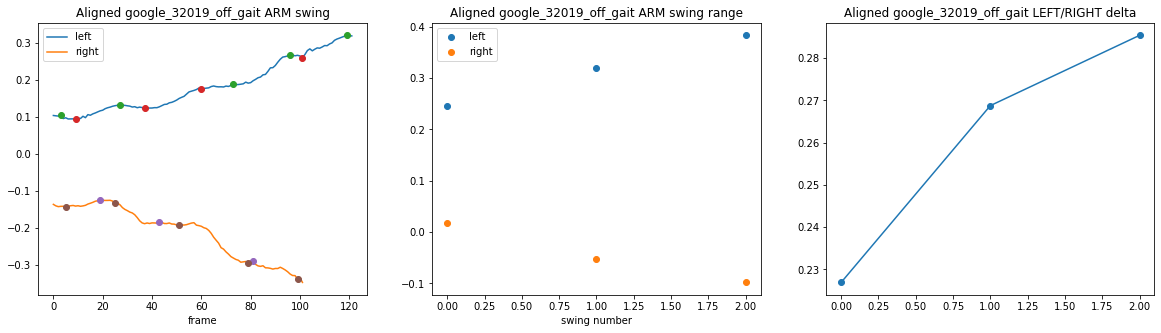

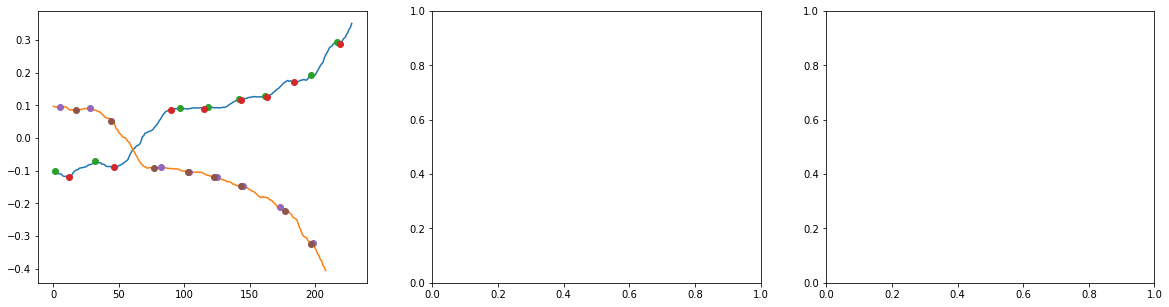

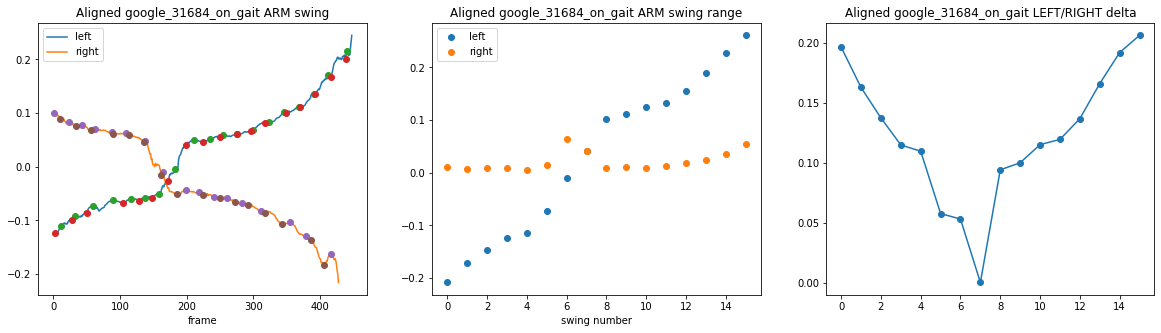

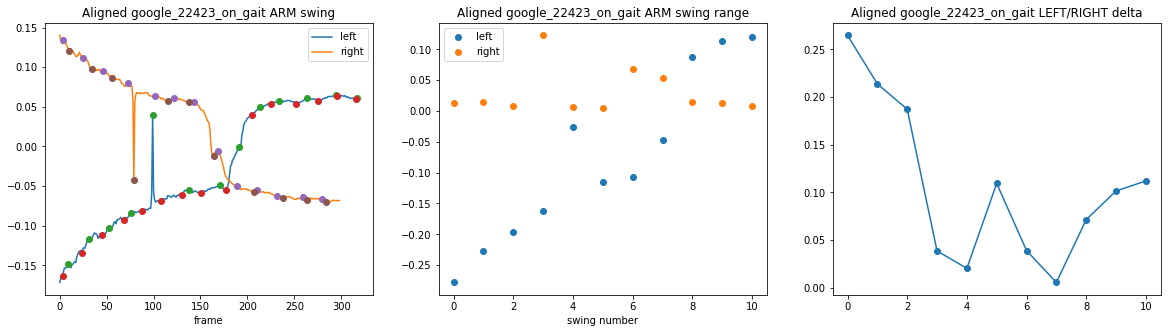

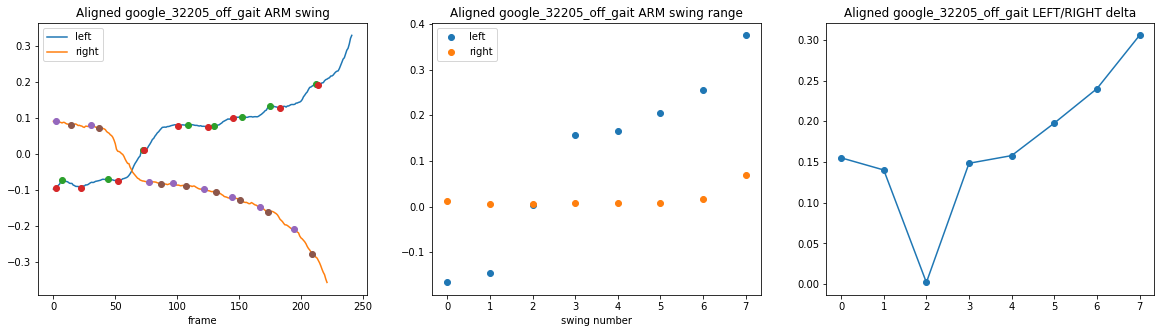

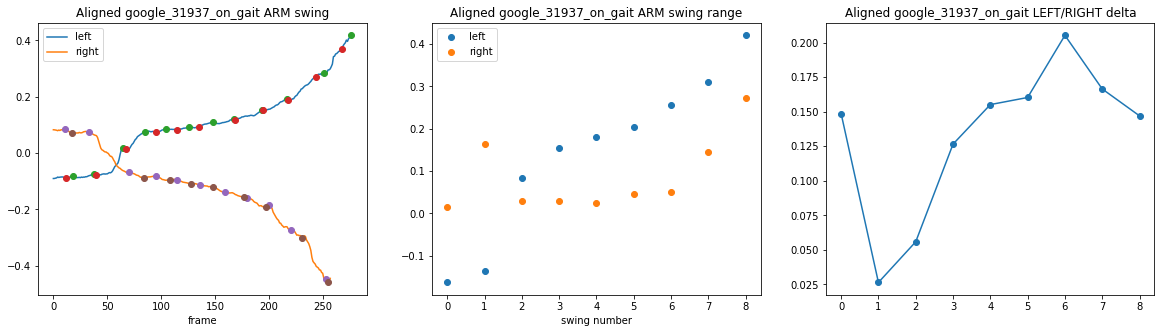

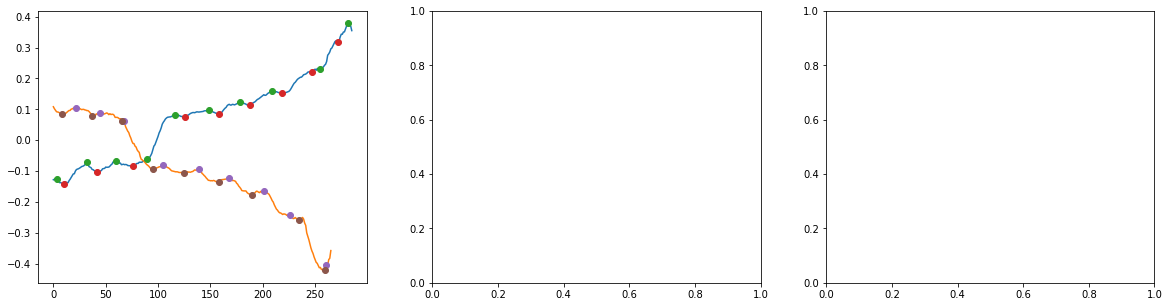

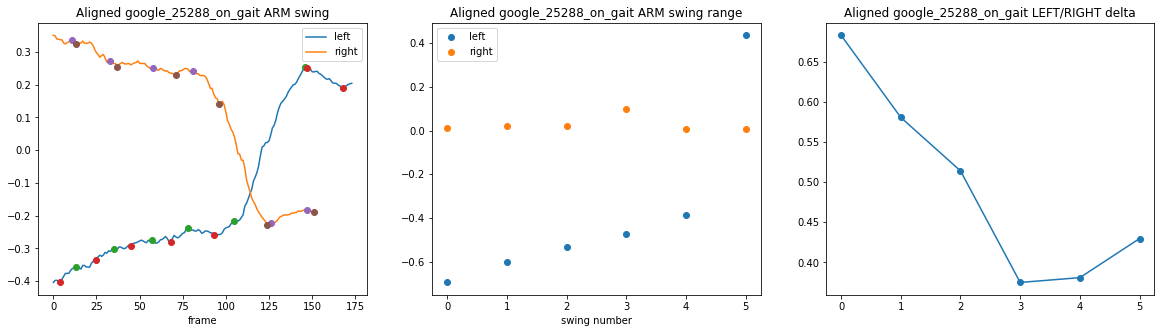

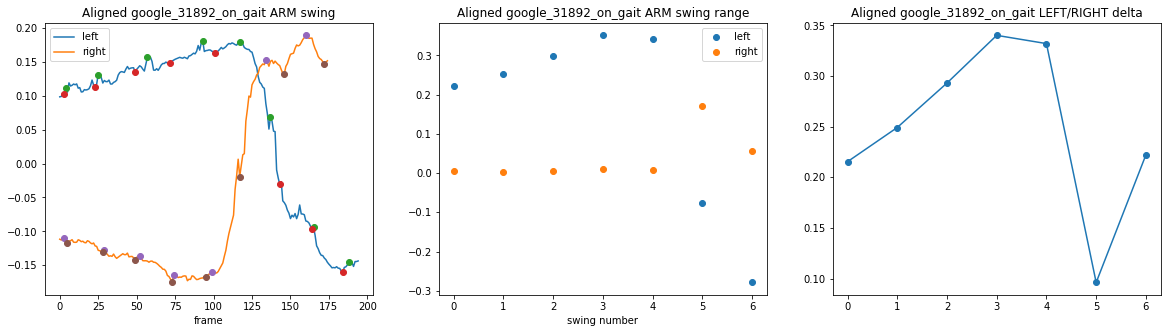

In [ ]:
# poses[0].id = 'OFF'
# poses[1].id = 'ON'
for pose in poses:
  try:
    arm_sw = create_arm_leg_pair_x(pose)
    plot_arm_swing_range(arm_sw)
  except:
    continue

In [ ]:
poff = create_arm_leg_pair_x(poses[20])
pon = create_arm_leg_pair_x(poses[11])

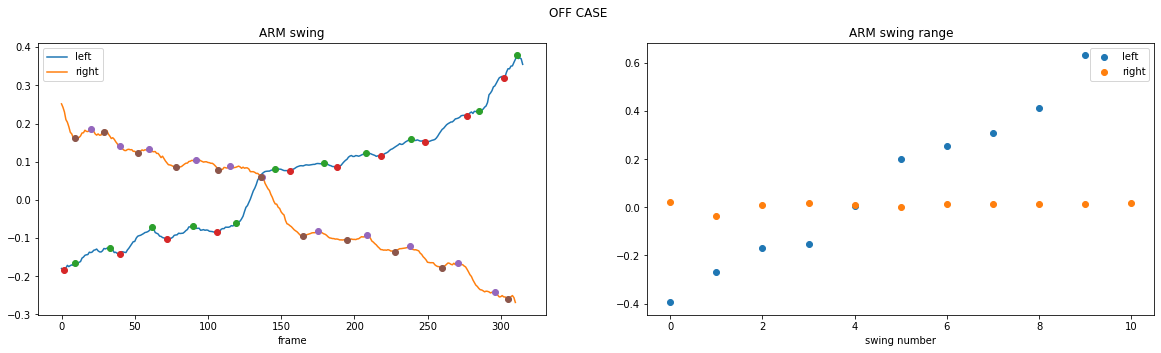

In [ ]:
metrics0 = poff['Arm x elbow - wrist'][0][20:]
metrics1 = poff['Arm x elbow - wrist'][1][:-25]
peak0_h, _ = scipy.signal.find_peaks(metrics0, distance=20)
peak0_l, _ = scipy.signal.find_peaks(-metrics0, distance=20)
peak1_h, _ = scipy.signal.find_peaks(metrics1, distance=20)
peak1_l, _ = scipy.signal.find_peaks(-metrics1, distance=20)
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(metrics0, label='left')
ax[0].plot(metrics1, label='right')
ax[0].plot(peak0_h, metrics0[peak0_h], 'o')
ax[0].plot(peak0_l, metrics0[peak0_l], 'o')
ax[0].plot(peak1_h, metrics1[peak1_h], 'o')
ax[0].plot(peak1_l, metrics1[peak1_l], 'o')
val_delta0 = metrics0[peak0_h][[i for i in range(len(peak0_h)) if i != 5]] - metrics1[peak0_l]
val_delta1 = metrics1[peak1_h] - metrics1[peak1_l]
ax[1].plot(val_delta0, 'o', label='left')
ax[1].plot(val_delta1, 'o', label='right')
ax[0].set_title('ARM swing')
ax[1].set_title('ARM swing range')
ax[0].set_xlabel('frame')
ax[1].set_xlabel('swing number')
ax[0].legend()
ax[1].legend()
plt.suptitle('OFF CASE')
_ = '''peak0 = sorted(peak0_h.tolist() + peak0_l.tolist())
peak1 = sorted(peak1_h.tolist() + peak1_l.tolist())
tm_delta0 = np.diff(peak0) * 0.03
tm_delta1 = np.diff(peak1) * 0.03
ax[2].plot(tm_delta0, 'o-')
ax[2].plot(tm_delta1, 'o-')'''

Text(0.5, 0.98, 'ON CASE')

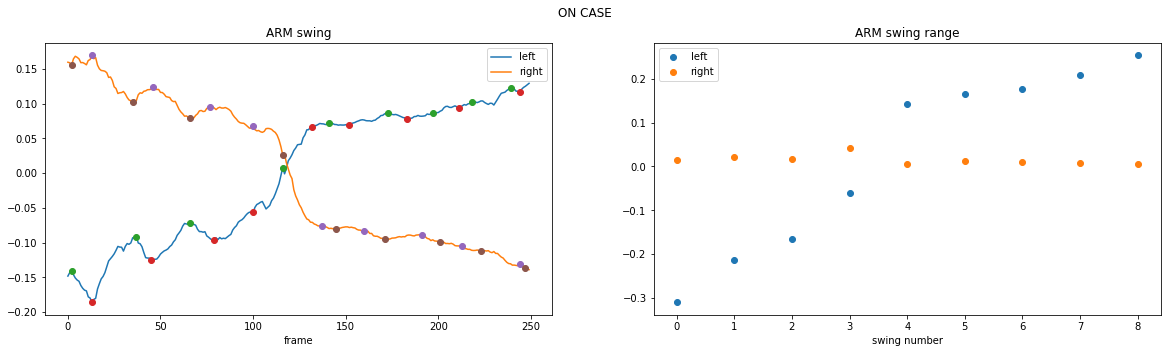

In [ ]:
metrics0 = pon['Arm x elbow - wrist'][0][50:300]
metrics1 = pon['Arm x elbow - wrist'][1][50:300]
peak0_h, _ = scipy.signal.find_peaks(metrics0, distance=20)
peak0_l, _ = scipy.signal.find_peaks(-metrics0, distance=20)
peak1_h, _ = scipy.signal.find_peaks(metrics1, distance=20)
peak1_l = peak1_l[:-1]
peak1_l, _ = scipy.signal.find_peaks(-metrics1, distance=20)
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(metrics0, label='left')
ax[0].plot(metrics1, label='right')
ax[0].plot(peak0_h, metrics0[peak0_h], 'o')
ax[0].plot(peak0_l, metrics0[peak0_l], 'o')
ax[0].plot(peak1_h, metrics1[peak1_h], 'o')
ax[0].plot(peak1_l, metrics1[peak1_l], 'o')
val_delta0 = metrics0[peak0_h] - metrics1[peak0_l]
val_delta1 = metrics1[peak1_h] - metrics1[peak1_l]
ax[1].plot(val_delta0, 'o', label='left')
ax[1].plot(val_delta1, 'o', label='right')
ax[0].set_title('ARM swing')
ax[1].set_title('ARM swing range')
ax[0].set_xlabel('frame')
ax[1].set_xlabel('swing number')
ax[0].legend()
ax[1].legend()
plt.suptitle('ON CASE')

In [ ]:
len(peak1_h), len(peak1_l)

(8, 8)

I1026 06:47:33.162891 66 animation.py:1112] Animation.save using <class 'matplotlib.animation.HTMLWriter'>


write google_31876_off_gait_google_31876_on_gait.angle.html


I1026 06:52:51.269994 66 animation.py:1112] Animation.save using <class 'matplotlib.animation.HTMLWriter'>


write google_31875_off_gait_google_31875_on_gait.angle.html


I1026 06:57:52.171250 66 animation.py:1112] Animation.save using <class 'matplotlib.animation.HTMLWriter'>


write google_32019_off_gait_google_32019_on_gait.angle.html


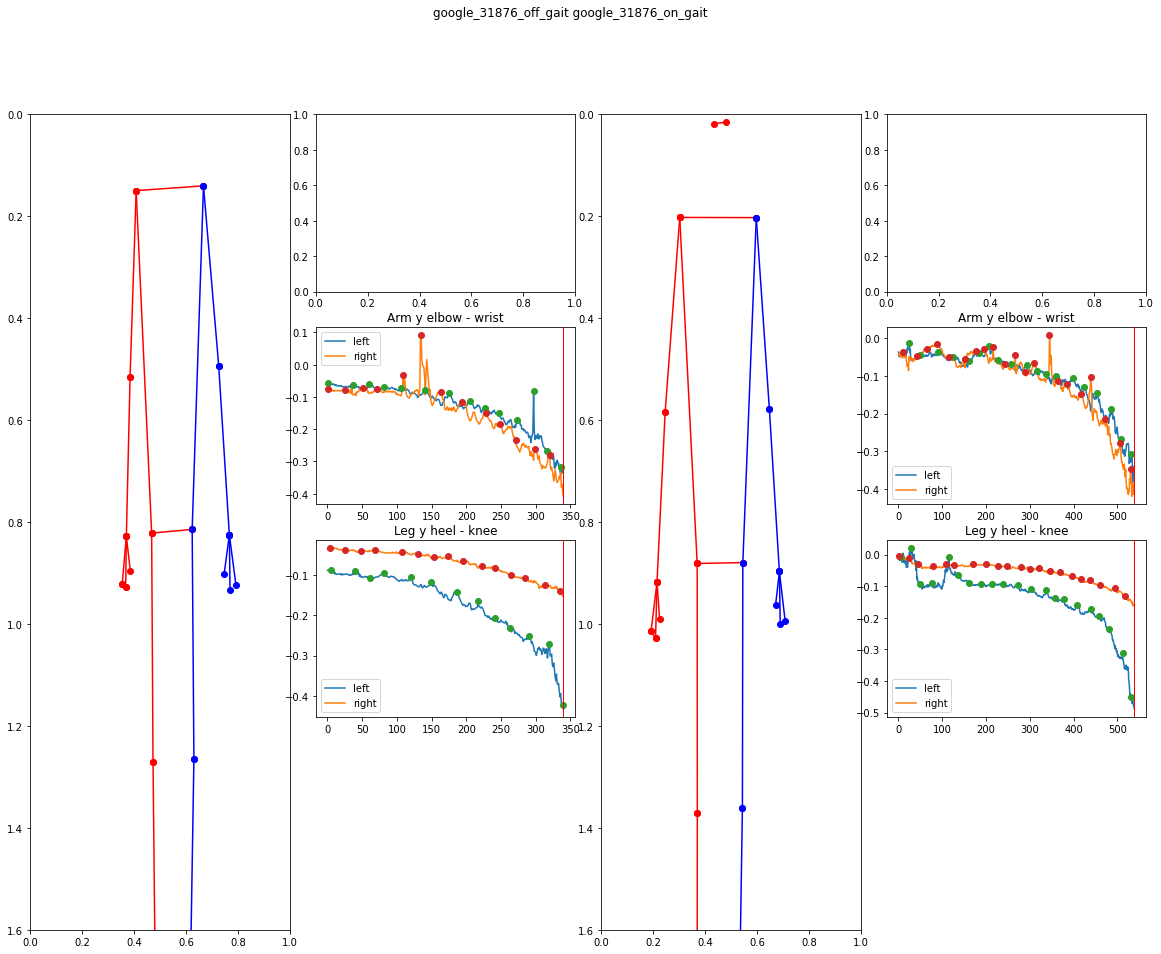

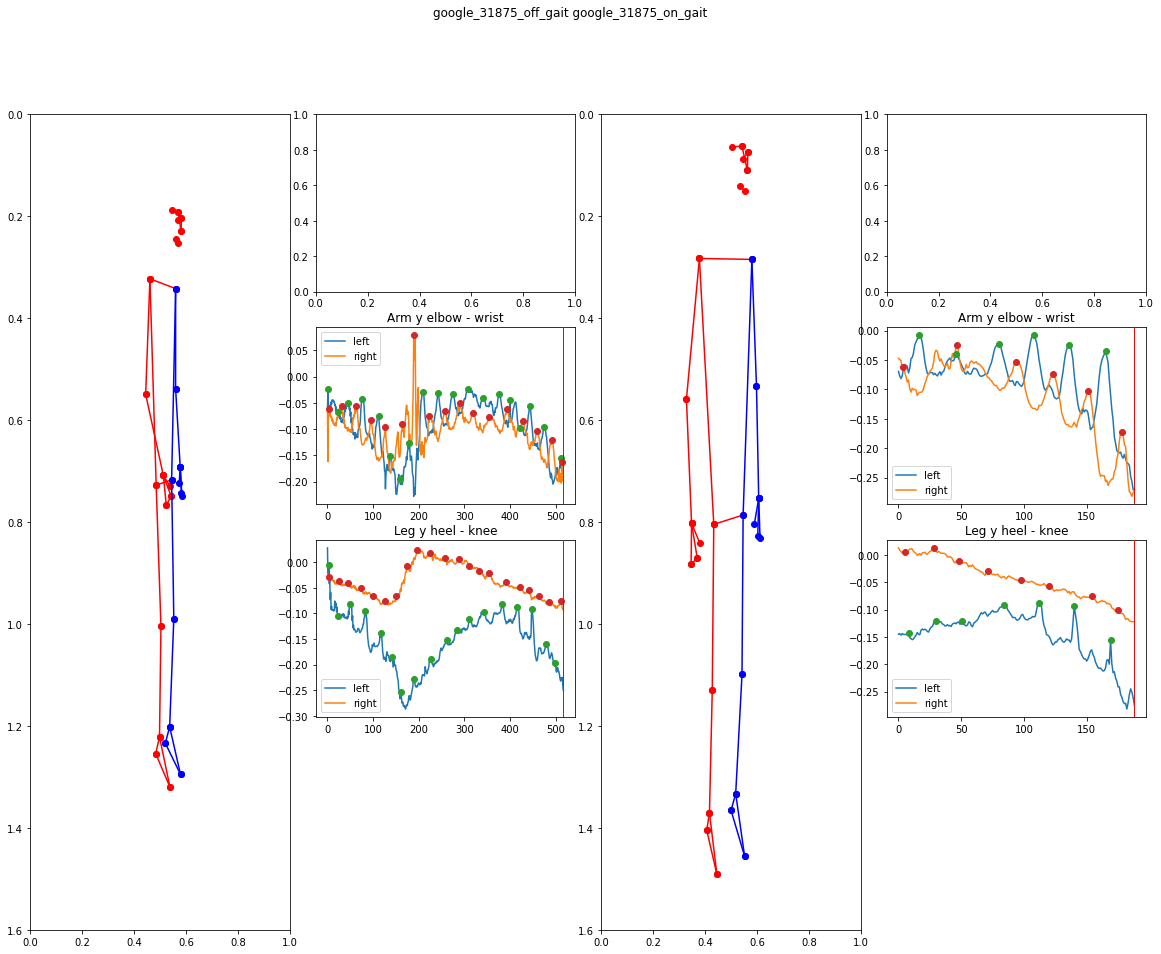

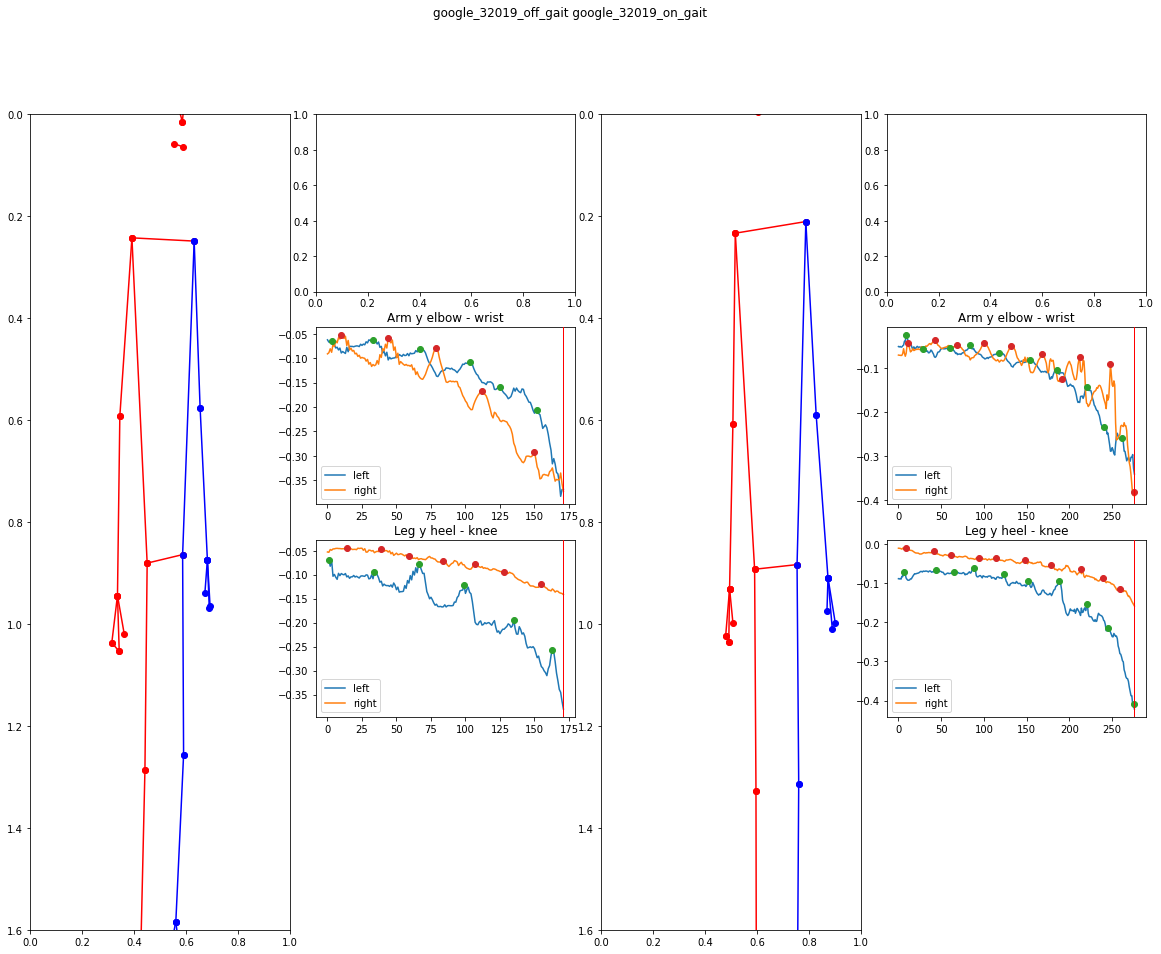

In [ ]:
pair_idxs = [8, 6, 0, 10, 14, 1, 12, 17, 18, 15, 9, 19, 20, 11]
paired_poses = [poses[i] for i in pair_idxs]
for i in range(3):
  p1 = create_arm_leg_pair_y(paired_poses[2*i])
  p2 = create_arm_leg_pair_y(paired_poses[2*i+1])
  plot_pose2(paired_poses[2*i], p1, paired_poses[2*i+1], p2, '')

I1026 07:07:53.921044 66 animation.py:1112] Animation.save using <class 'matplotlib.animation.HTMLWriter'>


write google_31876_off_gait_google_31876_on_gait.angle.html


I1026 07:13:08.655576 66 animation.py:1112] Animation.save using <class 'matplotlib.animation.HTMLWriter'>


write google_31875_off_gait_google_31875_on_gait.angle.html


I1026 07:18:06.021032 66 animation.py:1112] Animation.save using <class 'matplotlib.animation.HTMLWriter'>


write google_32019_off_gait_google_32019_on_gait.angle.html


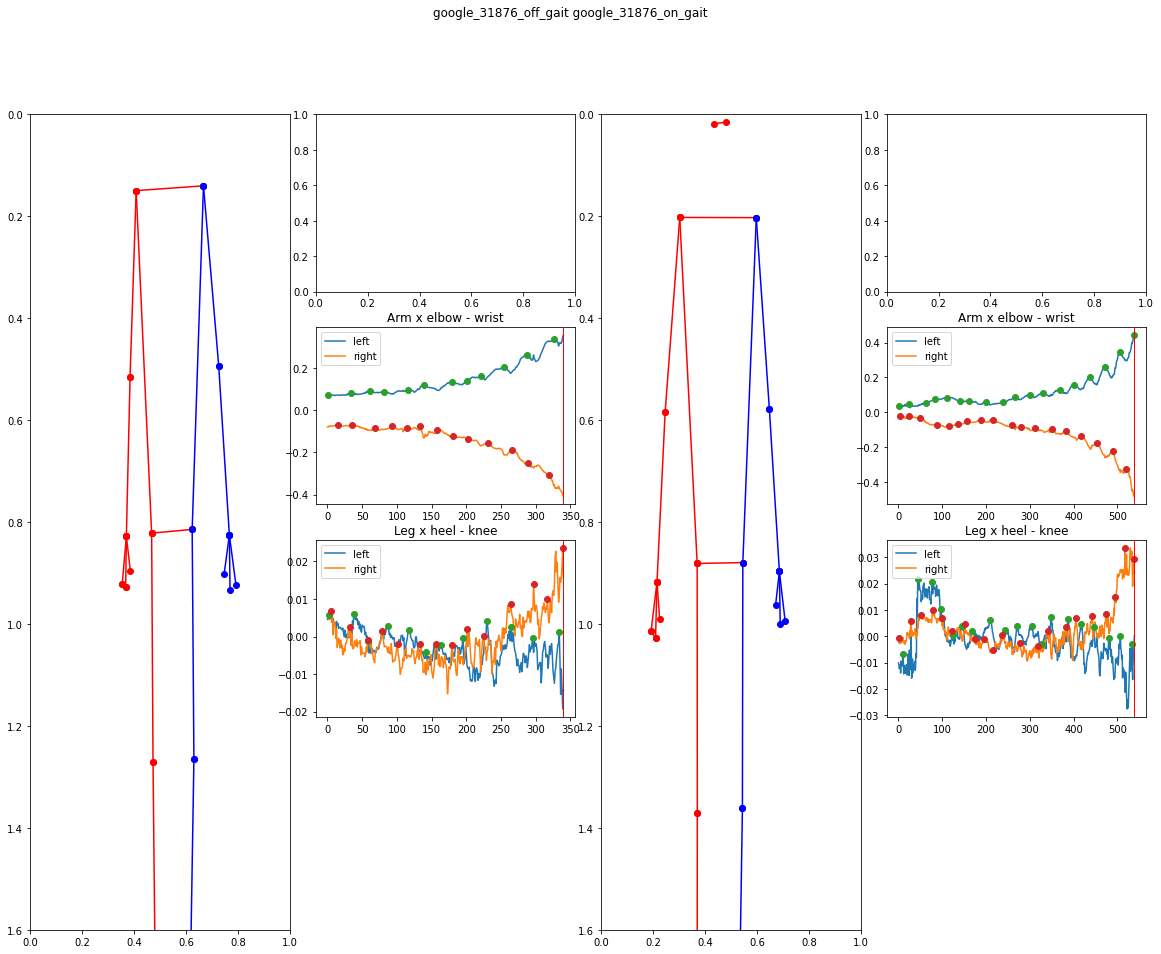

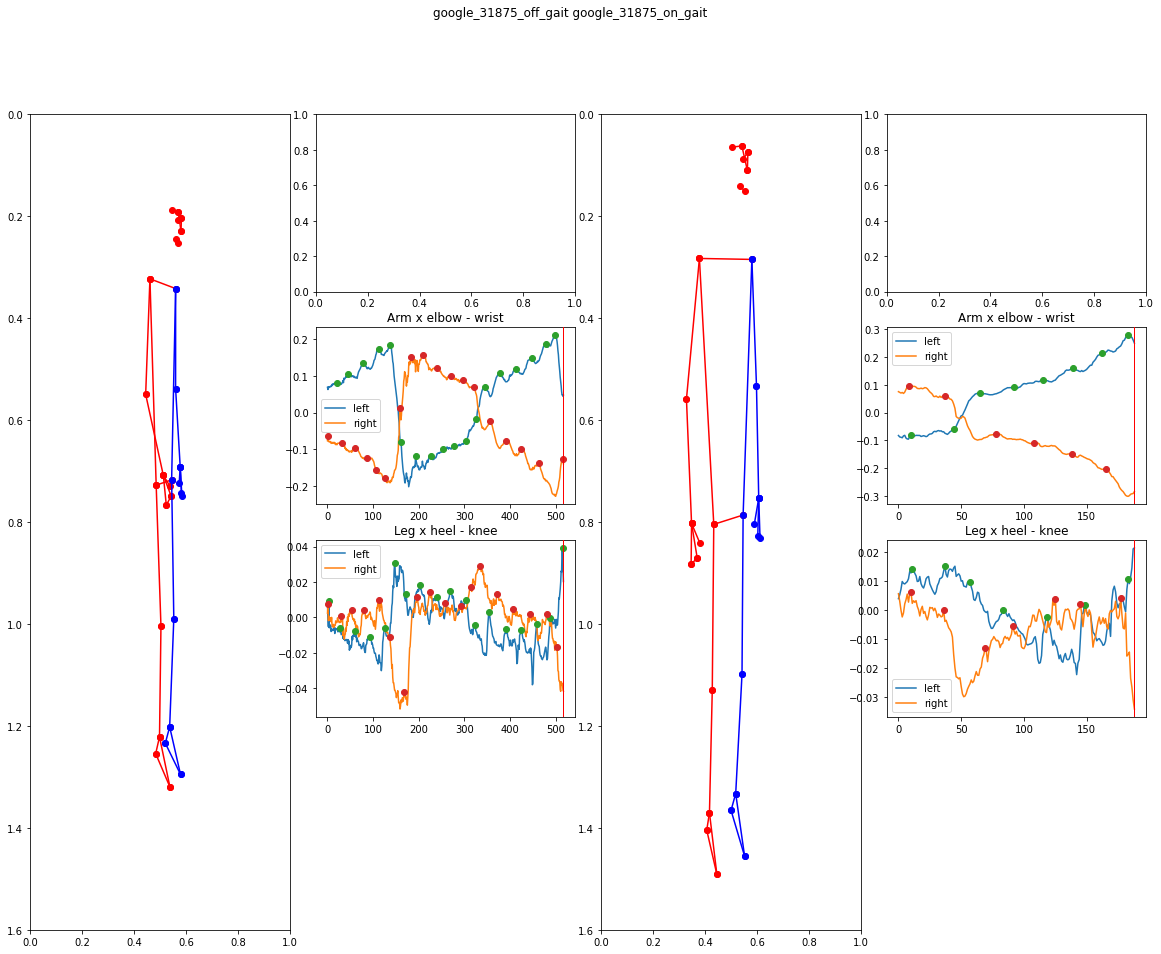

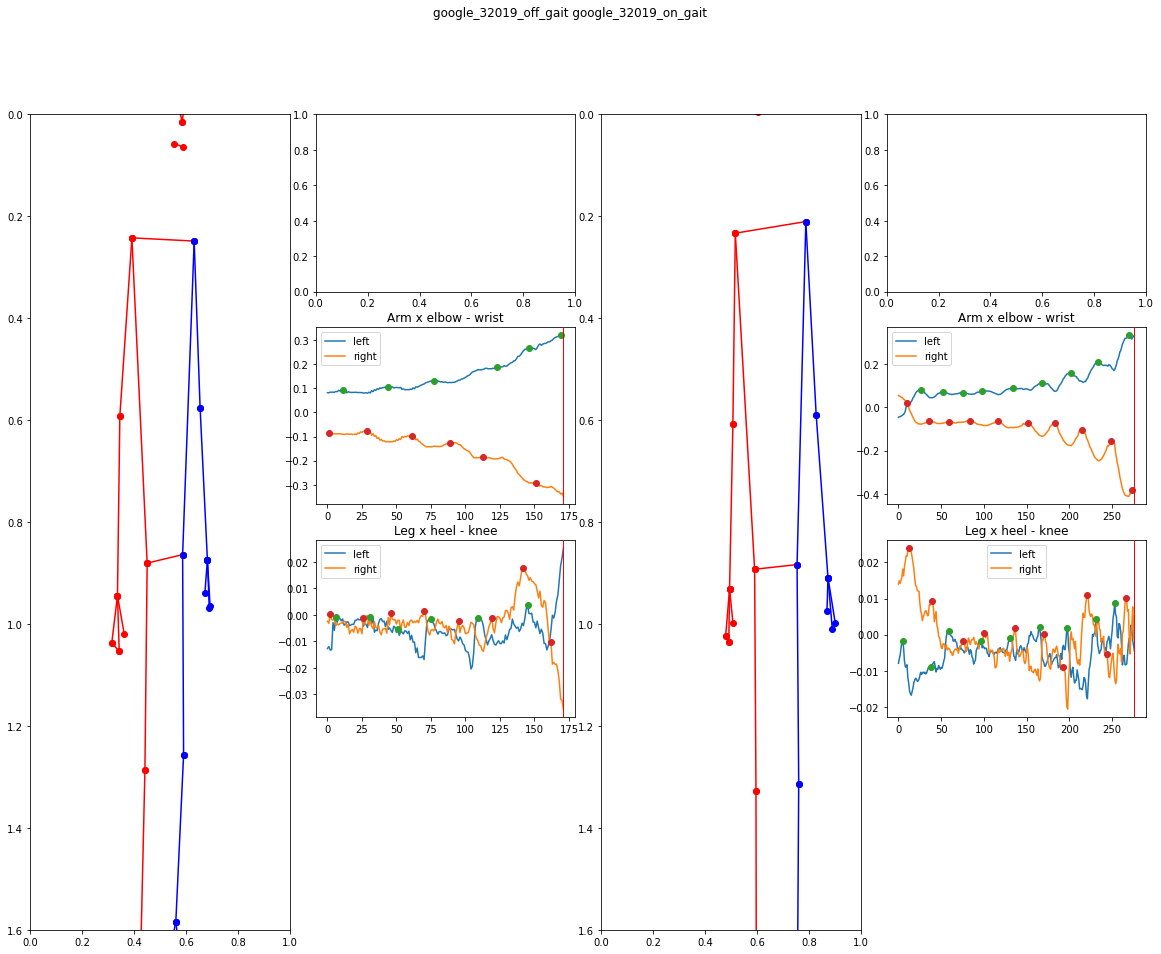

In [ ]:
pair_idxs = [8, 6, 0, 10, 14, 1, 12, 17, 18, 15, 9, 19, 20, 11]
paired_poses = [poses[i] for i in pair_idxs]
for i in range(3):
  p1 = create_arm_leg_pair_x(paired_poses[2*i])
  p2 = create_arm_leg_pair_x(paired_poses[2*i+1])
  plot_pose2(paired_poses[2*i], p1, paired_poses[2*i+1], p2, '')

In [ ]:
pair_idxs = [8, 6, 0, 10, 14, 1, 12, 17, 18, 15, 9, 19, 20, 11]
paired_poses = [poses[i] for i in pair_idxs]
for i in range(3):
  p1 = create_wrist_heel_pair(paired_poses[2*i])
  p2 = create_wrist_heel_pair(paired_poses[2*i+1])
  plot_pose2(paired_poses[2*i], p1, paired_poses[2*i+1], p2, '')

TypeError: ignored

In [ ]:
pair_idxs = [8, 6, 0, 10, 14, 1, 12, 17, 18, 15, 9, 19, 20, 11]
paired_poses = [poses[i] for i in pair_idxs]
for i in range(3):
  p1 = create_arm_leg_pair(paired_poses[2*i])
  p2 = create_arm_leg_pair(paired_poses[2*i+1])
  plot_pose2(paired_poses[2*i], p1, paired_poses[2*i+1], p2, '')

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
for i, (k, v) in enumerate(p1.items()):
  peaks0, _ = scipy.signal.find_peaks(v[0], distance=20)
  peaks1, _ = scipy.signal.find_peaks(v[1], distance=20)
  ax[0,i].plot(v[0])
  ax[0,i].plot(peaks0, v[0][peaks0], 'o')
  ax[0,i].plot(v[1])
  ax[0,i].plot(peaks1, v[1][peaks1], 'o')
  ax[0,i].set_title(k)
  min_len = min(len(peaks0), len(peaks1))
  ax[1,i].plot(peaks0[:min_len] - peaks1[:min_len], 'o-')
  #ax[1,i].plot(peaks1, 'o-')
  ax[1,i].set_title(k + 'swing intervals')
  ax[1,i].grid()

In [ ]:
#@title Whole Session Difference between left/right cross wrist-ankle distance
pair_idxs = [8, 6, 0, 10, 14, 1, 12, 17, 18, 15, 9, 19, 20, 11]
paired_poses = [poses[i] for i in pair_idxs]
fig, ax = plt.subplots(2, 3, figsize=(20,10))
for i in range(3):
  l0 = paired_poses[2*i].left_wrist_right_ankle(use_all=True)
  r0 = paired_poses[2*i].right_wrist_left_ankle(use_all=True)
  l1 = paired_poses[2*i+1].left_wrist_right_ankle(use_all=True)
  r1 = paired_poses[2*i+1].right_wrist_left_ankle(use_all=True)
  ax[0, i].plot(l0, label='left off')
  ax[1, i].plot(r0, label='right off')
  ax[0, i].plot(l1, label='left on')
  ax[1, i].plot(r1, label='right on')
  ax[0, i].legend()
  ax[1, i].legend()
_ = plt.suptitle('Difference between left/right cross wrist-ankle distance')

In [ ]:
pair_idxs = [8, 6, 0, 10, 14, 1, 12, 17, 18, 15, 9, 19, 20, 11]
paired_poses = [poses[i] for i in pair_idxs]
fig, ax = plt.subplots(2, 3, figsize=(20,10))
for i in range(3):
  l0 = paired_poses[2*i].left_wrist_right_ankle()
  r0 = paired_poses[2*i].right_wrist_left_ankle()
  l1 = paired_poses[2*i+1].left_wrist_right_ankle()
  r1 = paired_poses[2*i+1].right_wrist_left_ankle()
  ax[0, i].plot(l0, label='left w-a dist off')
  ax[1, i].plot(r0, label='right w-a dist off')
  ax[0, i].plot(l1, label='left w-a dist on')
  ax[1, i].plot(r1, label='right w-a dist on')
  ax[0, i].legend()
  ax[1, i].legend()
_ = plt.suptitle('Difference between left/right cross wrist-ankle distance')

In [ ]:
pair_idxs = [8, 6, 0, 10, 14, 1, 12, 17, 18, 15, 9, 19, 20, 11]
paired_poses = [poses[i] for i in pair_idxs]
fig, ax = plt.subplots(2, 3, figsize=(20,10))
for i in range(3):
  l0 = paired_poses[2*i].left_wrist_right_ankle(use_all=True)
  _, fl0 = scipy.signal.welch(l0, nperseg=300, detrend='linear')
  r0 = paired_poses[2*i].right_wrist_left_ankle(use_all=True)
  _, fr0 = scipy.signal.welch(r0, nperseg=300, detrend='linear')
  l1 = paired_poses[2*i+1].left_wrist_right_ankle(use_all=True)
  _, fl1 = scipy.signal.welch(l1, nperseg=300, detrend='linear')
  r1 = paired_poses[2*i+1].right_wrist_left_ankle(use_all=True)
  _, fr1 = scipy.signal.welch(r1, nperseg=300, detrend='linear')
  ax[0, i].plot(np.log(fl0), label='left w-a dist off')
  ax[1, i].plot(np.log(fr0), label='right w-a dist off')
  ax[0, i].plot(np.log(fl1), label='left w-a dist on')
  ax[1, i].plot(np.log(fr1), label='right w-a dist on')
  ax[0, i].legend()
  ax[1, i].legend()
_ = plt.suptitle('Difference between left/right cross wrist-ankle distance')

In [ ]:
pair_idxs = [8, 6, 0, 10, 14, 1, 12, 17, 18, 15, 9, 19, 20, 11]
paired_poses = [poses[i] for i in pair_idxs]
fig, ax = plt.subplots(1, 3, figsize=(20,5))
for i in range(3):
  l0 = paired_poses[2*i].left_arm(use_all=True)
  r0 = paired_poses[2*i].right_arm(use_all=True)
  l1 = paired_poses[2*i+1].left_arm(use_all=True)
  r1 = paired_poses[2*i+1].right_arm(use_all=True)
  a0 = np.abs(np.arctan(l0[:,0]/l0[:,1]) - np.arctan(r0[:,0]/r0[:,1]))
  a1 = np.abs(np.arctan(l1[:,0]/l1[:,1]) - np.arctan(r1[:,0]/r1[:,1]))
  ax[i].plot(a0, label='off')
  ax[i].plot(a1, label='on')
  ax[i].legend()
_ = plt.suptitle('Difference between left/right arm angle')

In [ ]:
–#@title Arm Y axis change
fig, ax = plt.subplots(len(poses)*2, figsize=(20, 25))
for i, pose in enumerate(poses):
  left_arm = pose.left_arm()
  right_arm = pose.right_arm()
  height = pose.height()
  fxx, txx, pxx = scipy.signal.spectrogram(left_arm[:,1], fs=30, nperseg=100, noverlap=90, nfft=128)
  ax[2*i].set_title(f'{pose.id} arm movement on y axis')
  ax[2*i].plot(left_arm[:, 1]/height, label='left arm y')
  ax[2*i].plot(right_arm[:, 1]/height, label='right arm y')
  ax[2*i].legend()
  ax[2*i+1].imshow(np.log(pxx), aspect='auto')
plt.tight_layout()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


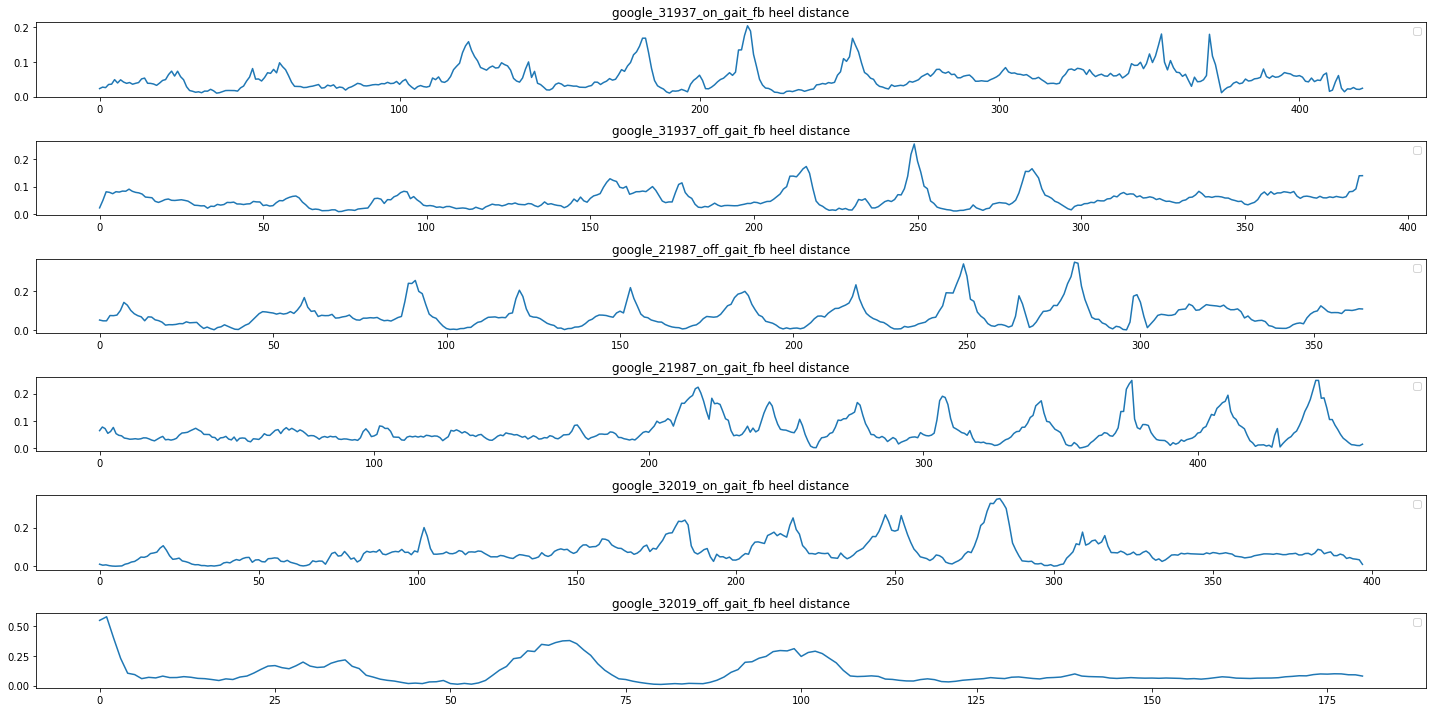

In [ ]:
#@title distance between two heels.
fig, ax = plt.subplots(len(poses), figsize=(20, 10))
for i, pose in enumerate(poses):
  heel_distance = pose.heel_distance()
  height = pose.height()
  ax[i].set_title(f'{pose.id} heel distance')
  ax[i].plot(heel_distance/height)
  ax[i].legend()
plt.tight_layout()

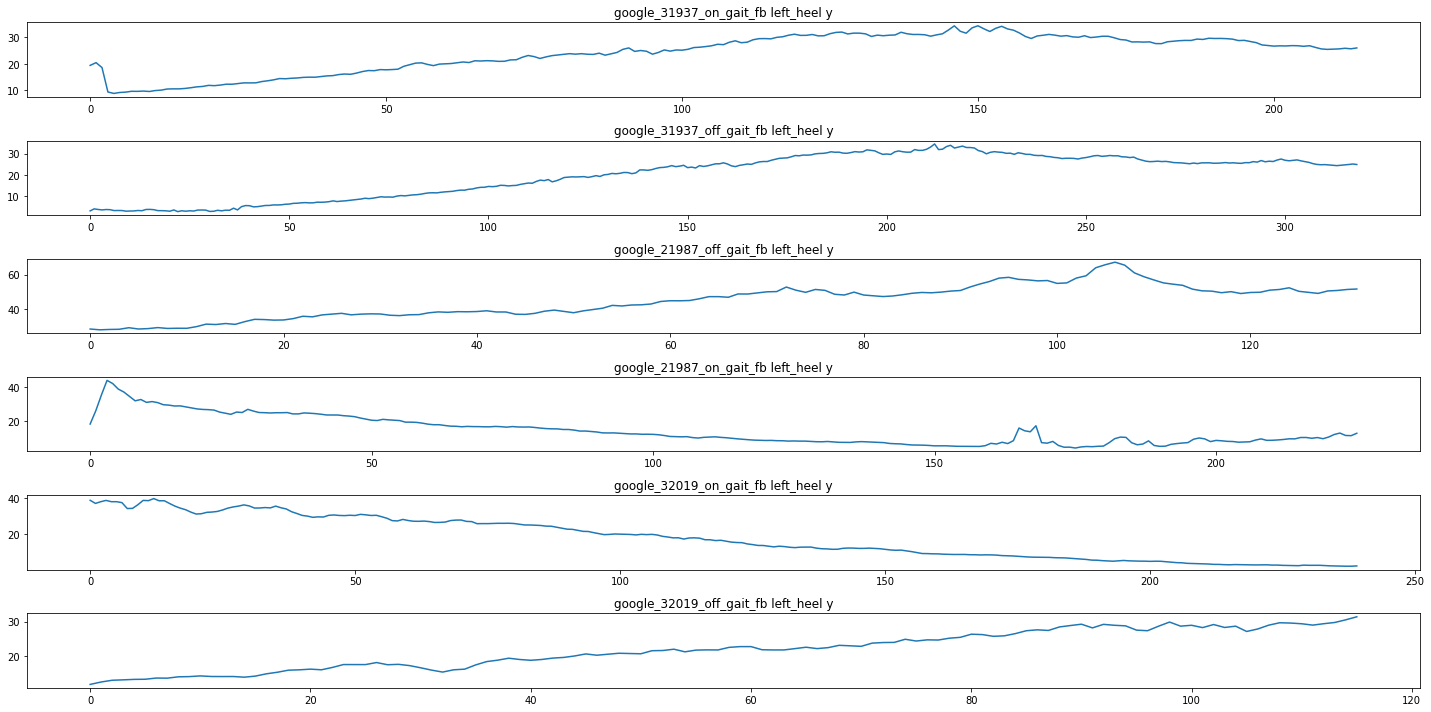

In [ ]:
fig, ax = plt.subplots(len(poses), figsize=(20, 10))
for i, pose in enumerate(poses):
  left_heel = pose.new_joints.left_heel[1]
  height = pose.height(1)
  ax[i].set_title(f'{pose.id} left_heel y')
  ax[i].plot(left_heel[:,1]/height)
plt.tight_layout()

## Feature Visualization

In [ ]:
import seaborn as sns

def static_viz(mat, connections, pairs, idx=None):
  """Animation with skeleton and metrics.

  Args:
    title: title of the plot
    mat: xy points for the whole body.
    connections: idx for connection points to form skeleton.
    pairs: Dict[name, [left_metrics, right_metrics]] is a dictionary of left/right metrics.
      Total count <= 5.
  """
  if idx is None:
      idx = 60
  sns.set()
  fig = plt.figure(constrained_layout=True, figsize=(15, 12))
  gs = fig.add_gridspec(nrows=3, ncols=3, wspace=0.1)
  ax1 = fig.add_subplot(gs[:, 0])
  ax1.xaxis.set_visible(False)
  ax1.yaxis.set_visible(False)
  ax_metrics = []
  for j in range(3):
    ax = fig.add_subplot(gs[j, 1])
    ax.xaxis.set_ticks([])
    ax.yaxis.set_visible(False)
    ax_metrics.append(ax)
  for j in range(3):
    ax = fig.add_subplot(gs[j, 2])
    ax.xaxis.set_ticks([])
    ax.yaxis.set_visible(False)
    ax_metrics.append(ax)
  ax1.set_xlim(0, 1)
  ax1.set_ylim(0, 1.6)
  ax1.invert_yaxis()
  mark = 0
  metric_order = ['Arm x elbow - wrist', 'Leg x heel - knee', 'Wrist to opposite ankle', 
                  'Arm y elbow - wrist', 'Leg y heel - knee', 'Heel distance']
  for ax, metric_name in zip(ax_metrics, metric_order):
    metrics = pairs[metric_name]
    if metric_name == "Heel distance":
      peak, _ = scipy.signal.find_peaks(metrics, distance=20)
      _ = ax.plot(metrics)
      _ = ax.plot(peak, metrics[peak], 'o')
    else:
      joint_labels = {0: ("elbow", "wrist"), 1: ("heel", "knee"), 
                      2: ("elbow", "wrist"), 3: ("heel", "knee"),
                      4: ("wrist", "ankle")}
      peak0, _ = scipy.signal.find_peaks(metrics[0], distance=20)
      peak1, _ = scipy.signal.find_peaks(metrics[1], distance=20)
      _ = ax.plot(metrics[0], label=f'Left {joint_labels[mark][0]} $-$ right {joint_labels[mark][1]}')
      _ = ax.plot(metrics[1], label=f'Right {joint_labels[mark][1]} $-$ left {joint_labels[mark][0]}')
      _ = ax.plot(peak0, metrics[0][peak0], 'o')
      _ = ax.plot(peak1, metrics[1][peak1], 'o')
    ax.legend(loc = 'upper right')
    ax.set_xlabel("Time")
    mark += 1
  ax1.set_title("Video skeleton snapshot")
  ax_metrics[0].set_title("Elbow $-$ wrist $x$-coordinate")
  ax_metrics[1].set_title("Heel $-$ knee $x$-coordinate")
  ax_metrics[2].set_title("Wrist $-$ ankle Euclidean distance")
  ax_metrics[3].set_title("Elbow $-$ wrist $y$-coordinate")
  ax_metrics[4].set_title("Heel $-$ knee $y$-coordinate")
  ax_metrics[5].set_title("Euclidean distance between heels")
  poselines = []
  for conn in connections:
    if conn[0] % 2 == 0:
      oneline, = ax1.plot([], [], 'ro-')
    else:
      oneline, = ax1.plot([], [], 'bo-')
    poselines.append(oneline)
  for j, oneline in enumerate(poselines):
    oneline.set_data(mat[idx, 2*connections[j]], mat[idx, 2*connections[j]+1])

No handles with labels found to put in legend.


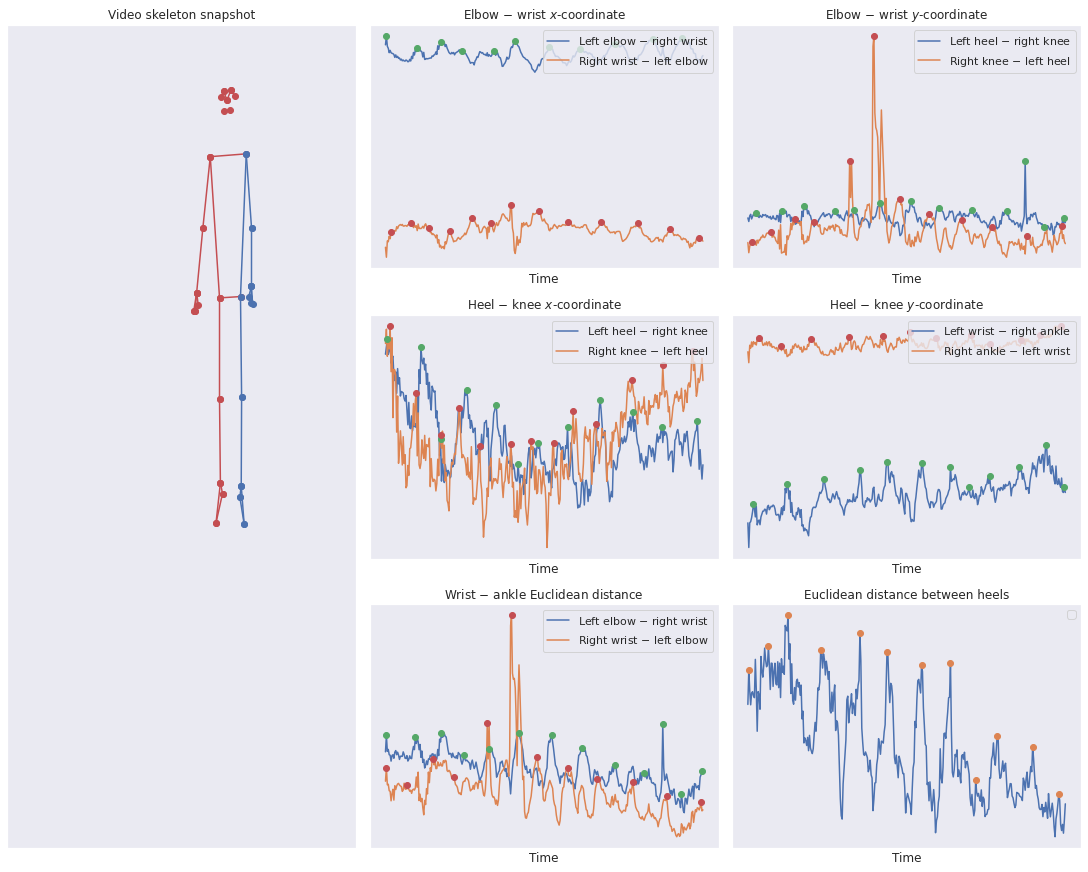

In [ ]:
p1 = {}
arm_leg_x = create_arm_leg_pair_x(poses[9])
arm_leg_y = create_arm_leg_pair_y(poses[9])
wrist_ankle = create_wrist_ankle_pair(poses[9])
heel_distance = create_heel_distance(poses[9])
metrics = [arm_leg_x, arm_leg_y, wrist_ankle, heel_distance]
for metric in metrics:
  for k in metric.keys():
    if k != "id":
      p1[k] = metric[k]
static_viz(poses[9].new_pose2d, connections, p1, idx=210)

In [ ]:
import seaborn as sns

def compare_features(pairs1, pairs2):
    ''' data1 is patient with high tapping score (high severity) and 
    data2 is patient with low tapping score (low severity)'''
    sns.set()
    fig = plt.figure(constrained_layout=True, figsize=(15, 12))
    gs = fig.add_gridspec(nrows=3, ncols=4, wspace=0.1)
    ax_metrics1 = []
    for j in range(3):
        ax = fig.add_subplot(gs[j, 0])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_visible(False)
        ax_metrics1.append(ax)
    for j in range(3):
        ax = fig.add_subplot(gs[j, 1])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_visible(False)
        ax_metrics1.append(ax)
    ax_metrics2 = []
    for j in range(3):
        ax = fig.add_subplot(gs[j, 2])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_visible(False)
        ax_metrics2.append(ax)
    for j in range(3):
        ax = fig.add_subplot(gs[j, 3])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_visible(False)
        ax_metrics2.append(ax)
    
    metric_order = ['Arm x elbow - wrist', 'Leg x heel - knee', 'Wrist to opposite ankle', 
                    'Arm y elbow - wrist', 'Leg y heel - knee', 'Heel distance']

    mark = 0
    for ax, metric_name in zip(ax_metrics1, metric_order):
        metrics = pairs1[metric_name]
        if metric_name == "Heel distance":
            peak, _ = scipy.signal.find_peaks(metrics, distance=20)
            _ = ax.plot(metrics)
            _ = ax.plot(peak, metrics[peak], 'o')
        else:
            joint_labels = {0: ("elbow", "wrist"), 1: ("heel", "knee"), 
                            2: ("elbow", "wrist"), 3: ("heel", "knee"),
                            4: ("wrist", "ankle")}
            peak0, _ = scipy.signal.find_peaks(metrics[0], distance=20)
            peak1, _ = scipy.signal.find_peaks(metrics[1], distance=20)
            _ = ax.plot(metrics[0], label=f'Left {joint_labels[mark][0]} $-$ right {joint_labels[mark][1]}')
            _ = ax.plot(metrics[1], label=f'Right {joint_labels[mark][1]} $-$ left {joint_labels[mark][0]}')
            _ = ax.plot(peak0, metrics[0][peak0], 'o')
            _ = ax.plot(peak1, metrics[1][peak1], 'o')
        ax.legend(loc = 'upper right')
        ax.set_xlabel("Time")
        mark += 1
    mark = 0
    for ax, metric_name in zip(ax_metrics2, metric_order):
        metrics = pairs2[metric_name]
        if metric_name == "Heel distance":
            peak, _ = scipy.signal.find_peaks(metrics, distance=20)
            _ = ax.plot(metrics)
            _ = ax.plot(peak, metrics[peak], 'o')
        else:
            joint_labels = {0: ("elbow", "wrist"), 1: ("heel", "knee"), 
                            2: ("elbow", "wrist"), 3: ("heel", "knee"),
                            4: ("wrist", "ankle")}
            peak0, _ = scipy.signal.find_peaks(metrics[0], distance=20)
            peak1, _ = scipy.signal.find_peaks(metrics[1], distance=20)
            _ = ax.plot(metrics[0], label=f'Left {joint_labels[mark][0]} $-$ right {joint_labels[mark][1]}')
            _ = ax.plot(metrics[1], label=f'Right {joint_labels[mark][1]} $-$ left {joint_labels[mark][0]}')
            _ = ax.plot(peak0, metrics[0][peak0], 'o')
            _ = ax.plot(peak1, metrics[1][peak1], 'o')
        ax.legend(loc = 'upper right')
        ax.set_xlabel("Time")
        mark += 1

    for i, ax_metrics in enumerate([ax_metrics1, ax_metrics2]):
        if i == 0:
            symptom_text = "High \ symptom \ severity"
        else:
            symptom_text = "Low \ symptom \ severity"
        ax_metrics[0].set_title("Elbow $-$ wrist $x$-coordinate\n" + r"$\bf{" + symptom_text + "}$")
        ax_metrics[1].set_title("Heel $-$ knee $x$-coordinate\n" + r"$\bf{" + symptom_text + "}$")
        ax_metrics[2].set_title("Wrist $-$ ankle Euclidean distance\n" + r"$\bf{" + symptom_text + "}$")
        ax_metrics[3].set_title("Elbow $-$ wrist $y$-coordinate\n" + r"$\bf{" + symptom_text + "}$")
        ax_metrics[4].set_title("Heel $-$ knee $y$-coordinate\n" + r"$\bf{" + symptom_text + "}$")
        ax_metrics[5].set_title("Euclidean distance between heels\n" + r"$\bf{" + symptom_text + "}$")

    return fig

In [ ]:
class FeaturizedData:
  def __init__(self, pose):
    self.pose = pose
    self.pid = pose.id.split("_")[1]
    self.label = labels[pose.id]
    self.on_state = pose.id.split("_")[2]
    self.features = self.get_feature_matrix(pose)

  def get_feature_matrix(self, pose):
  #shape = timesteps x num_features
  #timesteps downsampled to 500
    arm_leg_x = create_arm_leg_pair_x(pose)
    arm_leg_y = create_arm_leg_pair_y(pose)
    wrist_ankle = create_wrist_ankle_pair(pose)
    heel_distance = create_heel_distance(pose)
    metrics = [arm_leg_x, arm_leg_y, wrist_ankle, heel_distance]
    vectors = []
    for metric in metrics:
      for k in metric.keys():
        if k != "id":
          if type(metric[k]) == tuple:
            vec0 = scipy.signal.resample(metric[k][0], 500)
            vec1 = scipy.signal.resample(metric[k][1], 500)
            vectors.append(vec0)
            vectors.append(vec1)
          else:
            vec = scipy.signal.resample(metric[k], 500)
            vectors.append(vec)
    vectors = [v.reshape(-1, 1) for v in vectors]
    features = np.concatenate(vectors, axis=1)
    return features

In [ ]:
data_list = [FeaturizedData(pose) for pose in poses]
data_list = [d for d in data_list if d.label != -99]

In [ ]:
high_scores = []
low_scores = []
for i, data in enumerate(data_list):
    if data.label >= 2:
        high_scores.append(data.pose)
    elif data.label == 0: 
        low_scores.append(data.pose)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


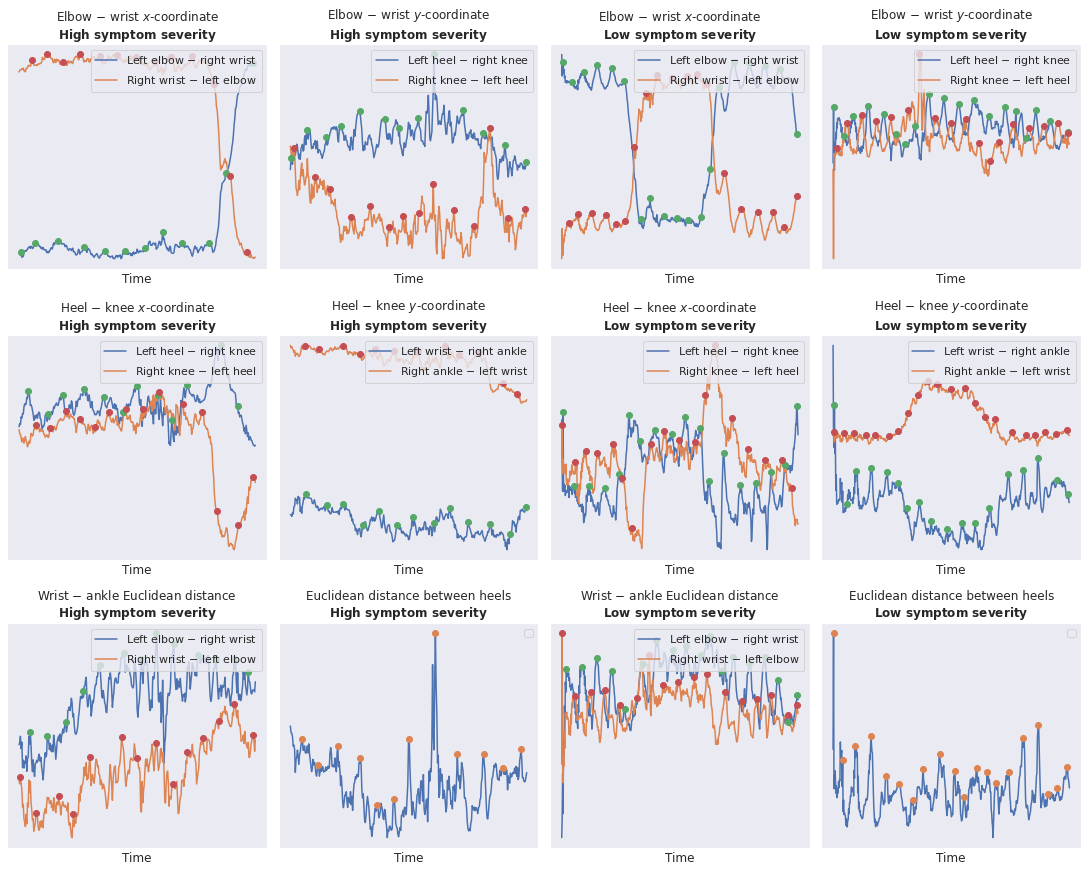

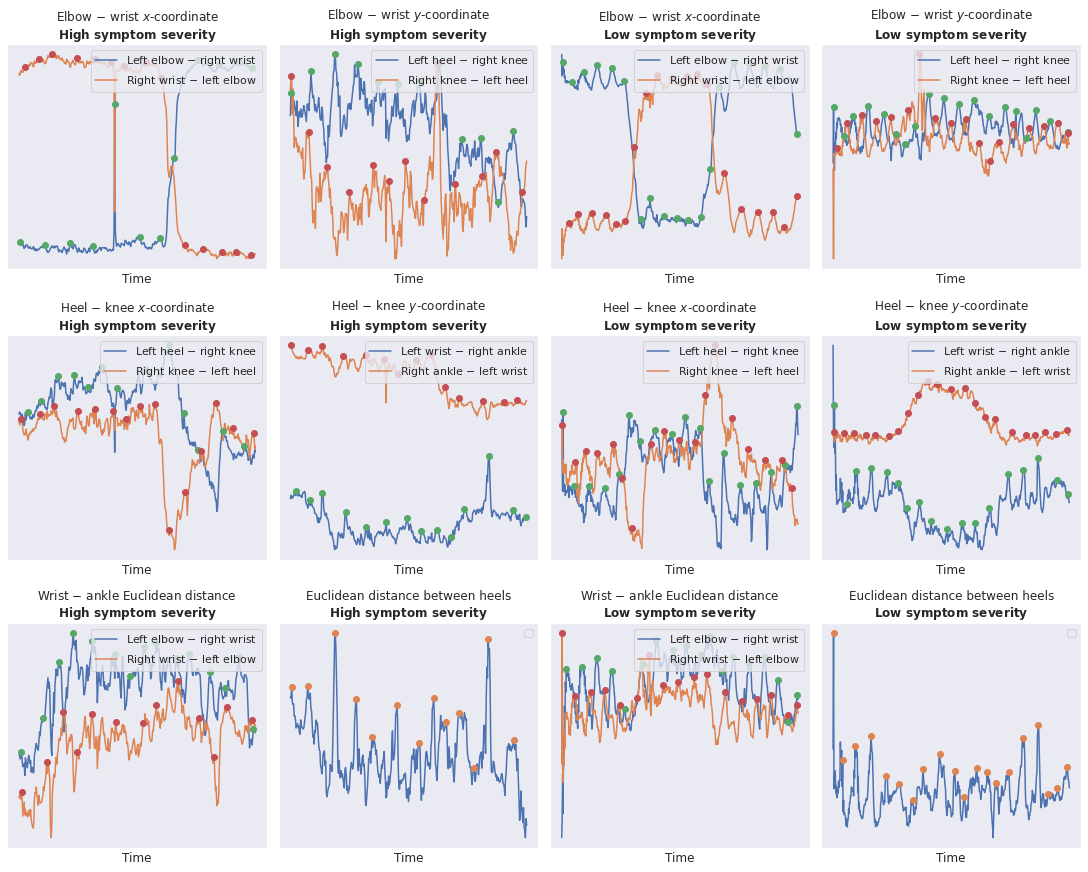

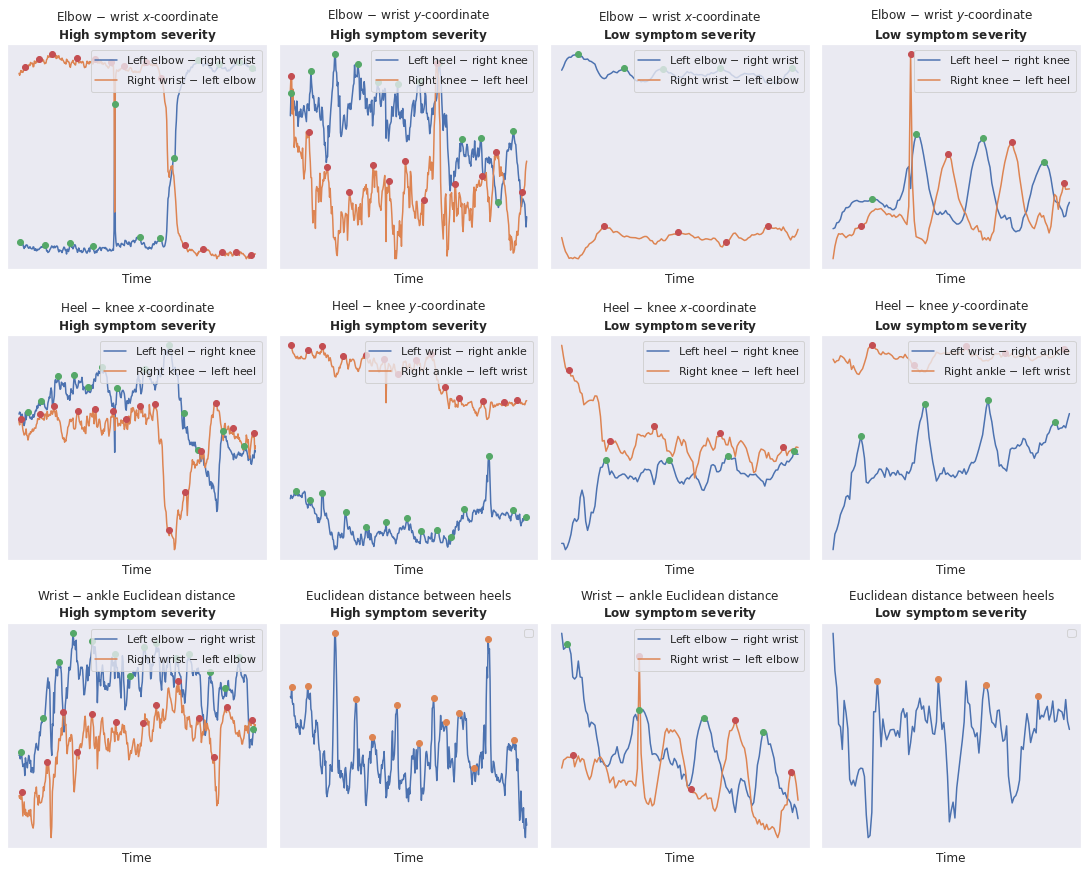

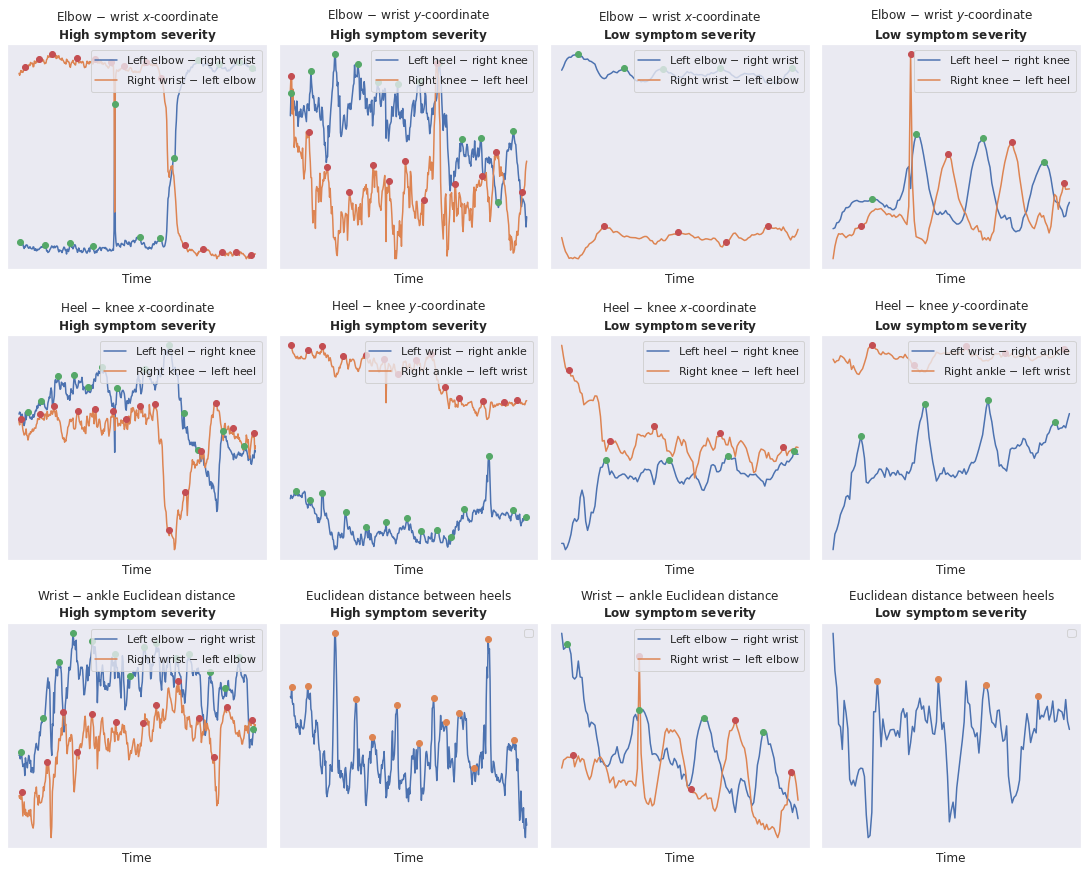

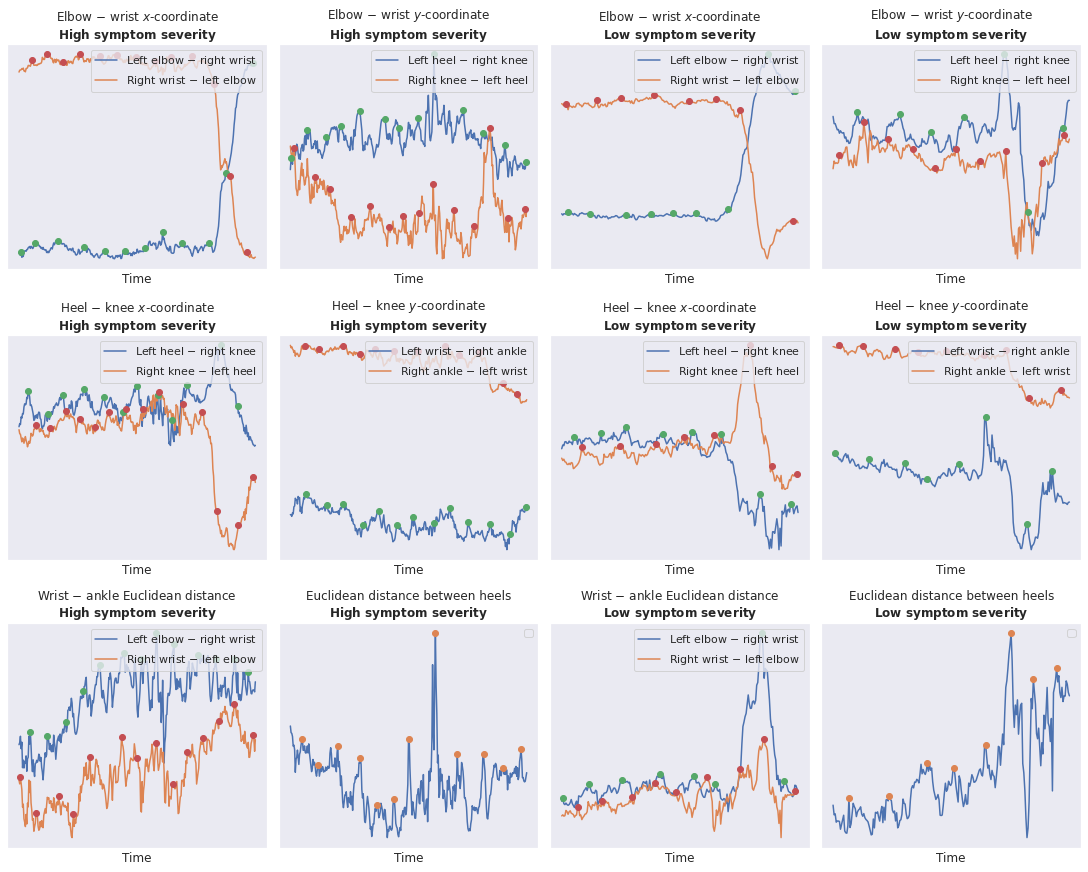

In [ ]:
for i in range(5):
    try:
        id1 = np.random.randint(len(high_scores))
        id2 = np.random.randint(len(low_scores))

        p1 = {}
        arm_leg_x = create_arm_leg_pair_x(high_scores[id1])
        arm_leg_y = create_arm_leg_pair_y(high_scores[id1])
        wrist_ankle = create_wrist_ankle_pair(high_scores[id1])
        heel_distance = create_heel_distance(high_scores[id1])
        metrics = [arm_leg_x, arm_leg_y, wrist_ankle, heel_distance]
        for metric in metrics:
            for k in metric.keys():
                if k != "id":
                    p1[k] = metric[k]
        
        p2 = {}
        arm_leg_x = create_arm_leg_pair_x(low_scores[id2])
        arm_leg_y = create_arm_leg_pair_y(low_scores[id2])
        wrist_ankle = create_wrist_ankle_pair(low_scores[id2])
        heel_distance = create_heel_distance(low_scores[id2])
        metrics = [arm_leg_x, arm_leg_y, wrist_ankle, heel_distance]
        for metric in metrics:
            for k in metric.keys():
                if k != "id":
                    p2[k] = metric[k]

        fig = compare_features(p1, p2)
        fig.savefig(f"./comparisons/{id1}_{id2}.png")
    except:
        continue

## On/off prediction

In [ ]:
class FeaturizedData:
  def __init__(self, pose):
    self.pose = pose
    self.pid = pose.id.split("_")[1]
    self.label = labels[pose.id]
    self.on_state = pose.id.split("_")[2]
    self.features = self.get_feature_matrix(pose)

  def get_feature_matrix(self, pose):
  #shape = timesteps x num_features
  #timesteps downsampled to 500
    arm_leg_x = create_arm_leg_pair_x(pose)
    arm_leg_y = create_arm_leg_pair_y(pose)
    wrist_ankle = create_wrist_ankle_pair(pose)
    heel_distance = create_heel_distance(pose)
    metrics = [arm_leg_x, arm_leg_y, wrist_ankle, heel_distance]
    vectors = []
    for metric in metrics:
      for k in metric.keys():
        if k != "id":
          if type(metric[k]) == tuple:
            vec0 = scipy.signal.resample(metric[k][0], 500)
            vec1 = scipy.signal.resample(metric[k][1], 500)
            vectors.append(vec0)
            vectors.append(vec1)
          else:
            vec = scipy.signal.resample(metric[k], 500)
            vectors.append(vec)
    vectors = [v.reshape(-1, 1) for v in vectors]
    features = np.concatenate(vectors, axis=1)
    return features

In [ ]:
class GaitDataset(Dataset):
  def __init__(self, data_list):
    #data_list is a list of FeaturizedData objects
    self.data_list = data_list

  def __len__(self):
    return len(self.data_list)

  def __getitem__(self, idx):
    data = self.data_list[idx]
    if data.on_state == 'on':
      label = 1
    else:
      label = 0
    return torch.FloatTensor(data.features), torch.FloatTensor([label])

In [ ]:
data_list = [FeaturizedData(pose) for pose in poses]

In [ ]:
class MLPPredictor(nn.Module):
  def __init__(self, num_timesteps, num_features):
    super(MLPPredictor, self).__init__()
    self.num_timesteps = num_timesteps
    self.num_features = num_features
    self.linear1 = nn.Linear(num_timesteps * num_features, 100)
    self.linear2 = nn.Linear(100, 1)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    #x has shape batch_size x timesteps x num_features
    x = x.reshape(-1, num_timesteps * num_features)
    out = self.relu(self.linear1(x))
    out = self.sigmoid(self.linear2(out))
    return out

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

train_dataset = GaitDataset(data_list[:18])
test_dataset = GaitDataset(data_list[18:])

num_epochs = 360
num_timesteps, num_features = train_dataset[0][0].shape

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, shuffle=True)
model = MLPPredictor(num_timesteps, num_features)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.BCELoss()

model.train()
losses = []
for epoch in range(num_epochs):
  for batch in train_loader:
    inputs, targets = batch
    pred = model(inputs)
    loss = loss_fn(pred.squeeze(), targets.squeeze())
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

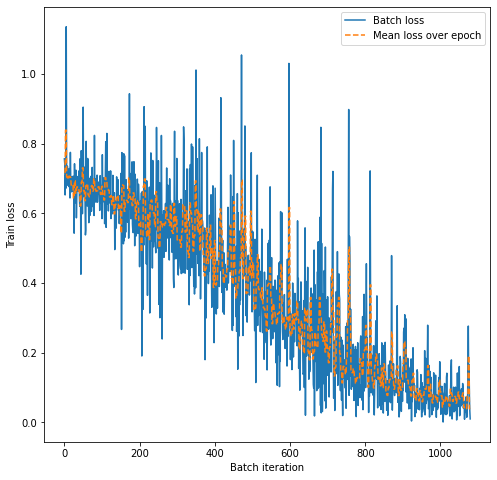

In [ ]:
plt.figure(figsize=[8, 8])
plt.plot(losses, label="Batch loss")
num_batches = len(train_dataset) // 8 + min(len(train_dataset) % 8, 1)
mean_losses = sum([[np.mean(losses[i * num_batches : (i + 1) * num_batches])] * num_batches
               for i in range(num_epochs * num_batches // num_batches)], [])
plt.plot(mean_losses, '--', label="Mean loss over epoch")
plt.ylabel("Train loss")
plt.xlabel("Batch iteration")
plt.legend()
plt.show()

In [ ]:
model.eval()
preds = []
targets = []
for item in test_loader:
  input, target = item
  pred = model(input)
  preds.append(pred.squeeze())
  targets.append(target.squeeze())

In [ ]:
prec, recall, thresholds = skm.precision_recall_curve(targets, preds)
average_prec = skm.average_precision_score(targets, preds)

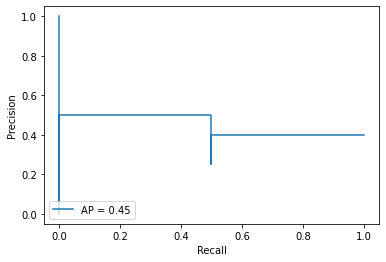

In [ ]:
pr_display = skm.PrecisionRecallDisplay(prec, recall, average_precision=average_prec).plot()

In [ ]:
auc = skm.auc(recall, prec)
auc

0.2875

## Symptom Severity Prediction

In [ ]:
class FeaturizedData:
  def __init__(self, pose):
    self.pose = pose
    self.pid = pose.id.split("_")[1]
    self.label = labels[pose.id]
    self.on_state = pose.id.split("_")[2]
    self.features = self.get_feature_matrix(pose)

  def get_feature_matrix(self, pose):
  #shape = timesteps x num_features
  #timesteps downsampled to 500
    arm_leg_x = create_arm_leg_pair_x(pose)
    arm_leg_y = create_arm_leg_pair_y(pose)
    wrist_ankle = create_wrist_ankle_pair(pose)
    heel_distance = create_heel_distance(pose)
    metrics = [arm_leg_x, arm_leg_y, wrist_ankle, heel_distance]
    vectors = []
    for metric in metrics:
      for k in metric.keys():
        if k != "id":
          if type(metric[k]) == tuple:
            vec0 = scipy.signal.resample(metric[k][0], 500)
            vec1 = scipy.signal.resample(metric[k][1], 500)
            vectors.append(vec0)
            vectors.append(vec1)
          else:
            vec = scipy.signal.resample(metric[k], 500)
            vectors.append(vec)
    vectors = [v.reshape(-1, 1) for v in vectors]
    features = np.concatenate(vectors, axis=1)
    return features

In [ ]:
class GaitSymptomDataset(Dataset):
  def __init__(self, data_list):
    #data_list is a list of FeaturizedData objects
    self.data_list = data_list

  def __len__(self):
    return len(self.data_list)

  def __getitem__(self, idx):
    data = self.data_list[idx]
    if data.label >= 1: #slight to severe gait symptoms
      label = 1
    else: #normal/no symptoms
      label = 0
    return torch.FloatTensor(data.features), torch.FloatTensor([label])

In [ ]:
data_list = [FeaturizedData(pose) for pose in poses]
data_list = [d for d in data_list if d.label != -99]

In [ ]:
class MLPPredictor(nn.Module):
  def __init__(self, num_timesteps, num_features):
    super(MLPPredictor, self).__init__()
    self.num_timesteps = num_timesteps
    self.num_features = num_features
    self.linear1 = nn.Linear(num_timesteps * num_features, 50)
    self.linear2 = nn.Linear(50, 1)
    # self.linear = nn.Linear(num_timesteps * num_features, 1)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    #x has shape batch_size x timesteps x num_features
    x = x.reshape(-1, num_timesteps * num_features)
    out = self.relu(self.linear1(x))
    out = self.sigmoid(self.linear2(out))
    # out = self.sigmoid(self.linear(x))
    return out

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Hold out validation

In [ ]:
num_train = round(0.7 * len(data_list))
train_dataset = GaitSymptomDataset(data_list[:num_train])
val_dataset = GaitSymptomDataset(data_list[num_train:])

In [ ]:
print("Number of symptomatic cases in train data:", len([d[1] for d in train_dataset if d[1] == 1]))
print("Number of asymptomatic cases in train data:", len([d[1] for d in train_dataset if d[1] == 0]))

Number of symptomatic cases in train data: 11
Number of asymptomatic cases in train data: 4


In [ ]:
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

num_epochs = 360
num_timesteps, num_features = train_dataset[0][0].shape

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, shuffle=True)
model = MLPPredictor(num_timesteps, num_features)
optimizer = optim.SGD(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

losses = []
val_losses = []
for epoch in range(num_epochs):
  model.train()
  for batch in train_loader:
    inputs, targets = batch
    pred = model(inputs)
    loss = loss_fn(pred.squeeze(), targets.squeeze())
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  model.eval()
  val_loss = 0
  for batch in val_loader:
    inputs, targets = batch
    pred = model(inputs)
    val_loss += loss_fn(pred.squeeze(), targets.squeeze()).item()
  val_loss /= len(val_loader)
  val_losses.append(val_loss)

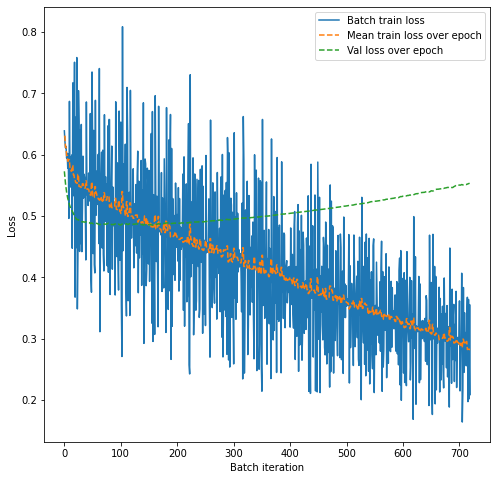

In [ ]:
plt.figure(figsize=[8, 8])
plt.plot(losses, label="Batch train loss")
num_batches = len(train_dataset) // 8 + min(len(train_dataset) % 8, 1)
mean_losses = sum([[np.mean(losses[i * num_batches : (i + 1) * num_batches])] * num_batches
               for i in range(num_epochs * num_batches // num_batches)], [])
plt.plot(mean_losses, '--', label="Mean train loss over epoch")
plt.plot(np.array(range(num_epochs)) * num_batches, val_losses, '--', label="Val loss over epoch")
plt.ylabel("Loss")
plt.xlabel("Batch iteration")
plt.legend()
plt.show()

### 5-fold cross-validation

In [ ]:
folds = []
for i in range(4):
    folds.append(data_list[4 * i : 4 * (i + 1)])
folds.append(data_list[16 : ])
print([len(f) for f in folds])

[4, 4, 4, 4, 5]



Iteration 1/5
Number of symptomatic cases in train data: 13
Number of asymptomatic cases in train data: 4
Number of symptomatic cases in val data: 3
Number of asymptomatic cases in val data: 1

Iteration 2/5
Number of symptomatic cases in train data: 12
Number of asymptomatic cases in train data: 5
Number of symptomatic cases in val data: 4
Number of asymptomatic cases in val data: 0

Iteration 3/5
Number of symptomatic cases in train data: 14
Number of asymptomatic cases in train data: 3
Number of symptomatic cases in val data: 2
Number of asymptomatic cases in val data: 2

Iteration 4/5
Number of symptomatic cases in train data: 13
Number of asymptomatic cases in train data: 4
Number of symptomatic cases in val data: 3
Number of asymptomatic cases in val data: 1

Iteration 5/5
Number of symptomatic cases in train data: 12
Number of asymptomatic cases in train data: 4
Number of symptomatic cases in val data: 4
Number of asymptomatic cases in val data: 1


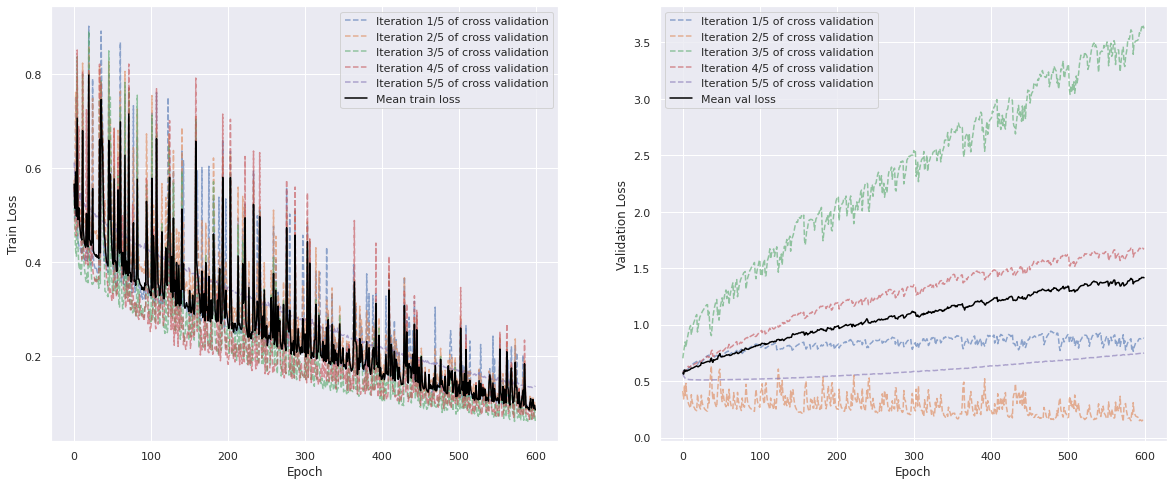

In [ ]:
import seaborn as sns
sns.set()

fig, ax = plt.subplots(1, 2, figsize=[20, 8])
ax[0].set_ylabel("Train Loss")
ax[0].set_xlabel("Epoch")
ax[1].set_ylabel("Validation Loss")
ax[1].set_xlabel("Epoch")

train_loss_arrays = []
val_loss_arrays = []

for val_idx in range(5):

    print()
    print(f"Iteration {val_idx + 1}/5")

    train_dataset = GaitSymptomDataset(sum([f for i, f in enumerate(folds) if i != val_idx], []))
    val_dataset = GaitSymptomDataset(folds[val_idx])

    print("Number of symptomatic cases in train data:", len([d[1] for d in train_dataset if d[1] == 1]))
    print("Number of asymptomatic cases in train data:", len([d[1] for d in train_dataset if d[1] == 0]))
    print("Number of symptomatic cases in val data:", len([d[1] for d in val_dataset if d[1] == 1]))
    print("Number of asymptomatic cases in val data:", len([d[1] for d in val_dataset if d[1] == 0]))   

    seed = 123
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    num_epochs = 600
    num_timesteps, num_features = train_dataset[0][0].shape

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, shuffle=True)
    model = MLPPredictor(num_timesteps, num_features)
    optimizer = optim.SGD(model.parameters(), lr=1e-3)
    loss_fn = nn.BCELoss()

    losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            inputs, targets = batch
            pred = model(inputs)
            loss = loss_fn(pred.squeeze(), targets.squeeze())
            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        val_loss = 0
        for batch in val_loader:
            inputs, targets = batch
            pred = model(inputs)
            val_loss += loss_fn(pred.squeeze(), targets.squeeze()).item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

    num_batches = len(train_loader)
    mean_losses = [np.mean(losses[i * num_batches : (i + 1) * num_batches])
            for i in range(num_epochs)]
    ax[0].plot(mean_losses, '--', label="Iteration {}/5 of cross validation".format(val_idx + 1), alpha=0.6)
    ax[1].plot(val_losses, '--', label="Iteration {}/5 of cross validation".format(val_idx + 1), alpha=0.6)

    train_loss_arrays.append(mean_losses)
    val_loss_arrays.append(val_losses)

ax[0].plot(np.sum(train_loss_arrays, axis=0) / 5, label="Mean train loss", color='black')
ax[1].plot(np.sum(val_loss_arrays, axis=0) / 5, label="Mean val loss", color='black')

ax[0].legend()
ax[1].legend()
plt.show()